Signal length: 1000
[  52.44366993 1752.64638978 2542.99254975 2555.48820943 2568.13688542
 2447.93953884 2460.89456268 2473.99790198 2421.24304088 2434.62098953
 2448.12033685 2461.7272371  2418.42539647 2432.19605938 2446.01805186
 2459.86776771 2460.71915473 2474.54370086]
Estimated corner frequency: 76551.80 Hz
18
Left index:  497 Right index:  515
Exponential tail removed.


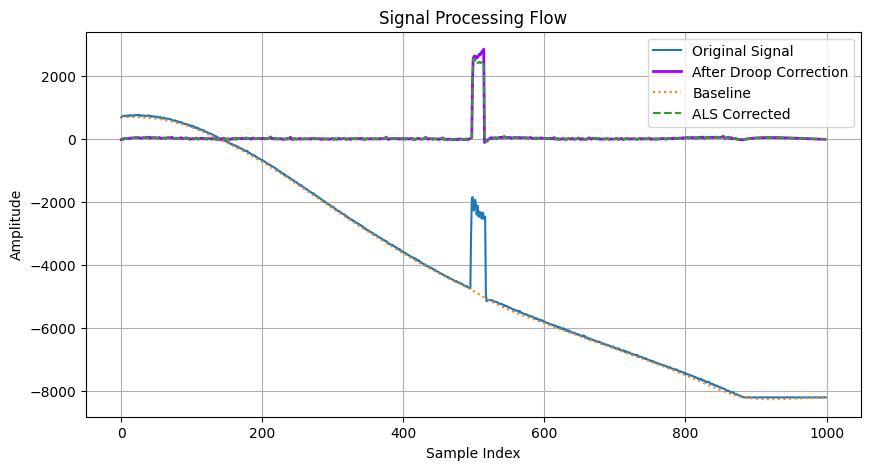

{'current': 2694.0378}
[  52.44366993 1752.64638978 2542.99254975 2555.48820943 2568.13688542
 2447.93953884 2460.89456268 2473.99790198 2421.24304088 2434.62098953
 2448.12033685 2461.7272371  2418.42539647 2432.19605938 2446.01805186
 2459.86776771 2460.71915473 2474.54370086]
Estimated corner frequency: 76551.80 Hz
18
Left index:  497 Right index:  515
Exponential tail removed.


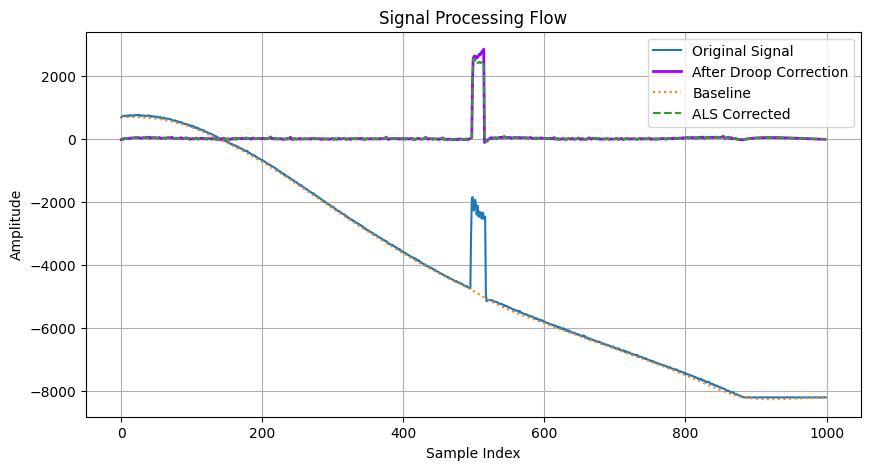

{'intensity': 44622.897}
L:D0TOR
Signal length: 1000
[33.97527958 46.93070482 70.9110845  92.91736028 91.95040292 55.01099025
 54.09980818 53.21748756 52.36460518 51.54168461 52.74919703 52.98756209
 51.25714672]
Estimated corner frequency: 111964.88 Hz
13
Left index:  545 Right index:  558
Exponential tail removed.


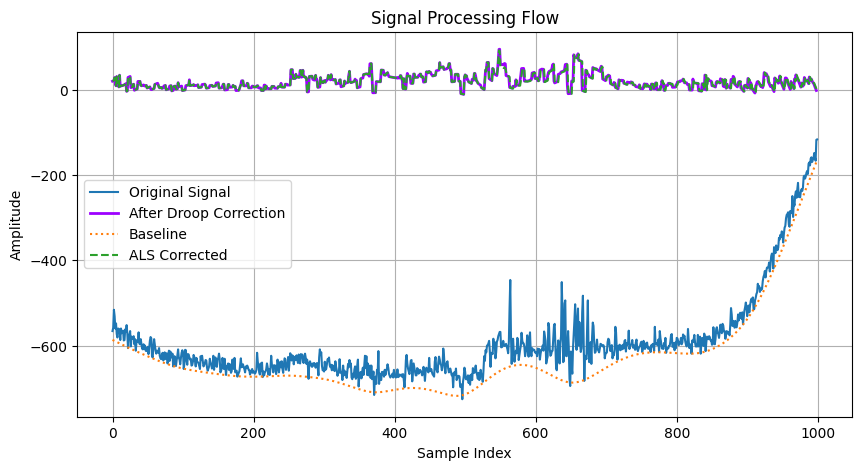

{'current': 95.6349}
L:D1TOR
Signal length: 1000
[39.24443296 45.94719625 52.65066634 59.35369282 66.05507265 75.75354344
 72.44777674 61.13636833 45.81784156 74.49065864 81.15323597 87.80391545
 64.44095782 71.06253603 74.66675858 72.25166291 78.8152118  85.35529576
 74.86972651 81.3562304  72.8124589  77.23598215 83.62429745 61.9748249 ]
Estimated corner frequency: 53355.25 Hz
24
Left index:  611 Right index:  635
Exponential tail removed.


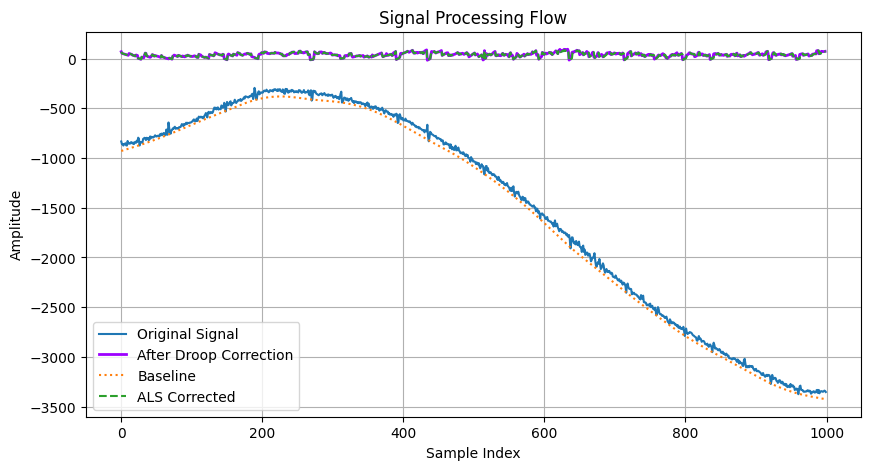

{'current': 89.3659}
L:D2TOR
Signal length: 1000
[ 116.29701393 1911.15854394 2535.97275319 2547.73530054 2559.43930884
 2260.07535324]
Estimated corner frequency: 475870.08 Hz
6
Left index:  497 Right index:  503
Exponential tail removed.


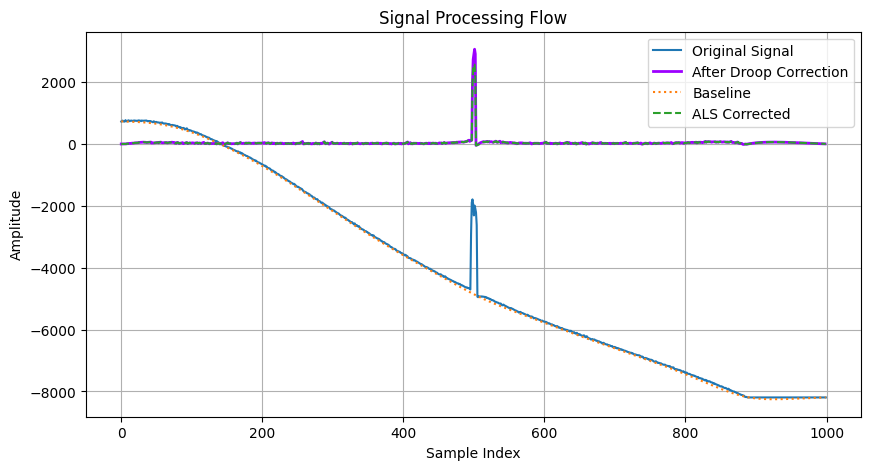

{'current': 2951.1772}
L:D3TOR
Signal length: 1000
[34.76223037 47.48992938 53.26566772 45.09077502 51.96652769 48.89415701
 40.87484232 44.90971406 79.99986178 72.14633014 64.35008379 48.61201523
 48.93295262 62.3136755  57.75491449 50.25733788 42.82155621 50.44812976
 57.13757601 52.89036196 48.70689749 41.58753959]
Estimated corner frequency: 56238.25 Hz
22
Left index:  177 Right index:  199
Exponential tail removed.


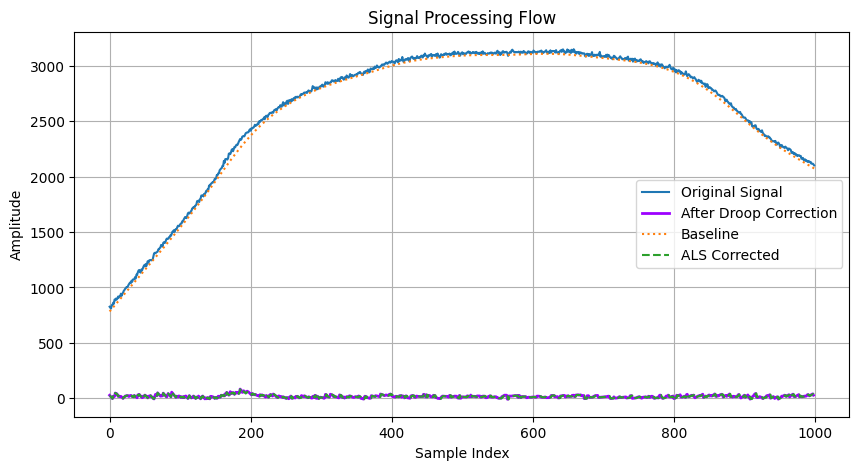

{'current': 79.0972}
L:D4TOR
Signal length: 1000
[16.16101576 19.10493633 24.07074891 23.05906347 21.07046593 21.10551912
 23.16476481 21.24872369 19.35789324 17.49274973 33.65375005 31.8413336
 30.05590614 28.29784158 26.56748377 21.86514827 20.19112405 18.54567826
 16.92905781]
Estimated corner frequency: 72137.79 Hz
19
Left index:  168 Right index:  187
Exponential tail removed.


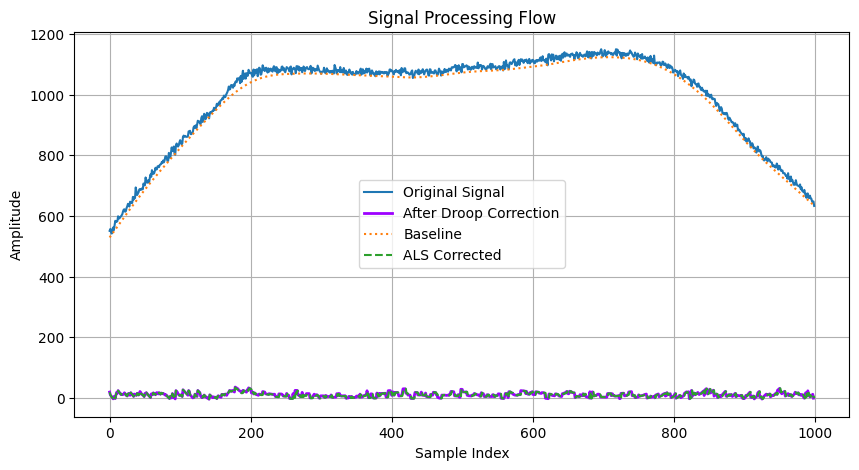

{'current': 33.776}
L:D5TOR
Signal length: 1000
[49.36242034 48.0261219  46.68977411 42.35327956 41.01649418 39.67923154
 26.34126419 25.00232501]
Estimated corner frequency: 237887.29 Hz
8
Left index:  0 Right index:  8
Exponential tail removed.


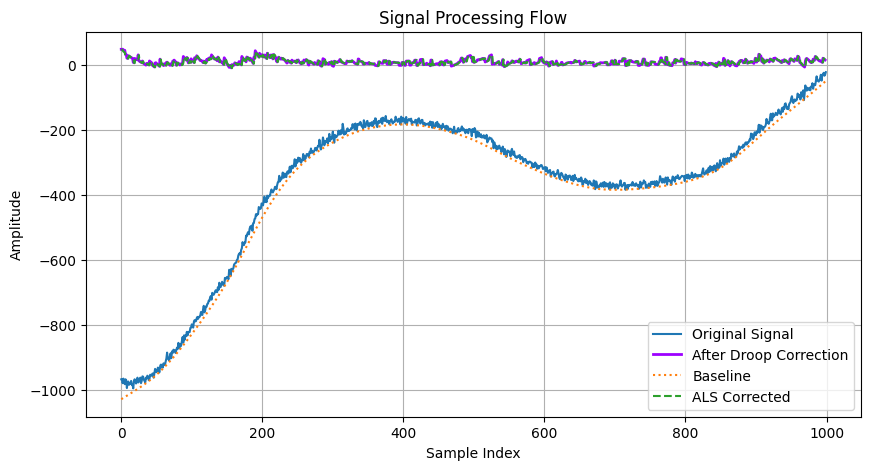

{'current': 47.5204}
L:D7TOR
Signal length: 1000
[ 84.81265532 135.54676735 135.26312819 143.9649683  134.65538287
 123.33732313 123.01360565 122.68692368 122.35984742 122.03482442
 136.71417985 137.40011685 124.09470184 123.79986385 181.51740782
 181.24901487 180.99618461 180.76023542 126.54230466 126.34334893
 126.16419831 126.00555652 134.86800111 149.75198364 151.65782079
 138.58567949 138.53557503 138.50738409 138.50084482 138.51555688]
Estimated corner frequency: 41390.53 Hz
30
Left index:  626 Right index:  656
Exponential tail removed.


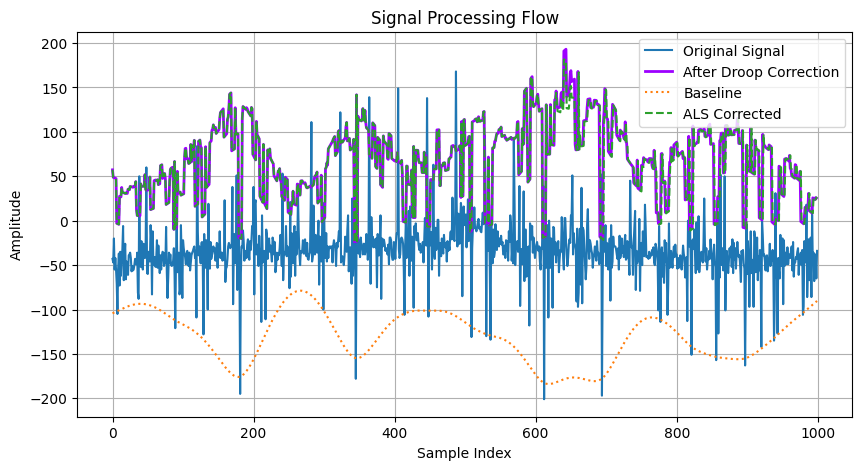

{'current': 192.0006}
L:D7TOR
Signal length: 1000
[  99.28406952 2886.37572649 4958.83512558 4961.67756931 4964.91340137
 4968.54800377 5433.5817936  5434.01021941 4733.82329617 4739.00560482
 4744.5369925  4750.39256734 4756.54269292 4948.95298245 4955.58429257
 4628.39253098 4635.32864981 4642.33897278 4649.36518827 4247.34434235]
Estimated corner frequency: 68976.50 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


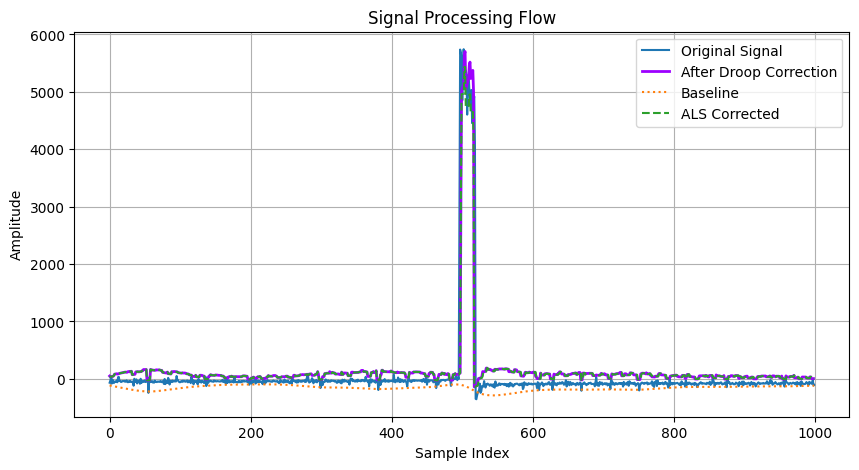

{'current': 5354.5374}
L:D7TOR
Signal length: 1000
[ 110.69071858 2745.01659929 4849.72550247 4850.83460502 4852.35623413
 4854.29786614 5226.66212504 5229.44678053 4761.64437563 4765.24222393
 4769.22287737 4773.56412265 4778.23897723 5129.21568504 5094.45771173
 4745.92339377 4751.56597316 4757.33394596 4763.17105669 4509.01629252]
Estimated corner frequency: 68625.51 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


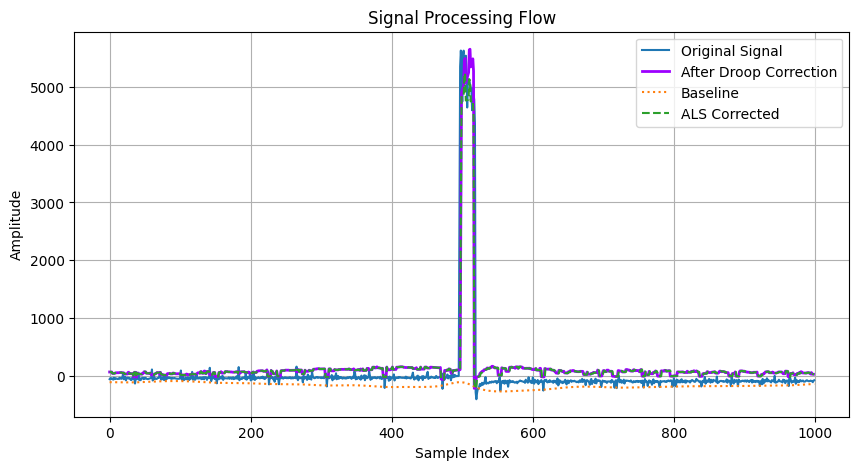

{'current': 5372.1523}
[ 110.69071858 2745.01659929 4849.72550247 4850.83460502 4852.35623413
 4854.29786614 5226.66212504 5229.44678053 4761.64437563 4765.24222393
 4769.22287737 4773.56412265 4778.23897723 5129.21568504 5094.45771173
 4745.92339377 4751.56597316 4757.33394596 4763.17105669 4509.01629252]
Estimated corner frequency: 68625.51 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


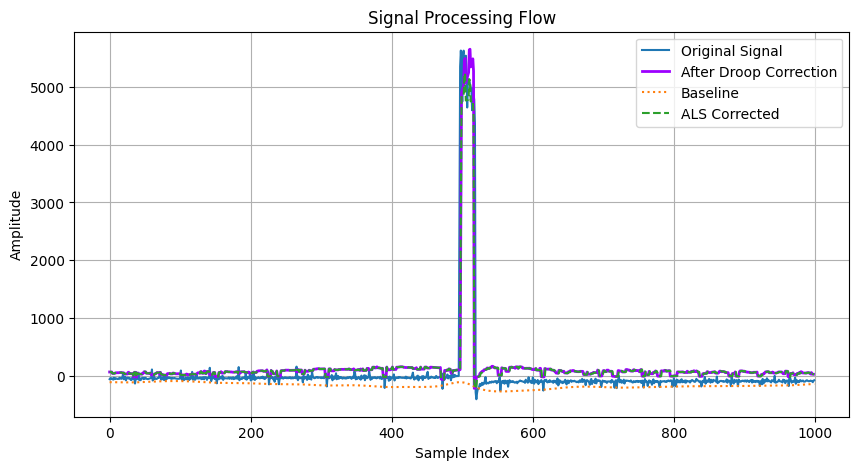

{'intensity': 97448.045}
L:D7TOR
Signal length: 1000
[ 119.01977616 2973.70208792 4848.74161782 4853.1509818  4857.93794709
 4863.10542775 5290.65147992 5132.56929661 4733.8467802  4740.46670048
 4747.40709343 4754.64125451 4762.13773182 5002.86031879 4940.76804674
 4800.81494409 4808.95009853 4817.11779691 4825.25751715 4455.30392003]
Estimated corner frequency: 68511.92 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


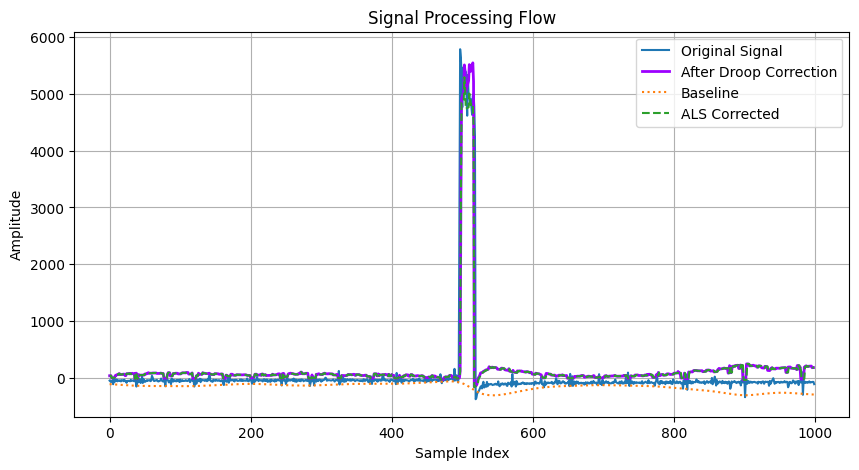

{'current': 5312.8824}
[ 119.01977616 2973.70208792 4848.74161782 4853.1509818  4857.93794709
 4863.10542775 5290.65147992 5132.56929661 4733.8467802  4740.46670048
 4747.40709343 4754.64125451 4762.13773182 5002.86031879 4940.76804674
 4800.81494409 4808.95009853 4817.11779691 4825.25751715 4455.30392003]
Estimated corner frequency: 68511.92 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


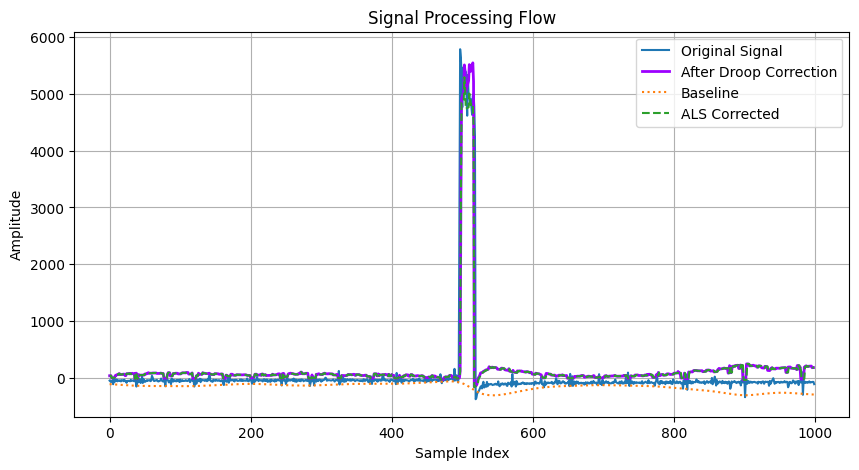

{'intensity': 97397.327}
L:D5TOR
Signal length: 1000
[  19.06360838 1712.24057666 2522.61973272 2525.20815356 2528.01039357
 2457.02848193 2460.26191983 2463.70775139 2430.36056051 2434.21246735
 2438.25316172 2442.46989924 2402.84749724 2407.36833061 2412.01237137
 2409.75718418 2414.5779217  2419.44732681 2424.33572784 2421.21103364]
Estimated corner frequency: 67704.80 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


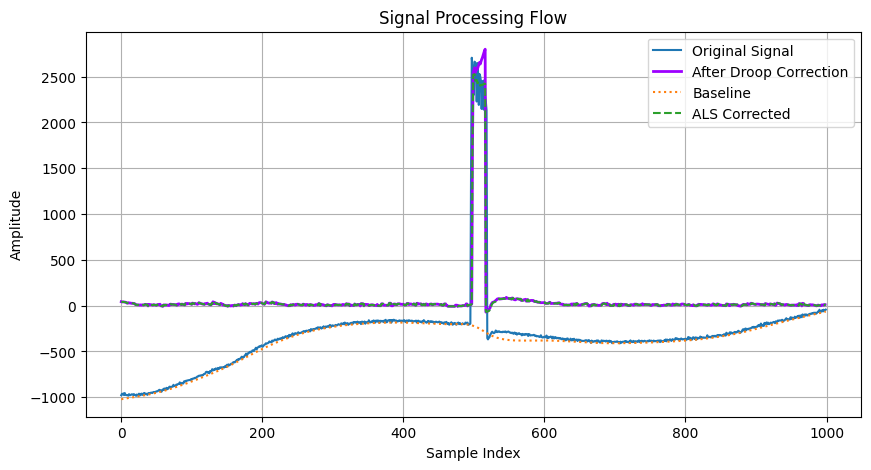

{'current': 2648.5392}
[  19.06360838 1712.24057666 2522.61973272 2525.20815356 2528.01039357
 2457.02848193 2460.26191983 2463.70775139 2430.36056051 2434.21246735
 2438.25316172 2442.46989924 2402.84749724 2407.36833061 2412.01237137
 2409.75718418 2414.5779217  2419.44732681 2424.33572784 2421.21103364]
Estimated corner frequency: 67704.80 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


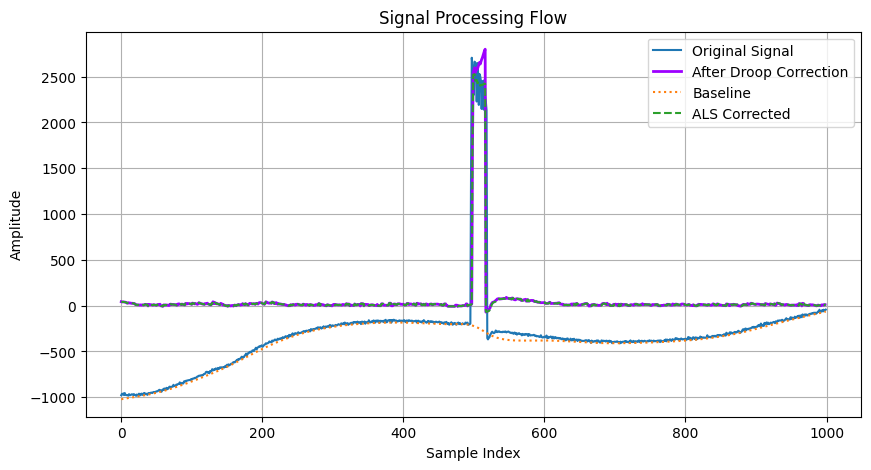

{'intensity': 49323.582}
L:D4TOR
Signal length: 1000
[   9.27937569 1973.91775399 2703.75088107 2705.78547235 2708.02553949
 2411.47238839 2414.12461691 2416.97841143 2420.02754422 2423.26337057
 2768.67482572 2772.24842168 2775.96790177 2779.81423705 2430.76562262
 2434.79747379 2438.88277506 2466.99207617 2471.09348796 2424.15265428]
Estimated corner frequency: 66927.68 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


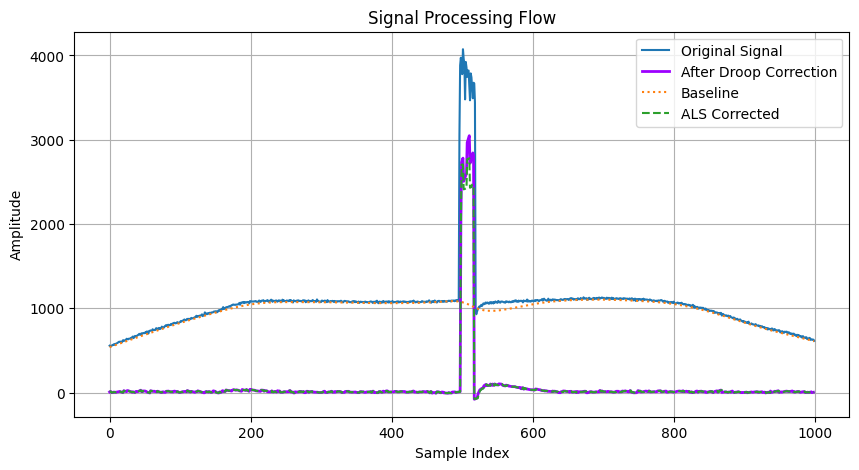

{'current': 2869.2984}
[   9.27937569 1973.91775399 2703.75088107 2705.78547235 2708.02553949
 2411.47238839 2414.12461691 2416.97841143 2420.02754422 2423.26337057
 2768.67482572 2772.24842168 2775.96790177 2779.81423705 2430.76562262
 2434.79747379 2438.88277506 2466.99207617 2471.09348796 2424.15265428]
Estimated corner frequency: 66927.68 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


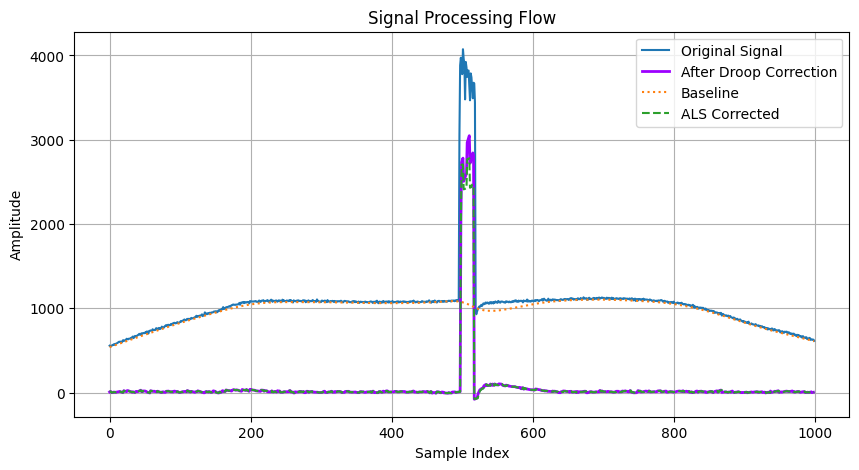

{'intensity': 51665.201}
L:D3TOR
Signal length: 1000
[   9.27937569 1973.91775399 2703.75088107 2705.78547235 2708.02553949
 2411.47238839 2414.12461691 2416.97841143 2420.02754422 2423.26337057
 2768.67482572 2772.24842168 2775.96790177 2779.81423705 2430.76562262
 2434.79747379 2438.88277506 2466.99207617 2471.09348796 2424.15265428]
Estimated corner frequency: 66927.68 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


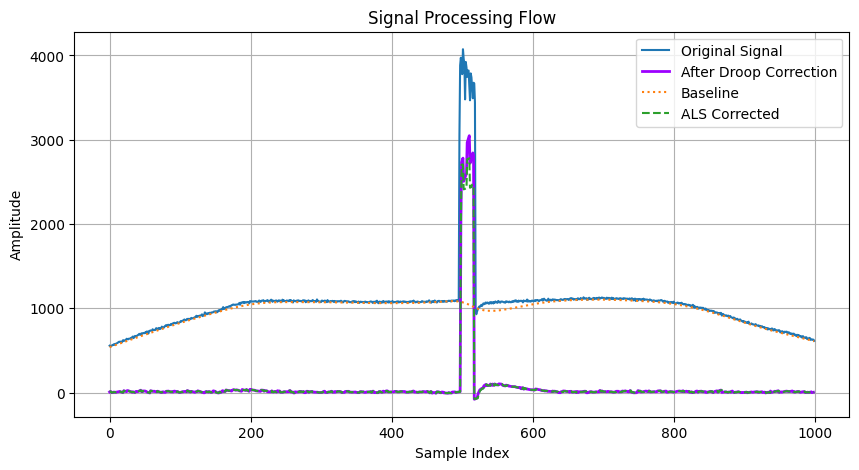

{'current': 2869.2984}
[   9.27937569 1973.91775399 2703.75088107 2705.78547235 2708.02553949
 2411.47238839 2414.12461691 2416.97841143 2420.02754422 2423.26337057
 2768.67482572 2772.24842168 2775.96790177 2779.81423705 2430.76562262
 2434.79747379 2438.88277506 2466.99207617 2471.09348796 2424.15265428]
Estimated corner frequency: 66927.68 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


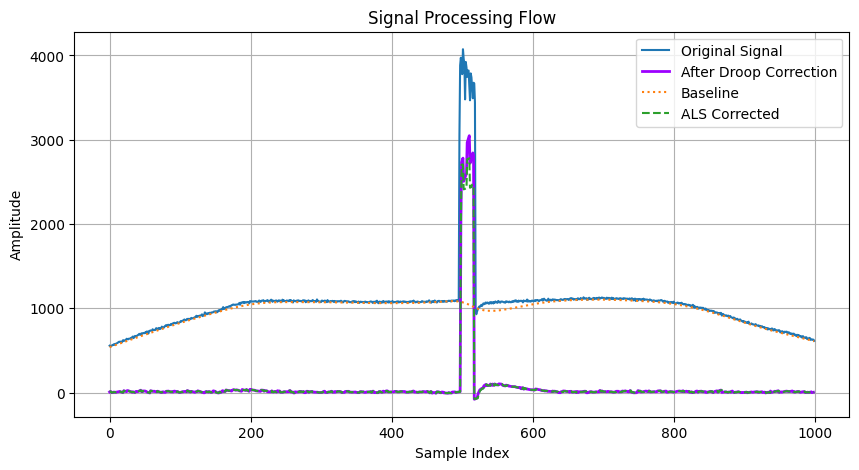

{'intensity': 51665.201}
L:D3TOR
Signal length: 1000
[  20.92030935 1880.82742912 2598.93941195 2600.26374687 2601.80532394
 2512.56643298 2514.546762   2516.74348644 2519.1512672  2521.76224842
 2524.56605511 2527.54979051 2408.69803328 2411.99283455 2415.41383674
 2418.93827029 2406.5409502  2410.19427257 2413.86822692 2383.53039261]
Estimated corner frequency: 67518.08 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


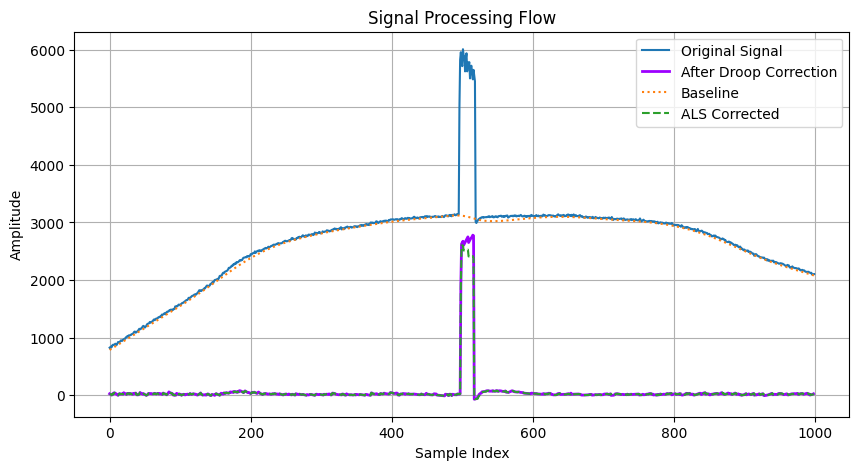

{'current': 2692.3926}
[  20.92030935 1880.82742912 2598.93941195 2600.26374687 2601.80532394
 2512.56643298 2514.546762   2516.74348644 2519.1512672  2521.76224842
 2524.56605511 2527.54979051 2408.69803328 2411.99283455 2415.41383674
 2418.93827029 2406.5409502  2410.19427257 2413.86822692 2383.53039261]
Estimated corner frequency: 67518.08 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


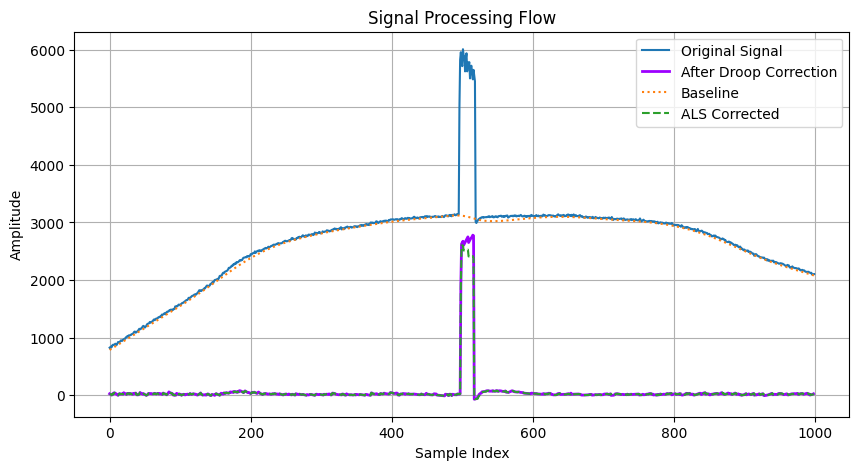

{'intensity': 50288.657}
L:D3TOR
Signal length: 1000
[  11.66639555 1990.63876798 2567.82360699 2569.22785091 2570.85587025
 2469.70946629 2471.78786947 2474.08784049 2476.60366829 2479.32716771
 2601.247677   2604.35205505 2607.62455953 2430.04684376 2433.59795341
 2437.25450414 2428.99067798 2432.77821972 2436.58644516 2420.38223732]
Estimated corner frequency: 67009.47 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


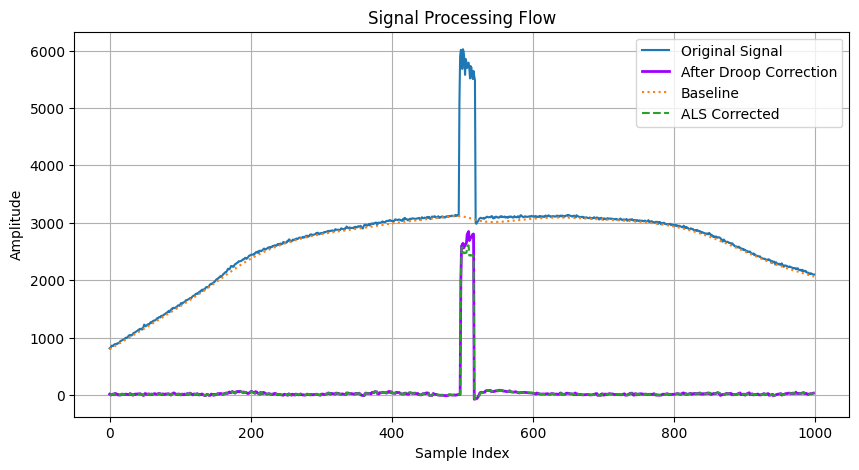

{'current': 2711.0006}
[  11.66639555 1990.63876798 2567.82360699 2569.22785091 2570.85587025
 2469.70946629 2471.78786947 2474.08784049 2476.60366829 2479.32716771
 2601.247677   2604.35205505 2607.62455953 2430.04684376 2433.59795341
 2437.25450414 2428.99067798 2432.77821972 2436.58644516 2420.38223732]
Estimated corner frequency: 67009.47 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


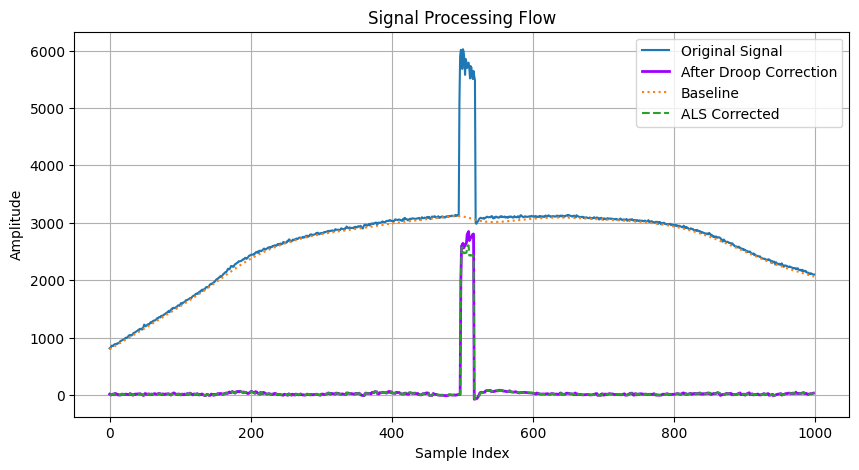

{'intensity': 50568.589}
L:D3TOR
hello
Signal length: 1000
[-2.21182043e+00  2.03560514e+03  2.68660346e+03  2.68779247e+03
  2.71417881e+03  2.46376642e+03  2.46555654e+03  2.46754794e+03
  2.46973692e+03  2.47211732e+03  2.59868052e+03  2.60141540e+03
  2.38030827e+03  2.38334282e+03  2.38650036e+03  2.38975983e+03
  2.34609777e+03  2.34948834e+03  2.35290335e+03  2.35631226e+03]
Estimated corner frequency: 67326.30 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


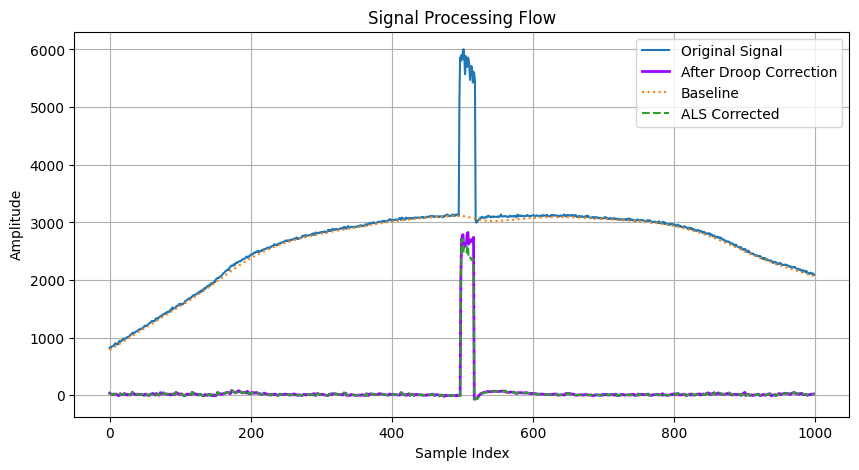

{'current': 2686.3694}
[-2.21182043e+00  2.03560514e+03  2.68660346e+03  2.68779247e+03
  2.71417881e+03  2.46376642e+03  2.46555654e+03  2.46754794e+03
  2.46973692e+03  2.47211732e+03  2.59868052e+03  2.60141540e+03
  2.38030827e+03  2.38334282e+03  2.38650036e+03  2.38975983e+03
  2.34609777e+03  2.34948834e+03  2.35290335e+03  2.35631226e+03]
Estimated corner frequency: 67326.30 Hz
20
Left index:  497 Right index:  517
Exponential tail removed.


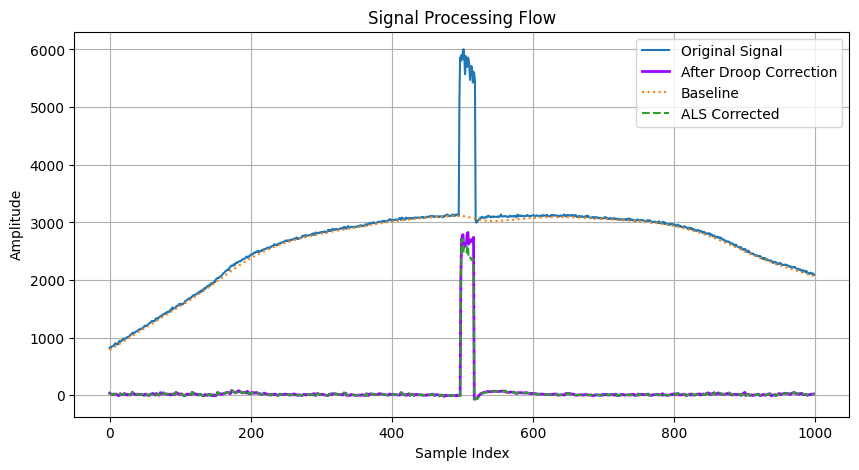

{'intensity': 50293.174}
L:D3TOR
hello
Signal length: 1000
[18.81670892 22.89742179 22.98505493 44.07985594 44.18204946 44.29181603]
Estimated corner frequency: 392980.99 Hz
6
Left index:  936 Right index:  942
Exponential tail removed.


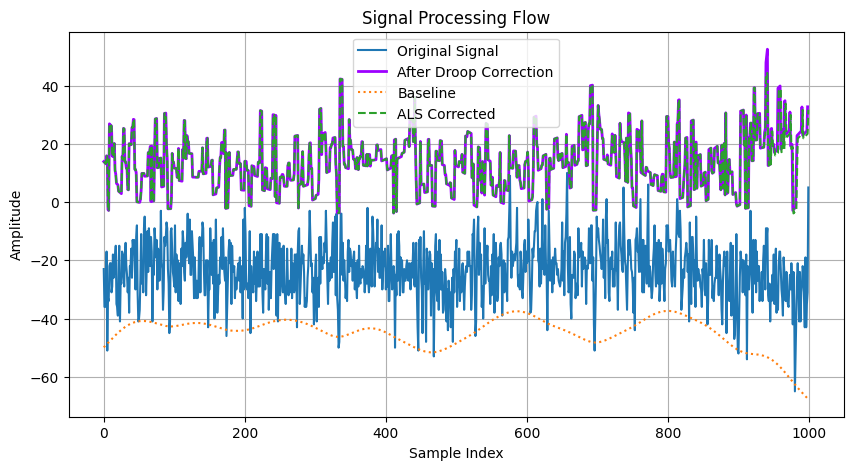

{'current': 50.1845}
[18.81670892 22.89742179 22.98505493 44.07985594 44.18204946 44.29181603]
Estimated corner frequency: 392980.99 Hz
6
Left index:  936 Right index:  942
Exponential tail removed.


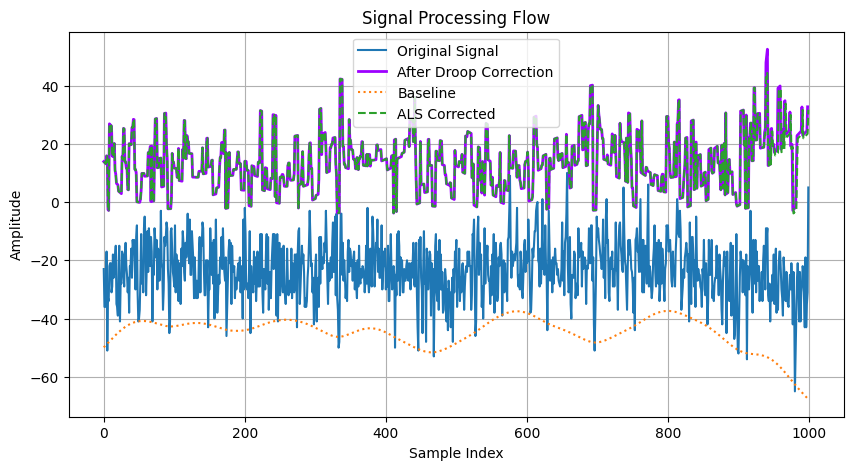

{'intensity': 182.8}
L:D3TOR
hello
Signal length: 1000
[18.13953655 28.02825551 27.91573324 27.80187531 36.68655939]
Estimated corner frequency: 473656.68 Hz
5
Left index:  287 Right index:  292
Exponential tail removed.


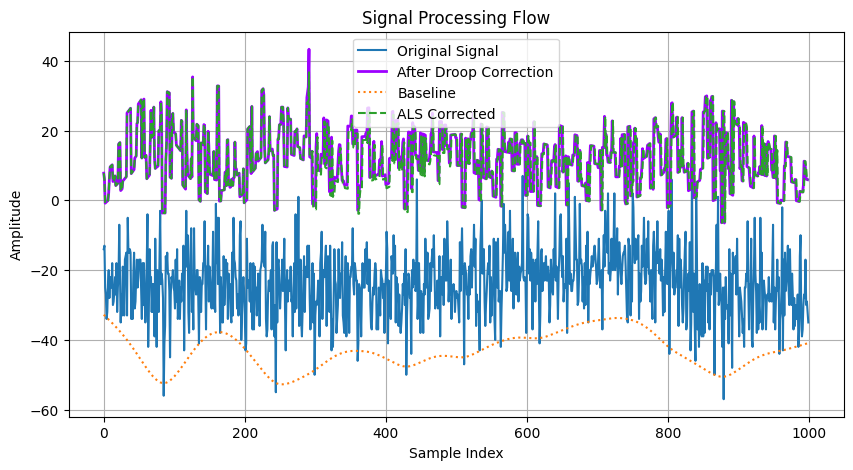

{'current': 43.3029}
[18.13953655 28.02825551 27.91573324 27.80187531 36.68655939]
Estimated corner frequency: 473656.68 Hz
5
Left index:  287 Right index:  292
Exponential tail removed.


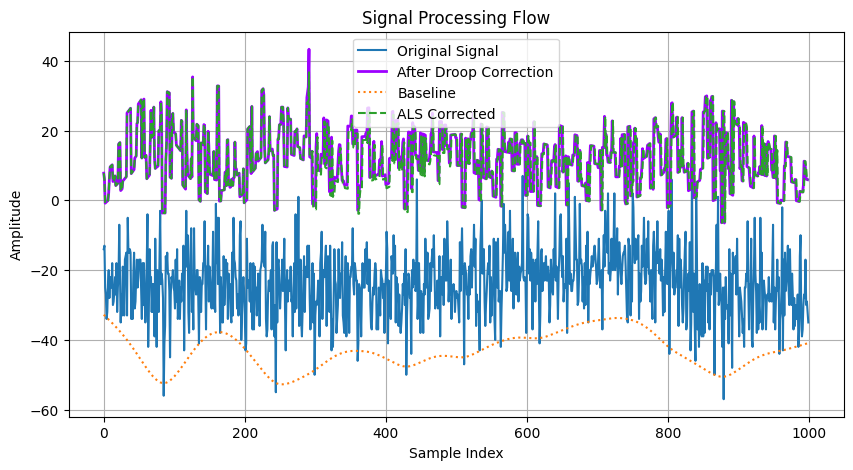

{'intensity': 123.577}
L:D3TOR
hello
Signal length: 1000
[ 8.92149268 15.01239039 29.10460255 29.19789867 29.29201917 29.38667527]
Estimated corner frequency: 430468.96 Hz
6
Left index:  920 Right index:  926
Exponential tail removed.


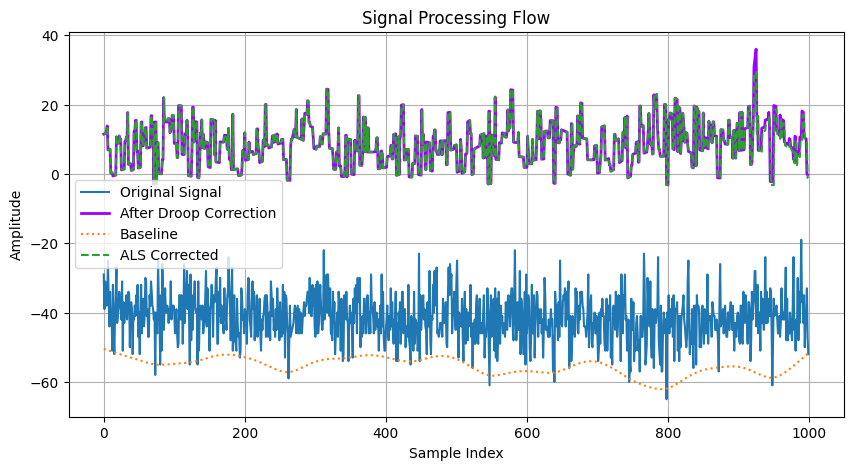

{'current': 34.2934}
[ 8.92149268 15.01239039 29.10460255 29.19789867 29.29201917 29.38667527]
Estimated corner frequency: 430468.96 Hz
6
Left index:  920 Right index:  926
Exponential tail removed.


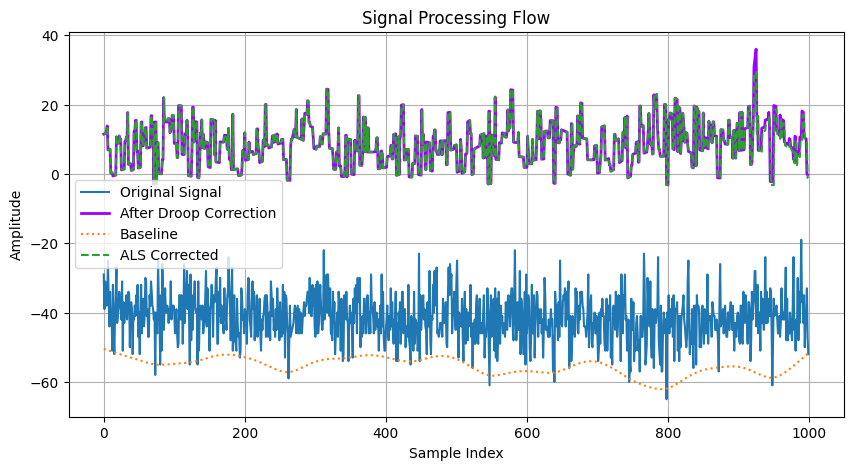

{'intensity': 135.959}


In [1]:
import json
import numpy as np
from scipy import sparse
from scipy.integrate import cumulative_trapezoid
from scipy.sparse.linalg import spsolve
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import pandas as pd
# from scipy.signal import savgol_filter
from scipy.optimize import curve_fit



def exp_model(t, A, tau, c):
    return A * np.exp(-t / tau) + c

def lowpass_model(f, fc, A):
    return A / np.sqrt(1 + (f / fc)**2)

def estimate_corner_frequency(y, sampling_rate):
    dt = 1 / sampling_rate
    n = len(y)

    # Pad if short for better FFT resolution
    n_fft = max(1024, 2 ** int(np.ceil(np.log2(n))))
    padded = np.pad(y, (0, n_fft - n), mode='constant')
    
    freqs = np.fft.rfftfreq(n_fft, dt)
    spectrum = np.abs(np.fft.rfft(padded))
    spectrum /= np.max(spectrum)

    fit_mask = (freqs > 500) & (freqs < sampling_rate / 10)
    if np.sum(fit_mask) < 5:
        raise ValueError("Not enough frequency points to fit")

    try:
        popt, _ = curve_fit(lowpass_model, freqs[fit_mask], spectrum[fit_mask], p0=[5000, 1])
        fc_est = popt[0]
        print(f"Estimated corner frequency: {fc_est:.2f} Hz")
        return fc_est
    except Exception as e:
        print("Corner frequency estimation failed:", e)
        return 5000  # fallback



def lowpass_filter(signal, sampling_rate, cutoff=100_000, order=3):
    nyq = 0.5 * sampling_rate
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low')
    return filtfilt(b, a, signal)

# Calculate the baseline using Asymmetric Least Squares Smoothing (ALS)
def als_baseline(y, lam=1e6, p=0.01, niter=10):
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.T)
        A = Z.tocsr()
        z = spsolve(A, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

def als_baseline_corrected(z):
    baseline = als_baseline(z)
    corrected = z - baseline
    return {
        'corrected': json.dumps(corrected.tolist())
    }

def squarify(y):
    _, corrected, peak_value, left_index, right_index = get_prereqs(y)
    corrected[left_index:right_index + 1] = peak_value
    corrected[right_index:] = 0
    corrected[:left_index] = 0
    return {
        'squarified': json.dumps(corrected.tolist())
    }
    

def width(y):
    left, right = get_prereqs(y)[3:]
    return {
        'width': right - left
    }


def current(y, sampling_rate=5_000_000, f_corner=250, peak_fraction=0.9):
    corrected = get_prereqs(y, sampling_rate, f_corner)[1]

    peak_index = np.argmax(corrected)
    peak_value = corrected[peak_index]
    threshold = peak_fraction * peak_value

    # Define top region: points above threshold
    top_indices = np.where(corrected >= threshold)[0]

    if len(top_indices) == 0:
        raise ValueError("No values found above threshold; check pulse shape or threshold level.")

    avg_current = np.mean(corrected[top_indices])
    # pulse_width = len(top_indices)
    # total_charge = avg_current * pulse_width / sampling_rate  # A × s = Coulombs

    return {
        'current': round(float(avg_current), 4),
        # 'duration': round(pulse_width / sampling_rate, 6),  # in seconds
        # 'charge': round(total_charge, 6),  # in Coulombs
    }


def intensity(y):
    _, corrected, _, left_index, right_index = get_prereqs(y)
    my_range = right_index - left_index
    ten_percent = int(my_range * 0.1)
    start = max(left_index - ten_percent, 0)
    end = min(right_index + ten_percent, len(corrected))

    y_slice = corrected[start:end]
    x_vals = np.arange(len(y_slice))

    area = np.trapezoid(y=y_slice, x=x_vals)
    return {
        'intensity': round(float(area), 3)  # ensure clean Redis output
    }


def mode_filter(signal, window_size=3):
    s = pd.Series(signal)
    filtered = s.rolling(window=window_size, center=True, min_periods=1)\
                .apply(lambda x: x.mode().iloc[0])
    return filtered.to_numpy()




def get_prereqs(y, sampling_rate=5_000_000, f_corner=4000):
    smoothed = mode_filter(y, window_size=5)
    baseline = als_baseline(smoothed, p=0.01, lam=1e4, niter=10)
    corrected = smoothed - baseline
    # corrected = savgol_filter(corrected, window_length=23, polyorder=2)


    peak_index = np.argmax(corrected)
    peak_value = corrected[peak_index]
    half_max = 0.5 * peak_value

    left_index = peak_index
    while left_index > 0 and corrected[left_index] > half_max:
        left_index -= 1

    right_index = peak_index
    while right_index < len(corrected) - 1 and corrected[right_index] > half_max:
        right_index += 1

    pulse_segment = corrected[left_index:right_index]
    if len(pulse_segment) == 0:
        raise ValueError("Pulse segment for corner frequency estimation is empty!")
    
    print(corrected[left_index:right_index])


    corner_freq = estimate_corner_frequency(pulse_segment, sampling_rate)

    droop = droop_correct(corrected, left_index, right_index, sampling_rate, corner_freq)

    print(right_index - left_index)

    print("Left index: ", left_index, "Right index: ", right_index)

    start = right_index + 5
    end = right_index + 200
    tail = corrected[start:end]
    dt = 1 / sampling_rate
    t_tail = np.arange(len(tail)) * dt

    try:
        popt, _ = curve_fit(
            exp_model, t_tail, tail,
            p0=[-0.01, 0.001, 0],
            bounds=([-1, 1e-6, -1], [0, 0.01, 1])
        )
        fitted_tail = exp_model(t_tail, *popt)

        # Subtract only the fitted exponential from the same region
        corrected[start:end] -= fitted_tail

        print("Exponential tail removed.")
    except Exception as e:
        print("Tail fit failed:", e)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(y, label='Original Signal')
    plt.plot(droop, label='After Droop Correction', linewidth=2, color='#9D00FF')
    # plt.plot(smoothed, label='Mode Filtered', linestyle='-.')
    plt.plot(baseline, label='Baseline', linestyle=':')
    plt.plot(corrected, label='ALS Corrected', linestyle='--')
    # plt.axvline(x=left_index, color='r', linestyle='--', label='Left Index')
    # plt.axvline(x=right_index, color='g', linestyle='--', label='Right Index')
    # plt.axhline(y=peak_value, color='orange', linestyle='--', label='Peak Value')
    plt.title('Signal Processing Flow')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()
    return baseline, droop, peak_value, left_index, right_index




def droop_correct(y, left, right, sampling_rate=5_000_000, f_corner=250):
    dt = 1 / sampling_rate
    
    alpha = 0.1
    droop_const = alpha * (2 * np.pi * f_corner)
    # try alpha = 0.2 to 0.5 and tune from there

    # Cumulative integral of the signal
    integral = cumulative_trapezoid(y[left:right], dx=dt, initial=0)

    # Apply correction
    corrected = np.concatenate((y[:left], y[left:right] + droop_const * integral, y[right + 1:]))

    # Optional: shift to start near 0
    # corrected -= np.min(corrected)

    return corrected


def extract_signal_from_binary(fields):
    """Extracts the first binary field and converts it into a NumPy array of int16."""
    for value in fields.values():
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
                return data
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue
    raise ValueError("No valid binary signal data found in stream entry.")


def measure(r, in_key, callback, out_key):
    """Continuously stream from Redis using XREAD and apply a processing callback."""
    last_id = '$'  # '$' starts from new entries
    while True:
        print("Listening for data...")
        entries = r.xread({in_key: last_id}, block=1000, count=1)
        if entries:
            print("Got entries...")
            for stream_name, messages in entries:
                for msg_id, fields in messages:
                    try:
                        y = extract_signal_from_binary(fields)  # <- updated to binary
                        result = callback(y)  # Must return a dictionary
                        r.xadd(out_key, result, maxlen=10)
                        last_id = msg_id  # move forward in the stream
                        print(f"Processed entry {msg_id} from {in_key}")
                    except Exception as e:
                        print(f"Error processing entry {msg_id}: {e}")


def process_pulse(y):
    baseline, corrected, peak_value, left_index, right_index = get_prereqs(y)

    flattened = corrected.copy()
    flattened[left_index:right_index + 1] = peak_value
    flattened[:left_index] = 0
    flattened[right_index:] = 0
    rectified = flattened + baseline

    pulse_width = int(right_index - left_index)
    current = peak_value
    intensity = current * pulse_width

    return {
        'signal': json.dumps(rectified.tolist()),
        'current': round(current, 4),
        'intensity': round(intensity, 4),
        'width': pulse_width
    }







if __name__ == "__main__":
    bin = "\xb9\x02\xde\x02\xe4\x02\xe5\x02\xed\x02\xdd\x02\xe9\x02\xe1\x02\xf2\x02\xf1\x02\xf9\x02\xe2\x02\xee\x02\x02\x03\xf4\x02\xeb\x02\xee\x02\xf9\x02\xf2\x02\x00\x03\xf6\x02\xfe\x02\x05\x03\xf8\x02\a\x03\xf1\x02\x03\x03\xfb\x02\xe1\x02\xea\x02\xf6\x02\xec\x02\xf4\x02\xf0\x02\xe3\x02\xe7\x02\xe6\x02\xf0\x02\xeb\x02\xf5\x02\xec\x02\xcd\x02\xeb\x02\xd3\x02\xdb\x02\xd4\x02\xd5\x02\xd9\x02\xc6\x02\xc7\x02\xcb\x02\xd2\x02\xbe\x02\xb0\x02\xb4\x02\xc4\x02\xbe\x02\xa6\x02\x9a\x02\xa2\x02\x95\x02\xb7\x02\x98\x02\x89\x02\x8d\x02\x8c\x02\x92\x02\x90\x02\x85\x02\x81\x02r\x02r\x02m\x02\\\x02Q\x02R\x02J\x02[\x02<\x02B\x029\x02.\x02\x19\x02\x1b\x02&\x02\x1b\x02\x06\x02\x02\x02\xfe\x01\xf3\x01\xe7\x01\xe7\x01\xdf\x01\xda\x01\xd3\x01\xd1\x01\xc7\x01\xb3\x01\xb4\x01\x91\x01\xb5\x01\xa1\x01\x86\x01\x9d\x01\x81\x01h\x01x\x01h\x01m\x01k\x01K\x013\x01=\x01.\x011\x01$\x01\x1b\x01\x1d\x01\t\x01\xef\x00\xed\x00\xea\x00\xde\x00\xc2\x00\xca\x00\xbe\x00\xb6\x00\xb2\x00\xa7\x00\x90\x00\x7f\x00\x84\x00z\x00d\x00e\x00W\x00@\x00A\x00+\x00\x11\x00 \x00\x12\x00\x01\x00\xec\xff\xf1\xff\xec\xff\xd3\xff\xce\xff\xc9\xff\xbc\xff\xb2\xff\x9c\xff\xa7\xff\x8a\xff\x87\xff{\xff\\\xfff\xff_\xffS\xff>\xffC\xff8\xff.\xff\n\xff\x1c\xff\x0f\xff\x00\xff\xeb\xfe\xe7\xfe\xd8\xfe\xcc\xfe\xc4\xfe\xbf\xfe\xae\xfe\x9d\xfe\x8b\xfe\x94\xfe\x86\xfe\x8a\xfea\xfeU\xfeQ\xfeD\xfe'\xfe \xfe\x0b\xfe\x12\xfe\b\xfe\x01\xfe\xeb\xfd\xce\xfd\xd3\xfd\xbb\xfd\xac\xfd\xa1\xfd\x9a\xfd\x8a\xfd\x80\xfdk\xfdX\xfda\xfdO\xfd@\xfd2\xfd\x1d\xfd\a\xfd\x05\xfd\xf8\xfc\xe8\xfc\xd7\xfc\xd7\xfc\xc0\xfc\xae\xfc\xa3\xfc\x97\xfc\x90\xfcz\xfcs\xfcg\xfc<\xfcF\xfc.\xfc\x1b\xfc\x0c\xfc\xf6\xfb\xff\xfb\xe8\xfb\xda\xfb\xc4\xfb\xb7\xfb\x96\xfb\xa4\xfb\x88\xfbn\xfbk\xfbe\xfbW\xfb8\xfb8\xfb,\xfb\x18\xfb\x0b\xfb\xed\xfa\xe8\xfa\xe5\xfa\xb6\xfa\xb3\xfa\xb7\xfa\xa5\xfa\x89\xfaw\xfao\xfad\xfaU\xfa<\xfaE\xfa \xfa\x10\xfa\b\xfa\xfc\xf9\xe2\xf9\xdd\xf9\xcf\xf9\xb5\xf9\xa9\xf9\xa2\xf9\x94\xf9\x80\xf9o\xf9b\xf9H\xf9Y\xf9>\xf9%\xf9$\xf9\x02\xf9\xf8\xf8\xe5\xf8\xdb\xf8\xd0\xf8\xb5\xf8\xad\xf8\x9f\xf8\x82\xf8r\xf8o\xf8N\xf8T\xf87\xf8/\xf8!\xf8\t\xf8\xf7\xf7\xec\xf7\xe8\xf7\xd5\xf7\xb1\xf7\xac\xf7\x9c\xf7\xab\xf7\x90\xf7\x84\xf7T\xf7U\xf7N\xf7<\xf7\x1d\xf7\x13\xf7\x14\xf7\x11\xf7\xec\xf6\xe3\xf6\xcf\xf6\xc1\xf6\xb6\xf6\xb3\xf6\xa1\xf6\x93\xf6{\xf6r\xf6I\xf6G\xf6=\xf60\xf6\x19\xf6\x12\xf6\t\xf6\xe7\xf5\xf1\xf5\xe1\xf5\xcc\xf5\xc5\xf5\xad\xf5\x9b\xf5\x97\xf5~\xf5\x82\xf5d\xf5R\xf5Y\xf5@\xf5(\xf5)\xf5\x03\xf5\xfe\xf4\xf2\xf4\xce\xf4\xcd\xf4\xc3\xf4\xb2\xf4\xb3\xf4\x9b\xf4\x8a\xf4}\xf4v\xf4]\xf4\\\xf4K\xf40\xf4!\xf4#\xf4\x16\xf4\x03\xf4\xf0\xf3\xdd\xf3\xdc\xf3\xc9\xf3\xc3\xf3\xa7\xf3\xa2\xf3\x93\xf3\x86\xf3~\xf3g\xf3g\xf3Z\xf3<\xf35\xf3\"\xf3\x03\xf3\x02\xf3\xf9\xf2\xe2\xf2\xdb\xf2\xec\xf2\xcf\xf2\xb3\xf2\xb2\xf2\xac\xf2\x8e\xf2\x8a\xf2p\xf2c\xf2N\xf2\\\xf28\xf22\xf2\x1e\xf2\x12\xf2\n\xf2\xee\xf1\xef\xf1\xe7\xf1\xcd\xf1\xb7\xf1\xb8\xf1\xaf\xf1\x9b\xf1\x89\xf1v\xf1q\xf1r\xf1Z\xf1S\xf13\xf1C\xf1\r\xf12\xf1\xfa\xf0\xff\xf0\xf0\xf0\xfb\xf0\xe4\xf0\xcf\xf0\xc1\xf0\xaf\xf0\xa1\xf0\x93\xf0\x82\xf0}\xf0}\xf0`\xf0O\xf0K\xf0=\xf0/\xf0!\xf0\x1c\xf0\x0c\xf0\x0f\xf0\xf7\xef\xe9\xef\xe4\xef\xc4\xef\xcc\xef\xbb\xef\xb0\xef\x9f\xef\x91\xef\x87\xefq\xefu\xef_\xefN\xefN\xef<\xef2\xef/\xef\x12\xef\r\xef\x03\xef\xf7\xee\xdc\xee\xe5\xee\xce\xee\xc5\xee\xbb\xee\xb1\xee\xa9\xee\x98\xee}\xee~\xeep\xee\\\xeeq\xeeY\xeeI\xeeH\xee+\xee7\xee)\xee\x16\xee\x13\xee\x06\xee\xf2\xed\xe9\xed\xdb\xed\xc7\xed\xd0\xed\xbe\xed\xbf\xed\x9f\xed\x97\xed\x90\xed\x87\xed\x1f\xf4[\xf8\xd4\xf8\a\xf8)\xf7i\xf8\x82\xf8\xcf\xf7\xa4\xf6\xc8\xf7%\xf7b\xf6\a\xf7\xd2\xf6\xe7\xf6)\xf6\xe9\xf6\xdf\xf6*\xf6\x1c\xf6k\xf6\xd1\xec\xf1\xeb\xf7\xeb\x0c\xec\x15\xec\x10\xec\x0c\xec\x0f\xec\x0f\xec\x0c\xec\xf8\xeb\xf1\xeb\xe0\xeb\xdb\xeb\xd9\xeb\xd8\xeb\xcb\xeb\xc3\xeb\x9f\xeb\xa0\xeb\xa4\xeb\x90\xeb\x9b\xeb\x93\xeb\x83\xebi\xebR\xebi\xebY\xebW\xebM\xeb1\xeb3\xeb,\xeb\x16\xeb\x14\xeb\n\xeb\xff\xea\xed\xea\xd7\xea\xe9\xea\xc8\xea\xcc\xea\xcf\xea\xbd\xea\xba\xea\xa5\xea\x99\xea\xb9\xea\x91\xea\x81\xea\x86\xeas\xeae\xea_\xeaV\xeaZ\xeaG\xea:\xeaC\xea%\xea#\xea\x17\xea\a\xea\x11\xea\b\xea\x06\xea\xf2\xe9\xe4\xe9\xd0\xe9\xd4\xe9\xbd\xe9\xcd\xe9\xbb\xe9\xa5\xe9\xa9\xe9\xa8\xe9\x8d\xe9\x90\xe9\x81\xe9\x8f\xe9}\xe9p\xe9j\xe9X\xe9G\xe9F\xe99\xe97\xe92\xe9\x1c\xe9\x18\xe9\x0f\xe9\x05\xe9\a\xe9\xf9\xe8\xeb\xe8\xf4\xe8\xeb\xe8\xda\xe8\xd8\xe8\xb6\xe8\xba\xe8\xc5\xe8\x97\xe8\xad\xe8\xaa\xe8\x81\xe8u\xe8\x84\xe8\x98\xe8i\xe8v\xe8c\xe8C\xe8T\xe8R\xe8,\xe8H\xe8?\xe8*\xe8\"\xe8\x0f\xe8\x04\xe8\x00\xe8\a\xe8\x05\xe8\xea\xe7\xd1\xe7\xd2\xe7\xdf\xe7\xc4\xe7\xc4\xe7\xbc\xe7\xb2\xe7\xad\xe7\xa1\xe7\x88\xe7\xb3\xe7\x93\xe7\xa5\xe7k\xe7^\xe7u\xe7W\xe7E\xe7R\xe7R\xe7#\xe76\xe71\xe7-\xe7\x17\xe7\x17\xe7\x0c\xe7\xfa\xe6\xfe\xe6\xfa\xe6\xf3\xe6\xde\xe6\xe5\xe6\xe9\xe6\xd0\xe6\xcb\xe6\xb6\xe6\xbe\xe6\xa6\xe6\xa0\xe6\x9c\xe6\x8b\xe6\x90\xe6\x83\xe6\x8c\xe6t\xe6s\xe6m\xe6Z\xe6W\xe6?\xe6E\xe6T\xe61\xe6+\xe6#\xe6\x10\xe6\x12\xe6\x10\xe6\x1b\xe6\r\xe6\t\xe6\xe0\xe5\xd9\xe5\xd7\xe5\xda\xe5\xdd\xe5\xce\xe5\xc4\xe5\xa4\xe5\xc8\xe5\xa7\xe5\x9e\xe5\x9d\xe5\x8e\xe5\x97\xe5\x8f\xe5q\xe5c\xe5g\xe5e\xe5V\xe5R\xe5J\xe5>\xe5;\xe5-\xe5A\xe5\x1c\xe5\x05\xe5\r\xe5\x0c\xe5\a\xe5\x03\xe5\xe9\xe4\xe6\xe4\xdf\xe4\xdb\xe4\xc5\xe4\xd5\xe4\xc7\xe4\xb9\xe4\xaa\xe4\x9f\xe4\x9f\xe4\x8e\xe4\x92\xe4w\xe4k\xe4}\xe4u\xe4^\xe4W\xe4K\xe4?\xe4L\xe4@\xe4%\xe4\"\xe4\x1b\xe4\x1d\xe4\x10\xe4\x02\xe4\x04\xe4\xfd\xe3\xf2\xe3\xeb\xe3\xe5\xe3\xd3\xe3\xc7\xe3\xcd\xe3\xb0\xe3\xad\xe3\xc1\xe3\xb2\xe3\x9d\xe3\x92\xe3\x8e\xe3\x89\xe3\x82\xe3l\xe3k\xe3{\xe3m\xe3P\xe3J\xe3D\xe3/\xe38\xe31\xe3&\xe3 \xe3\x0f\xe3\b\xe3\x10\xe3\t\xe3\xe0\xe2\xe0\xe2\xe3\xe2\xdb\xe2\xcf\xe2\xc7\xe2\xbe\xe2\xb9\xe2\xa8\xe2\xae\xe2\x9f\xe2\x99\xe2}\xe2\x88\xe2w\xe2j\xe2f\xe2E\xe2O\xe2R\xe2L\xe23\xe2E\xe2\x17\xe2\"\xe2\x1c\xe2\x10\xe2\x0c\xe2\xe9\xe1\xd5\xe1\xf1\xe1\xf6\xe1\xe7\xe1\xde\xe1\xb7\xe1\xb1\xe1\xb9\xe1\x9e\xe1\xa6\xe1\x94\xe1\x87\xe1{\xe1\x80\xe1k\xe1r\xe1a\xe1S\xe1D\xe1E\xe1=\xe1,\xe1\x1f\xe1\x1d\xe1\x1d\xe1\x10\xe1\a\xe1\xf3\xe0\xeb\xe0\xca\xe0\xc9\xe0\xd7\xe0\xc9\xe0\xab\xe0\xa8\xe0\x9d\xe0\xaa\xe0\xa2\xe0\xa3\xe0r\xe0s\xe0g\xe0e\xe0a\xe0Y\xe0C\xe0?\xe0<\xe0\x1e\xe0+\xe0\x1d\xe0\x10\xe0\n\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0"
    bin = bin.encode('latin-1')  # Convert to bytes
    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))
    print(intensity(y))


    # L:D0TOR
    print("L:D0TOR")
    bin = "\xca\xfd\xd2\xfd\xfc\xfd\xed\xfd\xd0\xfd\xdc\xfd\xc3\xfd\xbb\xfd\xd0\xfd\xcf\xfd\xcd\xfd\xb5\xfd\xd0\xfd\xc5\xfd\xc7\xfd\xcb\xfd\xb4\xfd\xb5\xfd\xce\xfd\xc9\xfd\xd8\xfd\xc4\xfd\xa2\xfd\xc1\xfd\xc1\xfd\xca\xfd\xa6\xfd\xbd\xfd\xb8\xfd\xbb\xfd\xbe\xfd\xab\xfd\xb7\xfd\x9c\xfd\xb0\xfd\xb5\xfd\xb1\xfd\xc7\xfd\xad\xfd\xab\xfd\xb7\xfd\xac\xfd\xa1\xfd\x9f\xfd\xab\xfd\xa0\xfd\xa8\xfd\x9c\xfd\x9b\xfd\xa1\xfd\xa5\xfd\x94\xfd\xa2\xfd\xb3\xfd\xbc\xfd\xb9\xfd\x8f\xfd\x8c\xfd\xa5\xfd\xb7\xfd\xa9\xfd\x9d\xfd\x95\xfd\x9c\xfd\x9b\xfd\x97\xfd\xa2\xfd\x90\xfd\x8a\xfd\x88\xfd\x93\xfd\x97\xfd\x85\xfd\x89\xfd\x98\xfd\x89\xfd\x88\xfd\x96\xfd~\xfd\x85\xfd\x9c\xfd\x84\xfd\x9a\xfd\x93\xfd\x8c\xfd\x95\xfdw\xfd\x80\xfd\x8f\xfd\x80\xfdx\xfd\x86\xfd\x91\xfd\x9f\xfd\x8c\xfd\x87\xfd|\xfd\x8b\xfd\x97\xfd\x9d\xfd\x98\xfdq\xfd~\xfd\x9e\xfd\x9d\xfd\x85\xfd{\xfd\x94\xfd\x93\xfd\x8c\xfd\x87\xfd\x89\xfdy\xfdz\xfd\x82\xfd\x92\xfd\x8d\xfd\x83\xfdw\xfd\x8b\xfd\x82\xfd\x81\xfd~\xfdx\xfdq\xfd\x8f\xfd\x86\xfd\x90\xfd\x84\xfdw\xfdz\xfd\x7f\xfd\x86\xfd\x85\xfdt\xfdm\xfdr\xfdw\xfd\x89\xfd~\xfd}\xfdr\xfd|\xfd\x90\xfdo\xfd\x85\xfd\x8c\xfdy\xfdv\xfd\x87\xfd\x8b\xfd\x95\xfd\x88\xfdi\xfdm\xfds\xfd\x8b\xfd|\xfdq\xfd\x89\xfdv\xfdc\xfdx\xfdw\xfd~\xfdo\xfd}\xfdr\xfdh\xfdl\xfd\x87\xfdv\xfdq\xfd\x8b\xfdi\xfdl\xfdm\xfd_\xfdc\xfdh\xfdl\xfdz\xfd\x8a\xfdu\xfdy\xfd|\xfdu\xfdq\xfdi\xfdw\xfds\xfdy\xfdu\xfdo\xfdn\xfdd\xfdm\xfdi\xfdq\xfdh\xfdl\xfdj\xfdf\xfdi\xfdo\xfd\x97\xfd\x82\xfdw\xfdi\xfdd\xfd~\xfdl\xfd\x80\xfd^\xfdk\xfdb\xfdi\xfdk\xfdq\xfd~\xfdu\xfdd\xfdp\xfdc\xfds\xfd\x90\xfd{\xfdv\xfdi\xfdz\xfdw\xfdy\xfde\xfdq\xfd\x87\xfdz\xfdi\xfdv\xfd\x82\xfdu\xfd\x83\xfdq\xfdh\xfd{\xfd\x8a\xfd\x88\xfdo\xfdw\xfdz\xfd\x8d\xfdm\xfd\x80\xfd\x96\xfd\x91\xfd\x85\xfd\x91\xfd\x8f\xfd|\xfd\x88\xfd\x8e\xfd\x86\xfd\x91\xfd\x87\xfd\x7f\xfd\x93\xfd\x8e\xfd~\xfd\x94\xfd\x8e\xfd\x93\xfd\x82\xfd\x7f\xfd\x8e\xfd\x95\xfd\x8b\xfd}\xfd\x87\xfdz\xfdZ\xfd~\xfd\x83\xfd~\xfdx\xfdv\xfd~\xfdy\xfd\x7f\xfd}\xfdt\xfd{\xfd\x7f\xfdt\xfdb\xfd\x8c\xfd\x9f\xfd\x92\xfd\x98\xfdx\xfdn\xfdo\xfdk\xfd\x82\xfdo\xfdq\xfd}\xfd\x88\xfd\x86\xfd\x8c\xfdz\xfdu\xfd{\xfdn\xfdz\xfdr\xfdo\xfdl\xfd\x83\xfdv\xfdn\xfda\xfdg\xfdh\xfd\x88\xfdp\xfdh\xfdi\xfdW\xfdy\xfdb\xfdm\xfdc\xfdi\xfd\\\xfdl\xfd}\xfdu\xfd\x86\xfd{\xfd~\xfd]\xfdY\xfdf\xfd^\xfdp\xfdw\xfdZ\xfd^\xfdy\xfd\x87\xfdH\xfd`\xfdh\xfdj\xfd[\xfdk\xfdt\xfdc\xfdx\xfd\x90\xfds\xfd\x8f\xfdc\xfd~\xfdb\xfdj\xfdy\xfd\\\xfdy\xfdY\xfd[\xfdk\xfd4\xfd\\\xfd_\xfdN\xfdo\xfdh\xfd\x9b\xfdN\xfdf\xfdZ\xfdW\xfdj\xfdj\xfdf\xfd_\xfdo\xfdc\xfdm\xfdq\xfd|\xfdt\xfdf\xfda\xfd]\xfd`\xfdb\xfdf\xfd]\xfdo\xfdi\xfd^\xfd]\xfd`\xfdp\xfd^\xfd_\xfdd\xfdc\xfda\xfdd\xfd^\xfde\xfdX\xfdF\xfd^\xfd\x86\xfd\x92\xfd~\xfdr\xfdk\xfde\xfdt\xfd\x85\xfd\x86\xfdT\xfdj\xfd~\xfdt\xfdj\xfdb\xfdb\xfds\xfdq\xfdf\xfdi\xfdo\xfdm\xfdi\xfdb\xfde\xfdv\xfdk\xfdU\xfdl\xfdt\xfdq\xfdl\xfdi\xfd\x8b\xfdm\xfdl\xfdq\xfdi\xfdd\xfdb\xfd_\xfd\x82\xfd\x8d\xfds\xfdl\xfdi\xfd\x80\xfd\x8e\xfd\x87\xfd|\xfdz\xfdn\xfd{\xfd\xa1\xfd\x91\xfdt\xfdg\xfd|\xfd\x80\xfd\x83\xfdr\xfdi\xfdo\xfdr\xfdj\xfdb\xfdf\xfdF\xfdc\xfdj\xfdd\xfdr\xfdW\xfd`\xfd]\xfda\xfd_\xfdG\xfdH\xfdM\xfd*\xfdS\xfd_\xfdt\xfdk\xfdY\xfd^\xfdX\xfdb\xfdP\xfda\xfdL\xfdc\xfdd\xfdW\xfds\xfdi\xfdh\xfdo\xfdy\xfdi\xfdc\xfdZ\xfdh\xfdW\xfd[\xfdo\xfdc\xfd_\xfdS\xfdm\xfd\x8f\xfd\x84\xfd\x9d\xfd\x98\xfd\xa8\xfd\xa9\xfd\xad\xfd\xb3\xfd\x9b\xfdv\xfd\x95\xfd\x97\xfd\x94\xfd\xb8\xfd\xa5\xfd\xb0\xfd\x8a\xfd\x98\xfd\xb1\xfd\xb5\xfd\xbe\xfd\xc3\xfd\xc8\xfd\xc8\xfd\xa4\xfd\xa4\xfd\xa6\xfd\xb3\xfd\xaa\xfd\xa7\xfd\xa9\xfd\xac\xfd\xa6\xfd\x9f\xfd\x96\xfd\xb1\xfd\x00\xfeB\xfe\xbf\xfd}\xfd\xab\xfd\xb8\xfd\x99\xfd\x82\xfd\x92\xfd\x9c\xfd\x96\xfd\xba\xfd\xb4\xfd\x86\xfd\x92\xfd\x9e\xfd\xa8\xfd\xc6\xfd\xb4\xfd\xad\xfd\xad\xfd\xa5\xfd\x8f\xfd\x99\xfd\xa2\xfd\xc0\xfd\x9c\xfd\x8e\xfd\xb7\xfd\xc7\xfd\x9a\xfd\x8f\xfd\xa2\xfd\x9d\xfd\x9e\xfd\x9e\xfd\x98\xfd\x97\xfd\x99\xfd\x8f\xfd\xa1\xfd\x9c\xfd\xa0\xfd\x87\xfd\x95\xfd\x9e\xfd\x9e\xfd\xa8\xfd\x9c\xfd\xc9\xfd\xbf\xfd\xb3\xfd~\xfd\x87\xfd\x8e\xfd\xdd\xfd\xd4\xfd\xa0\xfd\x90\xfd\x93\xfd\x9b\xfd\x9c\xfd\xb8\xfd\xd7\xfd\xdb\xfd\xa7\xfds\xfdn\xfd\x9b\xfd\xb4\xfd\x91\xfd~\xfd\xad\xfd\xbe\xfd=\xfe\xf8\xfd\x81\xfd\x84\xfd\x0b\xfe\x12\xfe\x90\xfd\x8f\xfd\xa3\xfd\xca\xfd\xa2\xfdZ\xfdI\xfd\x9a\xfdu\xfdf\xfd\xa4\xfd\xc3\xfd\xe4\xfd\t\xfe\xb1\xfd\x9e\xfd\xe6\xfd\xff\xfd\xa8\xfd\xdf\xfd\xad\xfd\x99\xfd\xa2\xfd\xf6\xfd\x1d\xfe\xb3\xfdU\xfd\x90\xfd\x8d\xfd\x88\xfd\xd3\xfd\x12\xfe\x99\xfd\x81\xfd\xa2\xfd\xb0\xfd}\xfd\xbc\xfd\xde\xfd\xd6\xfd\xaf\xfd\x97\xfd\x99\xfd\xa6\xfd\xb6\xfd\x9f\xfd\x9c\xfd\x98\xfd\xa1\xfd\xac\xfd\xab\xfd\xa8\xfd\xa6\xfd\xa9\xfd\xa5\xfd\x8a\xfd\x94\xfd\x96\xfd\x98\xfd\xb0\xfd\xb8\xfd\xb6\xfd\xa6\xfd\x9b\xfd\xa3\xfd\xa9\xfd\x8a\xfd\x95\xfd\x91\xfd\x9e\xfd\xd4\xfd\xc7\xfd\xa0\xfd\x87\xfd\xa7\xfd\xa5\xfd\xaa\xfd\x9d\xfd\xa8\xfd\x9f\xfd\xa0\xfd\xaa\xfd\xa1\xfd\xb3\xfd\xb5\xfd\x9a\xfd\xae\xfd\xaa\xfd\xad\xfd\xcb\xfd\xa0\xfd\xa9\xfd\xaa\xfd\xab\xfd\xb5\xfd\xa3\xfd\xa9\xfd\xa4\xfd\x9e\xfd\xaf\xfd\xb6\xfd\xa0\xfd\x9b\xfd\xa1\xfd\xa5\xfd\xa7\xfd\xae\xfd\xb1\xfd\x99\xfd\x9f\xfd\xb3\xfd\xa5\xfd\xa0\xfd\xad\xfd\xa5\xfd\xaf\xfd\xa1\xfd\xa5\xfd\xa0\xfd\xa0\xfd\x99\xfd\xa9\xfd\xa6\xfd\xac\xfd\xa6\xfd\x9b\xfd\xd4\xfd\xab\xfd\xae\xfd\xaa\xfd\xa9\xfd\xb6\xfd\x99\xfd\xca\xfd\xb9\xfd\xae\xfd\xa1\xfd\xa7\xfd\xa0\xfd\xae\xfd\xa7\xfd\xba\xfd\x97\xfd\xa2\xfd\xa2\xfd\xa1\xfd\xa7\xfd\xa7\xfd\xb1\xfd\xc1\xfd\xc3\xfd\xa5\xfd\xa7\xfd\xae\xfd\x9d\xfd\xaf\xfd\xa2\xfd\xba\xfd\xb9\xfd\xb3\xfd\xa9\xfd\xb0\xfd\xad\xfd\xba\xfd\xab\xfd\xaf\xfd\xc2\xfd\xbb\xfd\xbf\xfd\xb3\xfd\xab\xfd\xa6\xfd\xa9\xfd\xcf\xfd\xb3\xfd\xa2\xfd\xa7\xfd\xab\xfd\x95\xfd\xb4\xfd\xb0\xfd\xb6\xfd\xc1\xfd\xaf\xfd\xa6\xfd\xa6\xfd\xa6\xfd\xc1\xfd\xa6\xfd\xb9\xfd\xbd\xfd\x95\xfd\xaf\xfd\xba\xfd\xac\xfd\xa7\xfd\xc4\xfd\xbd\xfd\x9b\xfd\xb0\xfd\xbd\xfd\xba\xfd\xb7\xfd\xbe\xfd\xbb\xfd\xb4\xfd\xb4\xfd\xaa\xfd\xab\xfd\xd3\xfd\xba\xfd\xab\xfd\xb7\xfd\xcf\xfd\xd3\xfd\xc6\xfd\xc3\xfd\xba\xfd\xc9\xfd\xd9\xfd\xcb\xfd\xc5\xfd\xdb\xfd\xd7\xfd\xc9\xfd\xca\xfd\xb8\xfd\xc3\xfd\xca\xfd\xc4\xfd\xc8\xfd\xc5\xfd\xc0\xfd\xda\xfd\x00\xfe\xf1\xfd\xd6\xfd\xe2\xfd\xda\xfd\xd2\xfd\xe2\xfd\xd3\xfd\xd3\xfd\xde\xfd\xf1\xfd\xe3\xfd\xee\xfd\xf5\xfd\xe9\xfd\xe7\xfd\xf6\xfd\xda\xfd\xea\xfd\xfa\xfd\x02\xfe\r\xfe\x03\xfe\xed\xfd\x00\xfe\x06\xfe\xf6\xfd\x06\xfe\x11\xfe\x16\xfe\x0f\xfe\x19\xfe\xfd\xfd\xfe\xfd\x12\xfe\x18\xfe!\xfe%\xfe9\xfe2\xfe3\xfe&\xfe.\xfe+\xfe-\xfe?\xfeI\xfeN\xfeW\xfeH\xfeW\xfe_\xfe_\xfe`\xfek\xfeV\xfef\xfez\xfe\x80\xfe\x7f\xfe]\xfe\x8f\xfe\x89\xfe\x81\xfe\x93\xfe\x8c\xfe\x88\xfe\x8e\xfe\xa5\xfe\xa1\xfe\xac\xfe\xa7\xfe\xb4\xfe\xaa\xfe\x9a\xfe\xaf\xfe\xbd\xfe\xc1\xfe\xd3\xfe\xdb\xfe\xdd\xfe\xe1\xfe\xc4\xfe\xbf\xfe\xe4\xfe\xe0\xfe\xdf\xfe\a\xff\xd6\xfe\xf9\xfe\xf1\xfe\t\xff\x12\xff\x03\xff\x17\xff&\xff\x05\xff\r\xff\x04\xff\x12\xff\x17\xff\x13\xff\x1b\xff4\xff7\xff0\xff5\xff>\xffB\xff;\xffS\xffV\xffO\xff_\xffb\xffW\xff\\\xff`\xffl\xffb\xffZ\xff\x8b\xff\x8c\xff"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))



    # L:D1TOR
    print("L:D1TOR")
    bin = "\xbe\xfc\xa3\xfc\xa5\xfc\x95\xfc\xa1\xfc\xa6\xfc\xac\xfc\x97\xfc\x95\xfc\xc3\xfc\xb1\xfc\xa7\xfc\xaa\xfc\xaa\xfc\xb8\xfc\xb3\xfc\xa9\xfc\xb2\xfc\xa4\xfc\xb6\xfc\xba\xfc\xb1\xfc\xc5\xfc\xbc\xfc\xe4\xfc\xda\xfc\x96\xfc\xb9\xfc\xb7\xfc\xb5\xfc\xaf\xfc\xd8\xfc\xdc\xfc\xe3\xfc\xde\xfc\xcc\xfc\xe3\xfc\xdb\xfc\xe2\xfc\xca\xfc\xd1\xfc\xf1\xfc\xde\xfc\xed\xfc\xe9\xfc\xe5\xfc\xed\xfc\xee\xfc\xfc\xfc\xf3\xfc\xf0\xfc\xf5\xfc\xf8\xfc\xf7\xfc\xf1\xfc\a\xfd\xfc\xfc\r\xfd\xfd\xfc\a\xfd\x13\xfd\x0f\xfd\xfd\xfc\x0e\xfd6\xfd\x00\xfd\x14\xfd}\xfdD\xfd\"\xfd\x0c\xfd-\xfd1\xfdA\xfd>\xfdJ\xfdR\xfd>\xfdF\xfdA\xfdC\xfd>\xfdN\xfdN\xfdO\xfd^\xfdm\xfdd\xfdY\xfdn\xfdf\xfdk\xfd{\xfdl\xfdz\xfdw\xfdw\xfd|\xfd{\xfd~\xfd\x85\xfd\x87\xfd\x95\xfd\x9c\xfd\x8e\xfd\x88\xfd\x8e\xfd\xa5\xfd\x8c\xfd\xa6\xfd\xb8\xfd\xb0\xfd\xb0\xfd\xb8\xfd\xaf\xfd\xb5\xfd\xa7\xfd\xab\xfd\xc2\xfd\xcb\xfd\xdc\xfd\xc3\xfd\xb0\xfd\xdf\xfd\xe8\xfd\xd9\xfd\xda\xfd\xe7\xfd\xe1\xfd\xdc\xfd\xe6\xfd\x01\xfe\x13\xfe\x04\xfe\x12\xfe\x01\xfe\n\xfe\x15\xfe\xff\xfd\a\xfe\x04\xfe\x02\xfe(\xfe!\xfe\x12\xfe\x1a\xfeC\xfe,\xfe\xeb\xfd\x1f\xfeL\xfe.\xfe+\xfe=\xfeJ\xfeR\xfe(\xfeB\xfe?\xfeA\xfeI\xfeb\xfeJ\xfeA\xfeO\xfeR\xfe_\xfe_\xfeZ\xfei\xfeV\xfe^\xfee\xfek\xfez\xfen\xfe\x84\xfe\x82\xfe\x80\xfe}\xfex\xfe}\xfe\x87\xfe\x83\xfe\x86\xfe\x97\xfe\x9e\xfei\xfe\x93\xfe\xd9\xfe\xb6\xfeq\xfee\xfe\x8f\xfe\xa9\xfe\xb7\xfe\x98\xfe\xa2\xfe\xac\xfe\xab\xfe\xa8\xfe\xab\xfe\xbb\xfe\xbe\xfe\xb8\xfe\xb8\xfe\xc7\xfe\xbb\xfe\xb7\xfe\xad\xfe\xb2\xfe\xc3\xfe\xbe\xfe\xba\xfe\xbf\xfe\xb5\xfe\xc8\xfe\xc2\xfe\xcc\xfe\xc9\xfe\xc0\xfe\xba\xfe\xcb\xfe\xbc\xfe\xc9\xfe\xcc\xfe\xb7\xfe\xba\xfe\xb0\xfe\xca\xfe\xb4\xfe\xa0\xfe\x9d\xfe\xcf\xfe\xb8\xfe\xcd\xfe\xac\xfe\xa9\xfe\xbc\xfe\xb4\xfe\xbe\xfe\xb4\xfe\xc5\xfe\xbd\xfe\xbd\xfe\xac\xfe\xb3\xfe\xb1\xfe\xb8\xfe\xaf\xfe\xb4\xfe\xab\xfe\xc3\xfe\xbe\xfe\xbe\xfe\xae\xfe\xa7\xfe\xae\xfe\xb3\xfe\xc3\xfe\xab\xfe\xa8\xfe\xae\xfe\xae\xfe\xb0\xfe\xc0\xfe\x99\xfe\x8f\xfe\xb9\xfe\xc1\xfeY\xfeh\xfe\xbb\xfe\xbc\xfe\xae\xfe\xb8\xfe\xa6\xfe\x9c\xfe\x99\xfe\x93\xfe\x8f\xfe\x97\xfe\x9e\xfe\x9e\xfe\xa2\xfe\x8f\xfe\x97\xfe\x9a\xfe\xa5\xfe\x97\xfe\x8e\xfe\x90\xfe\x96\xfe\x88\xfe\x97\xfe\x8e\xfe\x8f\xfe\x8b\xfe\x92\xfe\x95\xfe\x85\xfeu\xfe\x82\xfe\x7f\xfe\x89\xfe}\xfeq\xfe{\xfe\x7f\xfeg\xfe|\xfe\x9f\xfe\xb3\xfeF\xfeI\xfe]\xfew\xfev\xfeq\xfe^\xfen\xfem\xfeW\xfe_\xfei\xfei\xfet\xfe[\xfeN\xfeU\xfe@\xfeR\xfeI\xfeQ\xfeF\xfeB\xfeJ\xfe?\xfeH\xfeI\xfeF\xfe5\xfe;\xfe=\xfe4\xfe8\xfe!\xfe9\xfe2\xfeF\xfe\"\xfe:\xfe\x16\xfe\x0f\xfe\x1a\xfe\x1e\xfe\x15\xfe\x06\xfe\x1a\xfe\x12\xfe \xfe\x1e\xfe\x06\xfe\x06\xfe\x11\xfe\r\xfe\xf4\xfd\x06\xfe\x06\xfe\xfd\xfd\x12\xfe\xff\xfd\xec\xfd\xd8\xfd\xf3\xfd\xf9\xfd\xed\xfd\xe8\xfd\xeb\xfd\xd2\xfd\xdc\xfd\xcc\xfd\xcd\xfd\xd3\xfd\xc9\xfd\xcb\xfd\xb6\xfd\xce\xfd\xcb\xfd\xc4\xfd\xd5\xfd\xce\xfdx\xfd~\xfd\xc8\xfd\xd0\xfd\xba\xfd\x9d\xfd\xa8\xfd\xab\xfd\x91\xfd\x94\xfd\x92\xfd\xa4\xfd\x8d\xfd\x8e\xfd\x8d\xfd\x85\xfd\x83\xfd\x89\xfdz\xfdz\xfdg\xfdz\xfdm\xfde\xfdc\xfdT\xfdZ\xfdM\xfdN\xfdQ\xfdA\xfdK\xfd?\xfd<\xfd7\xfd.\xfd/\xfd2\xfd\x1a\xfd,\xfd,\xfd#\xfdf\xfd\xf1\xfc\xc0\xfc\xe5\xfc\x1f\xfd\x17\xfd\t\xfd\x04\xfd\x01\xfd\xf9\xfc\xf5\xfc\xf2\xfc\xf6\xfc\xe5\xfc\xda\xfc\xe3\xfc\xde\xfc\xdb\xfc\xd5\xfc\xd5\xfc\xc1\xfc\xca\xfc\xc8\xfc\xa0\xfc\xa1\xfc\xa6\xfc\xb5\xfc\xa3\xfc\xa9\xfc\xa2\xfc\x9c\xfc\xa0\xfc{\xfc\xa1\xfc\x8c\xfco\xfc\x84\xfcs\xfch\xfc\x80\xfc\x93\xfce\xfce\xfcv\xfc\x81\xfca\xfc[\xfcH\xfcK\xfcO\xfc@\xfcQ\xfcC\xfc4\xfc+\xfc=\xfc+\xfc7\xfc\x1a\xfc\x15\xfc\x14\xfc\xf2\xfb!\xfc\x12\xfc\x0b\xfc\xf4\xfb\xf6\xfb\xf4\xfb\xed\xfb\xda\xfb\xeb\xfb\xe3\xfb\xd6\xfb\xe4\xfb\xc4\xfb\xb0\xfb\xc2\xfb\xd9\xfb\xc8\xfb\xc6\xfb\x90\xfbr\xfb\xb1\xfb\xc6\xfb\xc7\xfb\x99\xfb\xb2\xfb\x89\xfb\x80\xfb\x8a\xfb\x87\xfbx\xfbl\xfbw\xfbr\xfbr\xfb_\xfb^\xfb[\xfbB\xfb;\xfbZ\xfbF\xfb0\xfb7\xfb$\xfb\x1c\xfb)\xfb$\xfb\r\xfb\x13\xfb\x05\xfb\x0c\xfb\x1c\xfb\xfd\xfa\xf8\xfa\xed\xfa\xd8\xfa\xce\xfa\xed\xfa\xcb\xfa\xd5\xfa\xfb\xfa\xbe\xfa\x94\xfa\xb2\xfa\xc3\xfa\xc2\xfa\xb3\xfa\xc5\xfa\xa5\xfa\x95\xfa\x8c\xfau\xfaq\xfa\x92\xfa\x8d\xfan\xfa\x82\xfa\x84\xfaT\xfad\xfaX\xfab\xfaV\xfaD\xfaC\xfa;\xfa7\xfa.\xfa6\xfa;\xfa&\xfa&\xfa\xff\xf9\x1a\xfa\x19\xfa\xf1\xf9\x02\xfa\xeb\xf9\xb6\xf9\xe6\xf9\xe8\xf9\xea\xf9\xda\xf9\xdc\xf9\xd0\xf9\xb9\xf9\xb2\xf9\xc0\xf9\xc6\xf9\xa2\xf9\xa1\xf9\x9c\xf9\x98\xf9\x99\xf9\x8f\xf9\x80\xf9\x8b\xf9f\xf9\x82\xf9\xa4\xf9i\xf9u\xf9\x83\xf9_\xf9M\xf97\xf9M\xf9N\xf9D\xf9/\xf98\xf9,\xf9#\xf9+\xf9&\xf9\x12\xf9\x1d\xf9\x03\xf9\x01\xf9\x11\xf9\xe5\xf8\x8b\xf8\xc5\xf8\xfa\xf8\xf8\xf8\xd3\xf8\xbe\xf8\xcc\xf8\xb3\xf8\xd5\xf8\xc2\xf8\xac\xf8\xb6\xf8\xcf\xf8\x9e\xf8\x97\xf8\x96\xf8g\xf8\x91\xf8\xa7\xf8g\xf8\x7f\xf8I\xf8O\xf8a\xf8_\xf8A\xf8O\xf8T\xf88\xf8\b\xf8\x15\xf8+\xf8,\xf8<\xf8Z\xf8\x15\xf8\xe2\xf7\xd2\xf7\xf1\xf7\x01\xf8\xf0\xf7 \xf8\xe9\xf7\xbb\xf7\xc6\xf7\xdb\xf7\xf4\xf7\xdf\xf7\xaf\xf7\x96\xf7\xad\xf7\xbb\xf7\xa0\xf7\xa6\xf7\x9d\xf7\xa8\xf7\x97\xf7\x8c\xf7\x96\xf7\x91\xf7o\xf7k\xf7j\xf7c\xf7z\xf7f\xf7[\xf7L\xf7G\xf7U\xf7A\xf79\xf7F\xf7-\xf7\x1e\xf73\xf7/\xf7#\xf7\r\xf7\xcd\xf6\x14\xf7)\xf7\x06\xf7\xf7\xf6\xf1\xf6\xf4\xf6\xf1\xf6\xbd\xf6\xce\xf6\xc4\xf6\xcc\xf6\xbf\xf6\xbb\xf6\xbb\xf6\xb6\xf6\xa8\xf6\xa8\xf6\x9a\xf6\x8f\xf6\x89\xf6\xb5\xf6\x9e\xf6\x8d\xf6\xaf\xf6n\xf6k\xf6l\xf6f\xf6O\xf6T\xf6M\xf6W\xf6J\xf6_\xf6<\xf6@\xf6I\xf6,\xf6+\xf6!\xf67\xf6\r\xf6\xeb\xf5\a\xf6<\xf6)\xf6\x00\xf6\xf5\xf5\xf7\xf5\xed\xf5\xe3\xf5\xe8\xf5\xe3\xf5\xd6\xf5\xce\xf5\xd7\xf5\xdc\xf5\xc0\xf5\xa8\xf5\xa4\xf5\x93\xf5\xc1\xf5\xb2\xf5\x9c\xf5\x99\xf5\xa5\xf5\x9f\xf5\x9e\xf5\x8c\xf5\x91\xf5\x87\xf5{\xf5\x87\xf5n\xf5j\xf5y\xf5c\xf5c\xf5i\xf5]\xf5v\xf5Q\xf5\x1a\xf5V\xf5d\xf58\xf5-\xf55\xf57\xf5A\xf5>\xf5;\xf54\xf5'\xf5\x1f\xf5\x1c\xf5\x14\xf5\x0f\xf5\x0b\xf5\xed\xf4\xea\xf4\x01\xf5\x19\xf5\xf9\xf4\x01\xf5\xf8\xf4\xdf\xf4\xe5\xf4\xe8\xf4\xe6\xf4\xdb\xf4\xc7\xf4\xc9\xf4\xc1\xf4\xcc\xf4\xba\xf4\xac\xf4\xc0\xf4\xc4\xf4\xb5\xf4\xad\xf4w\xf4\xb1\xf4\xd6\xf4\xbe\xf4\x9b\xf4\xa2\xf4\x9a\xf4\x97\xf4\x8b\xf4\x8a\xf4\x96\xf4\x8d\xf4|\xf4o\xf4v\xf4{\xf4d\xf4k\xf4_\xf4W\xf4h\xf4[\xf4S\xf4T\xf4:\xf49\xf48\xf44\xf4-\xf48\xf4;\xf44\xf47\xf4/\xf4%\xf4\x15\xf4-\xf4%\xf4\x05\xf4\x1a\xf4\b\xf4\x0c\xf4\a\xf4\xee\xf3\xec\xf3*\xf44\xf4\x03\xf4\xde\xf3\xe7\xf3\xdf\xf3\xec\xf3\xdf\xf3\xee\xf3\xe7\xf3\xeb\xf3\xe2\xf3\xea\xf3\xd3\xf3\xca\xf3\xbe\xf3\xcb\xf3\xcf\xf3\xb8\xf3\xb7\xf3\xbb\xf3\xb7\xf3\xaf\xf3\xab\xf3\xa2\xf3\x93\xf3\x93\xf3\xa5\xf3\x8f\xf3\x8b\xf3\x7f\xf3\x8c\xf3\x93\xf3\x86\xf3\x93\xf3\x8d\xf3\x8f\xf3\x80\xf37\xf3W\xf3\x92\xf3w\xf3h\xf3s\xf3u\xf3p\xf3V\xf3S\xf3B\xf3K\xf3]\xf3[\xf3H\xf3>\xf3N\xf3I\xf30\xf33\xf39\xf3&\xf36\xf3\x1b\xf3\x17\xf3#\xf3%\xf3\x16\xf37\xf3\x1e\xf3!\xf3*\xf3\x18\xf3\x1c\xf3\xfa\xf2\x01\xf3\t\xf3\xfe\xf2\x06\xf3\xd0\xf2\xf9\xf2 \xf3&\xf3\xfc\xf2\xfa\xf2\xfa\xf2\xed\xf2\xe8\xf2\xeb\xf2\xe9\xf2\xed\xf2\xec\xf2\xf7\xf2\xf6\xf2\xeb\xf2\xf3\xf2\xf0\xf2\xd5\xf2\xe1\xf2\xe2\xf2\xea\xf2\xee\xf2\xe0\xf2\xe5\xf2\xe3\xf2\xf9\xf2\xfb\xf2\xdc\xf2\xfb\xf2\xd9\xf2\xeb\xf2\xed\xf2\xef\xf2\xea\xf2\xe8\xf2\xed\xf2\xf4\xf2\xf0\xf2\xe6\xf2"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))

    # L:D2TOR
    print("L:D2TOR")
    bin = "\xd3\x02\xdf\x02\xf0\x02\xd7\x02\xd1\x02\xd0\x02\xfe\x02\xe2\x02\xd7\x02\xe5\x02\xf9\x02\xf1\x02\xdc\x02\xec\x02\xef\x02\xf0\x02\xe1\x02\xe7\x02\xf4\x02\xe6\x02\xef\x02\xea\x02\xe7\x02\xed\x02\xe6\x02\xf7\x02\xee\x02\xee\x02\xde\x02\xf2\x02\xed\x02\xed\x02\xe6\x02\xef\x02\xee\x02\xf2\x02\xf0\x02\xdf\x02\xda\x02\xe5\x02\xda\x02\xe4\x02\xda\x02\xd3\x02\xc5\x02\xba\x02\xd9\x02\xcc\x02\xb3\x02\xc5\x02\xc3\x02\xb5\x02\xb6\x02\xb3\x02\xae\x02\xa0\x02\xae\x02\xa1\x02\xb4\x02\x9e\x02\x91\x02\x8f\x02\x97\x02\x8c\x02\x8d\x02\x84\x02\x80\x02m\x02\x7f\x02m\x02e\x02Y\x02e\x02_\x02[\x02W\x02S\x02J\x02/\x02G\x02\x1e\x02/\x02\x1b\x02!\x02\x01\x02\x0e\x02\xfd\x01\xfc\x01\x04\x02\xfb\x01\xd5\x01\xd5\x01\xed\x01\xf5\x01\xd5\x01\xb6\x01\xab\x01\xbe\x01\xb3\x01\xac\x01\xa1\x01\x95\x01\x91\x01\x8d\x01\x80\x01x\x01b\x01o\x01j\x01Y\x01T\x015\x019\x01:\x01%\x01\x11\x01\x11\x01\t\x01\xfe\x00\xf8\x00\xe4\x00\xe2\x00\xcc\x00\xce\x00\xca\x00\xbf\x00\xa7\x00\x95\x00\x99\x00\x8e\x00\x7f\x00w\x00o\x00d\x00Z\x00G\x00T\x00,\x00-\x00 \x00\x1c\x00\t\x00\xf5\xff\xf5\xff\xdb\xff\xe1\xff\xc1\xff\xcb\xff\xb4\xff\xa6\xff\xa6\xff\x98\xff\x87\xff\x90\xff\x80\xfft\xffi\xff`\xffN\xffE\xff>\xff0\xff#\xff\x17\xff\x0f\xff\n\xff\t\xff\xe2\xfe\xe2\xfe\xee\xfe\xc4\xfe\xd6\xfe\xc3\xfe\xb0\xfe\xa1\xfe\x99\xfe\x90\xfe|\xfex\xfes\xfeY\xfeW\xfeE\xfeD\xfe1\xfe$\xfe\x11\xfe\x04\xfe\xfa\xfd\xf4\xfd\xdd\xfd\xe2\xfd\xcb\xfd\xbc\xfd\xac\xfd\xa3\xfd\x9d\xfd\x8b\xfd\x82\xfds\xfdg\xfd[\xfdM\xfd>\xfd@\xfd\x1f\xfd#\xfd\b\xfd\xf2\xfc\xf3\xfc\xe7\xfc\xdd\xfc\xc1\xfc\xa3\xfc\xa5\xfc\xa1\xfc\x86\xfc\x83\xfca\xfce\xfcQ\xfc-\xfc3\xfc,\xfc\x12\xfc\x02\xfc\xf9\xfb\xed\xfb\xe7\xfb\xca\xfb\xc8\xfb\xac\xfb\x9a\xfb\x8a\xfb\x88\xfbt\xfbg\xfbO\xfbJ\xfb@\xfb'\xfb\x1b\xfb\x0f\xfb\x02\xfb\xe9\xfa\xf5\xfa\xe4\xfa\xbd\xfa\xba\xfa\x99\xfa\x92\xfa\x95\xfa\x80\xfao\xfai\xfaR\xfaR\xfa5\xfa\x11\xfa\xfd\xf9\xf9\xf9\xe4\xf9\xe5\xf9\xce\xf9\xc2\xf9\xbb\xf9\xa7\xf9\xa2\xf9\x81\xf9x\xf9o\xf9R\xf9D\xf94\xf97\xf9\x17\xf9\t\xf9\x04\xf9\x05\xf9\xe3\xf8\xc8\xf8\xc5\xf8\xba\xf8\x98\xf8\x92\xf8\x97\xf8t\xf8t\xf8Z\xf8T\xf82\xf83\xf8\x15\xf8\x17\xf8\r\xf8\xfd\xf7\xd4\xf7\xc1\xf7\xc1\xf7\xb4\xf7\xa6\xf7\x98\xf7\x94\xf7y\xf7o\xf7Z\xf7L\xf7@\xf7:\xf7$\xf7\x10\xf7\xf8\xf6\xf4\xf6\xe9\xf6\xd6\xf6\xc7\xf6\xb9\xf6\xa6\xf6\xad\xf6\x87\xf6w\xf6k\xf6b\xf6H\xf6C\xf6$\xf6\x1f\xf6#\xf6\xff\xf5\xf8\xf5\xd6\xf5\xf6\xf5\xcf\xf5\xb5\xf5\xc0\xf5\x9a\xf5\x97\xf5\x9f\xf5x\xf5f\xf5O\xf5>\xf59\xf5,\xf5 \xf5\x04\xf5\xf6\xf4\xfb\xf4\xe7\xf4\xdf\xf4\xc1\xf4\xc0\xf4\xad\xf4\x98\xf4\x85\xf4z\xf4}\xf4b\xf4p\xf4I\xf4;\xf4.\xf4!\xf4\x13\xf4\x0f\xf4\xf4\xf3\xf8\xf3\xd8\xf3\xd0\xf3\xba\xf3\xb5\xf3\x95\xf3\x83\xf3\x99\xf3x\xf3m\xf3a\xf3V\xf3P\xf3.\xf3/\xf3\x11\xf3\xfd\xf2\xfa\xf2\xea\xf2\xcf\xf2\xc8\xf2\xc2\xf2\xbe\xf2\xb2\xf2\x8c\xf2\x80\xf2~\xf2i\xf2d\xf2a\xf2B\xf2;\xf28\xf2\x14\xf2\x16\xf2\x03\xf2\xf0\xf1\x00\xf2\xdf\xf1\xdf\xf1\xc9\xf1\xa9\xf1\x96\xf1\x96\xf1\x92\xf1\x83\xf1a\xf1d\xf1c\xf1G\xf1M\xf1E\xf1/\xf1&\xf1\x1c\xf1\t\xf1\xfe\xf0\xeb\xf0\xe1\xf0\xce\xf0\xd1\xf0\xb9\xf0\xaf\xf0\x9e\xf0\x8c\xf0y\xf0x\xf0s\xf0f\xf0]\xf0E\xf09\xf0>\xf0 \xf0!\xf0\x00\xf0\xfd\xef\xfa\xef\xe9\xef\xe1\xef\xce\xef\xba\xef\xbb\xef\x9e\xef\x90\xef\x8a\xef\x83\xef\x8c\xefq\xefd\xef[\xef8\xef<\xefK\xef9\xef\x19\xef\xff\xee\x05\xef\xf6\xee\xed\xee\xe1\xee\xd3\xee\xcc\xee\xb8\xee\xb3\xee\xa8\xee\x93\xee\x95\xee{\xee|\xeei\xeeg\xeeb\xeeH\xeeS\xee>\xee)\xee+\xee\x1d\xee\x12\xee\x03\xee\xf1\xed\xe9\xed\xe0\xed\xe5\xed\xd0\xed\xcd\xed\xd0\xed\xb4\xed\x9d\xed\x94\xf4\x94\xf8\xff\xf8]\xf8\xf9\xf65\xf8\xd9\xf7\\\xf7\xc2\xf5\xb5\xec\xa6\xec\xc5\xec\xbd\xec\xbb\xec\xc1\xec\xb5\xec\xbe\xec\xb7\xec\xb6\xec\xaf\xec\xb0\xec\x99\xec\xa1\xec\x8b\xec\x87\xec\x84\xeck\xeco\xecc\xecH\xecJ\xecA\xec9\xec%\xec\x11\xec\x11\xec\x05\xec\xfb\xeb\xf8\xeb\xea\xeb\xd9\xeb\xd9\xeb\xdb\xeb\xc2\xeb\xa0\xeb\xa5\xeb\xb8\xeb\xa0\xeb\x97\xeb\x85\xeb\x81\xebp\xebf\xebT\xebQ\xeb9\xebF\xebE\xeb4\xeb-\xeb\x1f\xeb\x12\xeb\x03\xeb\xfc\xea\xf3\xea\xdc\xea\xdd\xea\xca\xea\xb4\xea\xc4\xea\xcb\xea\xb9\xea\xa6\xea\xa5\xea\x9b\xea\x89\xea\x8b\xeau\xeao\xeaa\xeaq\xeaN\xeaR\xeaA\xea6\xea:\xea5\xea.\xea\x13\xea\xfa\xe9\t\xea\x03\xea\xf2\xe9\xf6\xe9\xdf\xe9\xe0\xe9\xd4\xe9\xc9\xe9\xc6\xe9\xae\xe9\xa6\xe9\xb2\xe9\x9b\xe9\x98\xe9\x91\xe9\x8a\xe9\x8a\xe9~\xe9q\xe9V\xe9Z\xe9[\xe9I\xe9<\xe9;\xe97\xe9\x1d\xe9!\xe9\x14\xe9\x01\xe9\xfe\xe8\xf7\xe8\x02\xe9\xf0\xe8\xe5\xe8\xc7\xe8\xcc\xe8\xc7\xe8\xb4\xe8\xc2\xe8\xa8\xe8\xa6\xe8\x9b\xe8\x97\xe8\x89\xe8\x87\xe8\x87\xe8x\xe8e\xe8o\xe8S\xe8j\xe8e\xe8N\xe82\xe8+\xe8>\xe8$\xe8\x0f\xe8\x10\xe8(\xe8\n\xe8\xe0\xe7\xf1\xe7\xfd\xe7\xe7\xe7\xd9\xe7\xcb\xe7\xca\xe7\xcd\xe7\xd8\xe7\xc2\xe7\x99\xe7\xa5\xe7\xbb\xe7\xa0\xe7j\xe7w\xe7u\xe7f\xe7N\xe7Q\xe7_\xe7L\xe7B\xe7Q\xe7;\xe7-\xe71\xe7\x1d\xe7\n\xe7\x15\xe7\x0f\xe7\xf5\xe6\xf5\xe6\xed\xe6\xcd\xe6\xdd\xe6\xe5\xe6\xc7\xe6\xc4\xe6\xb6\xe6\xaf\xe6\xb3\xe6\x9f\xe6\x9d\xe6\x8b\xe6\x91\xe6\x7f\xe6w\xe6|\xe6^\xe6\\\xe6b\xe6Q\xe6U\xe67\xe65\xe6=\xe6'\xe6)\xe6\x1a\xe6\n\xe6\x14\xe6\x01\xe6\x02\xe6\xf3\xe5\xed\xe5\xe2\xe5\xe2\xe5\xd0\xe5\xce\xe5\xbf\xe5\xba\xe5\xb4\xe5\xa0\xe5\xa4\xe5\xa6\xe5\x90\xe5\x96\xe5\x82\xe5u\xe5j\xe5n\xe5e\xe5[\xe5W\xe5S\xe5L\xe5N\xe5.\xe5\x1f\xe5,\xe5$\xe5\x17\xe5\xee\xe4\xe7\xe4\xfc\xe4\xfa\xe4\xe8\xe4\xe9\xe4\xd3\xe4\xd5\xe4\xb9\xe4\xc2\xe4\xc5\xe4\xba\xe4\xb4\xe4\xa0\xe4\x8b\xe4\x82\xe4\x87\xe4\x91\xe4}\xe4n\xe4Y\xe4b\xe4W\xe4K\xe4Q\xe4A\xe43\xe4)\xe4!\xe4\"\xe4#\xe4\x11\xe4\x04\xe4\xfe\xe3\xf9\xe3\xf7\xe3\xe7\xe3\xf1\xe3\xd5\xe3\xca\xe3\xce\xe3\xc5\xe3\xcb\xe3\xa6\xe3\x8c\xe3\x97\xe3\x91\xe3\x8c\xe3x\xe3}\xe3y\xe3o\xe3l\xe3Z\xe3D\xe3E\xe3N\xe36\xe32\xe3\x11\xe3$\xe3 \xe3\xfe\xe2\xfb\xe2\xfa\xe2\xf7\xe2\xea\xe2\xd9\xe2\xd5\xe2\xcf\xe2\xca\xe2\xbb\xe2\xbe\xe2\xab\xe2\xa2\xe2\x99\xe2\x91\xe2\x94\xe2k\xe2u\xe2o\xe2g\xe2W\xe2\\\xe2E\xe2>\xe2*\xe29\xe2!\xe2*\xe2\n\xe2\x05\xe2\x0f\xe2\b\xe2\x00\xe2\xea\xe1\xe4\xe1\xe1\xe1\xce\xe1\xbb\xe1\xc8\xe1\xb5\xe1\xab\xe1\x9f\xe1\x9a\xe1\x82\xe1\x88\xe1{\xe1h\xe1d\xe1j\xe1[\xe1T\xe1A\xe16\xe1-\xe15\xe1#\xe1\x17\xe1\a\xe1\x1a\xe1\xf5\xe0\xf8\xe0\xe1\xe0\xe1\xe0\xd1\xe0\xbc\xe0\xc1\xe0\xc0\xe0\xae\xe0\xaa\xe0\x9d\xe0\x8c\xe0\x8c\xe0\x81\xe0o\xe0h\xe0b\xe0R\xe0P\xe0K\xe0;\xe0:\xe0\x1c\xe0\r\xe0\x11\xe0\r\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))


    # L:D3TOR
    print("L:D3TOR")
    bin = ":\x031\x03*\x03G\x03I\x03^\x03U\x03{\x03u\x03\x84\x03{\x03\x84\x03\x96\x03\x8d\x03\x99\x03\x9a\x03\xb0\x03\x9d\x03\xae\x03\xb9\x03\xc9\x03\xd1\x03\xdc\x03\xe3\x03\xec\x03\xeb\x03\xf4\x03\x02\x04\x0b\x04\x15\x04\x0f\x04%\x04\x1b\x040\x041\x042\x04E\x049\x04\\\x04[\x04q\x04\x81\x04\x86\x04t\x04n\x04\x8a\x04\x83\x04\x95\x04\xa4\x04\xb1\x04\xa7\x04\xbb\x04\xa8\x04\xbf\x04\xd5\x04\xc8\x04\xdc\x04\xdf\x04\xe0\x04\xdd\x04\xde\x04\xe3\x04\x01\x05\x1b\x05!\x05\x1d\x05$\x05'\x05+\x05@\x05@\x05L\x05Q\x05h\x05e\x05Z\x05z\x05\x81\x05z\x05~\x05\x95\x05\xa1\x05\x9d\x05\xa0\x05\xac\x05\xac\x05\xbe\x05\xbb\x05\xcb\x05\xdf\x05\xdf\x05\xed\x05\xde\x05\xf1\x05\xf7\x05\xf8\x05\n\x06\x16\x06\x11\x06\x14\x06\"\x06(\x06*\x06>\x06;\x06M\x06Y\x06d\x06`\x06Z\x06p\x06\x85\x06\x8c\x06\x84\x06\x87\x06\x97\x06\x9b\x06\xb1\x06\xb5\x06\xbe\x06\xb3\x06\xc9\x06\xcc\x06\xd5\x06\xf3\x06\xf4\x06\xf8\x06\xeb\x06\x04\a\x0b\a&\a\"\a(\a\x1e\a5\a0\a@\aQ\aL\a_\a[\a\x80\a{\a\x8b\a\x92\a\x98\a\x9e\a\x9d\a\xab\a\xbc\a\xb9\a\xc5\a\xdf\a\xde\a\xee\a\xef\a\n\b\x12\b\x1a\b\x1e\b2\b0\b_\bM\bo\bm\bq\bk\bx\b\xa0\b\xa2\b\x9c\b\xab\b\xc2\b\xc9\b\xb6\b\xcb\b\xdd\b\xd9\b\xe8\b\xf1\b\xed\b\xf9\b\n\t\x16\t$\t\x1c\t$\t9\t=\t?\t<\tK\tY\t\\\t`\t_\td\ts\t|\to\t\x85\t\x83\t\x8a\t\x8b\t\x95\t\xa5\t\x9b\t\x9f\t\xa4\t\xb1\t\xaa\t\xc4\t\xbe\t\xc7\t\xd1\t\xcf\t\xd6\t\xd8\t\xe8\t\xd7\t\xef\t\xf7\t\xf1\t\xeb\t\xff\t\x03\n\x0f\n\x11\n\x0e\n\x15\n\x15\n\x11\n%\n,\n,\n3\n(\n8\nA\nE\nB\nV\nM\nH\n\\\nq\nS\nf\nT\ne\nx\n~\na\n\x81\n\x80\n\x85\nt\n\x8c\n~\n\x85\n\x95\n\x89\n\x9e\n\xa1\n\x9b\n\xa3\n\x9c\n\xa0\n\xa3\n\xaa\n\xb8\n\xb1\n\xba\n\xbd\n\xbd\n\xc8\n\xc7\n\xc8\n\xcb\n\xc5\n\xd2\n\xdb\n\xd6\n\xd4\n\xd1\n\xd3\n\xe6\n\x02\x0b\xf4\n\xf1\n\xf7\n\xe1\n\xe4\n\xf7\n\xe6\n\xf0\n\xf7\n\xfe\n\xfb\n\x02\x0b\r\x0b\x0f\x0b\xfd\n\x03\x0b\n\x0b%\x0b\x1f\x0b\x18\x0b%\x0b\x17\x0b!\x0b\x1c\x0b$\x0b%\x0b6\x0b6\x0b3\x0b+\x0b-\x0b9\x0b3\x0b0\x0b1\x0bD\x0b7\x0b.\x0bK\x0bR\x0bK\x0bS\x0bE\x0b<\x0bF\x0bT\x0bE\x0bb\x0bW\x0bO\x0bO\x0b]\x0bo\x0b^\x0b^\x0bf\x0bZ\x0b]\x0bd\x0bh\x0bi\x0bm\x0bg\x0bv\x0b{\x0bw\x0b\x82\x0bu\x0bt\x0br\x0bf\x0bw\x0b\x84\x0by\x0b\x8a\x0b\x89\x0b\x84\x0b\x98\x0b\x94\x0b~\x0b\x83\x0b\xa1\x0b\x9c\x0b\x9e\x0b\x9b\x0b\xa6\x0b\x9d\x0b\xb2\x0b\xa7\x0b\xa9\x0b\xbc\x0b\xb4\x0b\xaf\x0b\xa9\x0b\xad\x0b\xb5\x0b\xb7\x0b\xc4\x0b\xc4\x0b\xc6\x0b\xc1\x0b\xc7\x0b\xcf\x0b\xd7\x0b\xd0\x0b\xcb\x0b\xd6\x0b\xd8\x0b\xdf\x0b\xd5\x0b\xdb\x0b\xe5\x0b\xdf\x0b\xdd\x0b\xde\x0b\xce\x0b\xdb\x0b\xe9\x0b\xeb\x0b\xe2\x0b\xd8\x0b\xf7\x0b\xe5\x0b\xf0\x0b\xea\x0b\xed\x0b\t\x0c\xe9\x0b\xdb\x0b\xe9\x0b\xf3\x0b\xf6\x0b\xf1\x0b\xf0\x0b\xff\x0b\xfd\x0b\xe2\x0b\xf8\x0b\x03\x0c\n\x0c\r\x0c\xff\x0b\xf9\x0b\xff\x0b\xf3\x0b\x00\x0c\x01\x0c\x11\x0c\x02\x0c\x00\x0c\x05\x0c\x01\x0c\r\x0c\x15\x0c\x0f\x0c\x04\x0c\x19\x0c\x13\x0c(\x0c\x19\x0c\x14\x0c\x0f\x0c\x04\x0c\x19\x0c\x15\x0c\x15\x0c \x0c$\x0c\x0b\x0c\x1a\x0c\x19\x0c\x1b\x0c\x13\x0c\x1b\x0c#\x0c\t\x0c(\x0c\x13\x0c\x14\x0c\x03\x0c\x10\x0c\"\x0c\x19\x0c\x17\x0c\x1c\x0c#\x0c\x1c\x0c)\x0c*\x0c\x1d\x0c$\x0c\"\x0c#\x0c(\x0c\x18\x0c\x1a\x0c(\x0c)\x0c2\x0c \x0c:\x0c%\x0c'\x0c%\x0c)\x0c7\x0c.\x0c\x19\x0c\x15\x0c'\x0c.\x0c3\x0c\"\x0c,\x0c%\x0c&\x0c\"\x0c/\x0c0\x0c7\x0c;\x0c-\x0c6\x0c'\x0c+\x0c,\x0c6\x0c4\x0c+\x0c2\x0c,\x0c7\x0c/\x0c'\x0c&\x0c/\x0c$\x0c/\x0c3\x0c'\x0c<\x0c&\x0c.\x0c.\x0c#\x0c\"\x0c \x0c+\x0c(\x0c*\x0c(\x0c1\x0c.\x0c1\x0c%\x0c%\x0c,\x0c0\x0c(\x0c(\x0c:\x0cA\x0c1\x0c!\x0c4\x0c\x1b\x0c,\x0c)\x0c;\x0c=\x0c0\x0c6\x0c3\x0c7\x0c7\x0c)\x0c\x13\x0c'\x0c0\x0c8\x0c0\x0cD\x0cK\x0cA\x0c9\x0c2\x0c6\x0c3\x0c6\x0c4\x0c5\x0c9\x0c6\x0c&\x0c9\x0c3\x0c5\x0c/\x0c?\x0c9\x0c0\x0c0\x0c'\x0c*\x0c:\x0c<\x0c0\x0c8\x0c,\x0c4\x0c5\x0c/\x0cC\x0c<\x0c8\x0c0\x0c2\x0c.\x0c9\x0c8\x0c8\x0c=\x0c:\x0cC\x0c6\x0c8\x0c.\x0c7\x0c9\x0c>\x0cF\x0c1\x0c6\x0c+\x0c:\x0c/\x0cE\x0c1\x0c>\x0c?\x0c>\x0c?\x0c>\x0c1\x0cG\x0c2\x0c2\x0c3\x0c&\x0c:\x0cB\x0cF\x0c7\x0cK\x0cM\x0c:\x0c:\x0c+\x0c9\x0c3\x0cM\x0c;\x0cD\x0c5\x0cB\x0c-\x0cJ\x0c;\x0c6\x0cO\x0cE\x0c0\x0c6\x0c(\x0c5\x0c5\x0c6\x0c#\x0c2\x0c2\x0c,\x0c'\x0c*\x0c*\x0c)\x0c\x14\x0c\r\x0c\"\x0c&\x0c$\x0c\x13\x0c$\x0c\x15\x0c\x1d\x0c\"\x0c5\x0c\x13\x0c\x18\x0c\x12\x0c\x1e\x0c\x18\x0c\x14\x0c\x1e\x0c\x1a\x0c\x1e\x0c\x18\x0c7\x0c\x0b\x0c\x15\x0c\x0b\x0c\x0b\x0c\x0f\x0c\x11\x0c\n\x0c\x0b\x0c\x1d\x0c\n\x0c\x1e\x0c\x0c\x0c\x19\x0c\x0c\x0c\x05\x0c\xfe\x0b\x04\x0c\xf5\x0b\x01\x0c\x14\x0c\x10\x0c\a\x0c\x03\x0c\xfa\x0b\xf4\x0b\xfb\x0b\xfd\x0b\x06\x0c\x0f\x0c\x03\x0c\xff\x0b\xf4\x0b\xf7\x0b\xf5\x0b\xf9\x0b\x00\x0c\xf4\x0b\xf7\x0b\x06\x0c\x0c\x0c\xe9\x0b\xf1\x0b\xec\x0b\xf9\x0b\xf2\x0b\xf9\x0b\xdf\x0b\xf4\x0b\xf8\x0b\xfa\x0b\xde\x0b\xec\x0b\xe2\x0b\xea\x0b\xe5\x0b\xe4\x0b\xf0\x0b\xf4\x0b\xe8\x0b\xdc\x0b\xe3\x0b\xd3\x0b\xd9\x0b\xd9\x0b\xe0\x0b\xe3\x0b\xde\x0b\xd8\x0b\xd0\x0b\xe1\x0b\xe2\x0b\xd8\x0b\xd1\x0b\xc9\x0b\xd1\x0b\xd2\x0b\xc8\x0b\xcd\x0b\xc7\x0b\xb9\x0b\xca\x0b\xd8\x0b\xc2\x0b\xb7\x0b\xc7\x0b\xb2\x0b\xc2\x0b\xc7\x0b\xbd\x0b\xb3\x0b\xac\x0b\xa3\x0b\xae\x0b\xb2\x0b\xa9\x0b\xb0\x0b\xae\x0b\xb9\x0b\xc2\x0b\xb0\x0b\xa0\x0b\x9a\x0b\x98\x0b\xa7\x0b\x9e\x0b\x8d\x0b\x98\x0b~\x0b\x92\x0b\x82\x0b\x88\x0b\x92\x0b\x88\x0b\x88\x0bp\x0b\x7f\x0bv\x0bs\x0bm\x0bj\x0bp\x0b\x87\x0bn\x0b[\x0bg\x0bn\x0bh\x0b]\x0bQ\x0bW\x0bQ\x0bH\x0bK\x0bS\x0bH\x0bA\x0b3\x0b(\x0b.\x0b;\x0b5\x0b4\x0b%\x0b2\x0b\x1d\x0b\x1d\x0b\x18\x0b\x13\x0b\x19\x0b\xfb\n\x01\x0b\x14\x0b\x0f\x0b\xef\n\xf6\n\xf8\n\xf2\n\xef\n\xe0\n\xe2\n\xdb\n\xd2\n\xd8\n\xda\n\xd2\n\xc6\n\xba\n\xb1\n\xb3\n\xb2\n\xa7\n\xa4\n\xaa\n\xa9\n\xa0\n\x9d\n\x92\ny\n\x86\n\x87\nw\ns\ne\ne\n]\ng\nO\nG\nA\n@\n3\n0\n4\n&\n!\n\x19\n\x14\n\x15\n\x19\n\a\n\x04\n\xfa\t\xe8\t\xe6\t\xe7\t\xe6\t\xdc\t\xce\t\xcd\t\xcd\t\xc9\t\xb7\t\xc4\t\xb3\t\xbb\t\x97\t\x9a\t\x8f\t\x9a\t\xa0\t\xa0\t\x87\t}\ty\t\x80\tw\tk\tl\td\ts\t]\tU\tK\t?\tD\t=\t;\t5\t=\t2\t2\t(\t!\t\x0e\t\x12\t\x11\t\x10\t\x0b\t\x13\t\x02\t\xf1\b\xff\b\x05\t\xfd\b\xef\b\xd5\b\xec\b\xee\b\xe3\b\xdb\b\xdc\b\xd4\b\xe0\b\xda\b\xd3\b\xcd\b\xbf\b\xcf\b\xcb\b\xc7\b\xbf\b\xa7\b\xad\b\xad\b\x9d\b\xa4\b\xa2\b\x95\b\x98\b\x8b\b\x93\b\x90\b\x91\b\x8a\b\x8b\br\bs\bz\bh\bc\bm\b_\bd\bZ\bU\b^\bZ\bR\bV\bF\bF\bF\b?\b6\b"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))

    # L:D4TOR
    print("L:D4TOR")
    bin = "'\x02-\x02$\x02\x1e\x02,\x022\x02)\x029\x02H\x02D\x02E\x02G\x02W\x02P\x02P\x02U\x02V\x02Z\x02^\x02g\x02m\x02n\x02f\x02h\x02r\x02x\x02\x80\x02}\x02w\x02\x87\x02\x83\x02\x85\x02\x83\x02\x97\x02\x8e\x02\x96\x02\x93\x02\xb6\x02\xa9\x02\x9d\x02\xa2\x02\xa6\x02\xaf\x02\xb1\x02\xae\x02\xaf\x02\xb3\x02\xb0\x02\xc3\x02\xbe\x02\xbd\x02\xd7\x02\xce\x02\xc6\x02\xc6\x02\xce\x02\xc7\x02\xd6\x02\xe1\x02\xd9\x02\xef\x02\xe2\x02\xe9\x02\xe4\x02\xec\x02\xf7\x02\xf1\x02\xf2\x02\xfc\x02\xfb\x02\xf9\x02\x00\x03\x02\x03\x03\x03\n\x03\a\x03\x0f\x03\t\x03\x10\x03\x1c\x03\x1d\x03\x18\x03\r\x03\x0e\x03(\x03\x1c\x03\x18\x03)\x03:\x03.\x032\x03=\x03%\x03\"\x03@\x03G\x03@\x03=\x03A\x03K\x03R\x03L\x03D\x03G\x03]\x03a\x03]\x03`\x03^\x03]\x03]\x03_\x03o\x03o\x03q\x03f\x03f\x03j\x03m\x03|\x03\x80\x03{\x03\x83\x03z\x03\x85\x03\x92\x03\x90\x03\x90\x03\x89\x03\x87\x03\x9b\x03\xa1\x03\x8e\x03\x97\x03\xa9\x03\xa5\x03\x97\x03\x9e\x03\xac\x03\xaa\x03\xa9\x03\x9a\x03\xab\x03\xaf\x03\xab\x03\xb0\x03\xb3\x03\xb2\x03\xbd\x03\xb7\x03\xb6\x03\xbf\x03\xca\x03\xc4\x03\xc7\x03\xcf\x03\xc8\x03\xd4\x03\xd6\x03\xd7\x03\xdd\x03\xda\x03\xe5\x03\xe4\x03\xe0\x03\xe7\x03\xec\x03\xf1\x03\xf8\x03\x03\x04\xf9\x03\xfb\x03\a\x04\b\x04\x03\x04\xff\x03\n\x04\x05\x04\x11\x04\x14\x04\x11\x04\x1e\x04\x1a\x04\x1b\x04 \x04\x0e\x04&\x04\x12\x04'\x047\x04\x1c\x04#\x04.\x04\x1d\x04/\x04&\x04'\x04:\x045\x04/\x04/\x040\x04(\x04#\x04;\x04(\x04:\x04/\x045\x04<\x04%\x049\x04A\x04?\x04*\x04+\x047\x04I\x04B\x049\x046\x04@\x04A\x048\x041\x04?\x044\x046\x04>\x04=\x048\x044\x04A\x04F\x04;\x045\x04C\x04B\x04.\x04<\x04:\x043\x048\x048\x04D\x04E\x049\x04@\x046\x042\x04;\x04C\x04A\x04?\x04;\x045\x04C\x04E\x04+\x04;\x04=\x04A\x04?\x04;\x04/\x04F\x04F\x04;\x04E\x047\x04A\x049\x04@\x042\x04:\x04E\x04@\x046\x04=\x04B\x04C\x04>\x04<\x04=\x04<\x04G\x04.\x043\x04A\x04:\x04>\x046\x04<\x04:\x048\x04H\x04A\x049\x045\x042\x04-\x044\x044\x044\x04A\x045\x04/\x043\x04?\x045\x048\x044\x041\x046\x041\x046\x047\x040\x04.\x04J\x04C\x04;\x04.\x049\x046\x049\x043\x04C\x042\x049\x048\x041\x04@\x041\x04.\x048\x041\x04)\x042\x043\x04;\x041\x04.\x042\x04*\x043\x04.\x04+\x04*\x04-\x046\x04.\x041\x04.\x044\x045\x04>\x04*\x044\x04<\x04.\x045\x040\x048\x04>\x041\x04=\x045\x04>\x044\x04'\x043\x048\x043\x04,\x04/\x04'\x04%\x045\x04,\x04+\x043\x045\x04+\x044\x043\x040\x043\x041\x04.\x043\x040\x041\x043\x04&\x04+\x04/\x04;\x04;\x045\x048\x046\x040\x04+\x046\x044\x04:\x044\x044\x046\x040\x049\x041\x04(\x04@\x042\x047\x045\x04?\x04?\x041\x04/\x042\x041\x04/\x04*\x04+\x04-\x045\x048\x04\x1f\x04)\x04'\x041\x047\x043\x043\x04-\x04;\x04+\x046\x045\x040\x047\x04<\x045\x04+\x043\x047\x04:\x04;\x043\x04(\x04'\x04<\x04;\x040\x043\x042\x04/\x04.\x048\x048\x042\x04,\x04)\x042\x04>\x048\x043\x04'\x045\x042\x04/\x042\x04=\x043\x043\x04:\x046\x044\x04>\x04=\x04:\x048\x04B\x04C\x04B\x04B\x04E\x04J\x04G\x045\x04F\x04:\x04I\x04;\x04C\x04?\x042\x04M\x04M\x04B\x04E\x04E\x04F\x04I\x04F\x04;\x04E\x04=\x04A\x04:\x04B\x04D\x04>\x04=\x04F\x04C\x04A\x04C\x04A\x04R\x04?\x04H\x04J\x04G\x04I\x04;\x04D\x04G\x04D\x04@\x04<\x04;\x04A\x04F\x04B\x04A\x04I\x04N\x04<\x04L\x04M\x04B\x04D\x04C\x04F\x04<\x04@\x04@\x04D\x04F\x04F\x04;\x04B\x04C\x04F\x048\x04T\x04=\x04>\x04Y\x04I\x04I\x04E\x04<\x04P\x04S\x04P\x04M\x04R\x04V\x04[\x04]\x04I\x04R\x04G\x04S\x04Q\x04[\x04J\x04T\x04]\x04X\x04\\\x04X\x04Q\x04X\x04[\x04X\x04\\\x04S\x04P\x04X\x04^\x04O\x04U\x04Y\x04U\x04[\x04Y\x04P\x04P\x04W\x04Z\x04U\x04Z\x04Z\x04X\x04_\x04c\x04W\x04Z\x04g\x04Y\x04Z\x04Z\x04S\x04_\x04U\x04I\x04l\x04n\x04i\x04`\x04Y\x04m\x04^\x04l\x04V\x04`\x04b\x04i\x04]\x04f\x04]\x04g\x04[\x04i\x04X\x04h\x04o\x04b\x04n\x04t\x04f\x04l\x04p\x04i\x04k\x04l\x04g\x04e\x04n\x04n\x04p\x04k\x04k\x04\\\x04k\x04i\x04t\x04o\x04a\x04a\x04m\x04r\x04k\x04h\x04j\x04e\x04g\x04l\x04l\x04g\x04n\x04w\x04e\x04c\x04u\x04d\x04s\x04`\x04u\x04p\x04h\x04u\x04q\x04r\x04m\x04j\x04s\x04o\x04m\x04o\x04x\x04~\x04t\x04f\x04n\x04m\x04{\x04j\x04f\x04t\x04n\x04w\x04r\x04r\x04r\x04m\x04q\x04l\x04k\x04q\x04s\x04p\x04~\x04i\x04}\x04v\x04s\x04u\x04j\x04q\x04`\x04r\x04q\x04i\x04q\x04n\x04h\x04k\x04p\x04j\x04n\x04s\x04z\x04s\x04s\x04m\x04i\x04e\x04g\x04s\x04m\x04k\x04]\x04p\x04j\x04g\x04d\x04k\x04_\x04n\x04_\x04a\x04b\x04f\x04`\x04`\x04X\x04c\x04V\x04R\x04_\x04h\x04U\x04X\x04^\x04P\x04i\x04P\x04K\x04J\x04R\x04R\x04Q\x04R\x04S\x04J\x04H\x04L\x04U\x04T\x04J\x04J\x04O\x04I\x04B\x04@\x04L\x04I\x04@\x04H\x04B\x04D\x04?\x041\x047\x046\x04:\x045\x044\x046\x04%\x04/\x043\x048\x04*\x04'\x04$\x04\x1c\x04.\x04#\x04)\x04\"\x04\"\x04\"\x04\x1d\x04#\x04\x1d\x04\x16\x04\x1a\x04\x04\x04\x11\x04\x10\x04\x1a\x04\x18\x04\r\x04\x0b\x04\n\x04\x02\x04\x0c\x04\r\x04\x02\x04\x03\x04\xfb\x03\xf7\x03\xff\x03\xf6\x03\xf6\x03\xf2\x03\xf3\x03\xf5\x03\xe5\x03\xf5\x03\xe4\x03\xe9\x03\xe8\x03\xdf\x03\xe6\x03\xe8\x03\xdb\x03\xd9\x03\xdc\x03\xd9\x03\xda\x03\xcb\x03\xc3\x03\xcd\x03\xca\x03\xc9\x03\xc0\x03\xb2\x03\xbd\x03\xbf\x03\xba\x03\xab\x03\xac\x03\xa8\x03\xab\x03\xa7\x03\xab\x03\xac\x03\xa4\x03\x99\x03\x95\x03\x9c\x03\x97\x03\x93\x03\x8d\x03\x8e\x03\x8c\x03\x87\x03\x80\x03\x8a\x03\x80\x03\x82\x03\x85\x03r\x03u\x03t\x03n\x03k\x03h\x03f\x03b\x03g\x03W\x03R\x03Y\x03M\x03S\x03R\x03X\x03N\x03N\x03;\x03@\x03H\x03D\x037\x03:\x039\x035\x03)\x032\x03=\x031\x03-\x031\x03.\x03#\x03\x1c\x03\x1e\x03\x15\x03\x0f\x03\x12\x03\x12\x03\x1a\x03\x12\x03\x0c\x03\x15\x03\x11\x03\x10\x03\n\x03\t\x03\b\x03\xfc\x02\xff\x02\xfb\x02\xfe\x02\xf8\x02\xf8\x02\x05\x03\xfe\x02\xf1\x02\xfd\x02\xfd\x02\xf3\x02\xed\x02\xee\x02\xee\x02\xe5\x02\xe5\x02\xe5\x02\xe0\x02\xdc\x02\xdd\x02\xd3\x02\xe5\x02\xd3\x02\xd7\x02\xca\x02\xda\x02\xcb\x02\xcf\x02\xc7\x02\xbf\x02\xc3\x02\xbf\x02\xce\x02\xc3\x02\xbd\x02\xbc\x02\xbb\x02\xb9\x02\xc0\x02\xb0\x02\xb7\x02\xab\x02\xaa\x02\xa6\x02\xae\x02\xa3\x02\x99\x02\x94\x02\xa2\x02\xa2\x02\x94\x02\x93\x02\x9b\x02\x92\x02\x91\x02\x88\x02\x87\x02\x88\x02y\x02"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))


    # L:D5TOR
    print("L:D5TOR")
    bin = ":\xfc;\xfc.\xfc<\xfc4\xfc+\xfc:\xfc7\xfc\x1f\xfc1\xfc3\xfc)\xfc.\xfc,\xfc5\xfc)\xfc)\xfc\x1e\xfc5\xfc:\xfc3\xfc-\xfc7\xfc?\xfc0\xfc6\xfc4\xfc?\xfc.\xfc5\xfcC\xfcB\xfc9\xfc5\xfc0\xfc?\xfc=\xfcE\xfcC\xfc7\xfc;\xfcH\xfcE\xfcE\xfcK\xfcL\xfc?\xfcM\xfcZ\xfcT\xfcP\xfcV\xfc^\xfcX\xfcO\xfc`\xfcg\xfc^\xfcg\xfc^\xfck\xfci\xfcf\xfcq\xfcz\xfc\x8c\xfc{\xfcw\xfct\xfc\x82\xfc\x8a\xfc{\xfc\x90\xfc\x8b\xfc\x95\xfc\x94\xfc\x93\xfc\x8b\xfc\x93\xfc\x9b\xfc\x98\xfc\xaa\xfc\x99\xfc\xa7\xfc\x9f\xfc\xa3\xfc\xb0\xfc\xbc\xfc\xab\xfc\xc1\xfc\xb4\xfc\xc1\xfc\xbf\xfc\xcc\xfc\xc1\xfc\xca\xfc\xcc\xfc\xcb\xfc\xd8\xfc\xd9\xfc\xe3\xfc\xdf\xfc\xd9\xfc\xeb\xfc\xf0\xfc\xec\xfc\xed\xfc\xf6\xfc\xfa\xfc\xf4\xfc\xfa\xfc\xfa\xfc\xfe\xfc\t\xfd\x02\xfd\x00\xfd\x11\xfd\x1c\xfd\b\xfd\x0e\xfd\x1a\xfd\x19\xfd\"\xfd#\xfd,\xfd+\xfd6\xfd:\xfd/\xfdD\xfd>\xfd>\xfdB\xfdH\xfdL\xfdG\xfdF\xfdU\xfdM\xfdc\xfdU\xfdV\xfd^\xfdf\xfd`\xfd[\xfdZ\xfdr\xfdn\xfdr\xfdu\xfds\xfdn\xfd\x8b\xfd\x83\xfdx\xfd\x8e\xfd\x86\xfd\x8c\xfd\x90\xfd\x9b\xfd\x9e\xfd\xa0\xfd\xa1\xfd\xa9\xfd\xab\xfd\xb7\xfd\xbc\xfd\xbe\xfd\xb9\xfd\xc8\xfd\xcd\xfd\xe0\xfd\xd7\xfd\xd7\xfd\xdf\xfd\xdf\xfd\xf4\xfd\xf2\xfd\xfb\xfd\xff\xfd\xf8\xfd\t\xfe\x10\xfe\n\xfe\x13\xfe\x03\xfe\x1a\xfe\x1b\xfe'\xfe)\xfe6\xfe2\xfe6\xfe6\xfeL\xfeI\xfeF\xfeH\xfeW\xfeU\xfeQ\xfe^\xfel\xfe\\\xfeb\xfe[\xfeo\xfeg\xfem\xfeo\xfeo\xfe{\xfe\x82\xfe{\xfey\xfe~\xfe\x82\xfe\x8a\xfe\x8a\xfe\x83\xfe\x8f\xfe\x98\xfe\x99\xfe\xac\xfe\x9b\xfe\xa3\xfe\xa1\xfe\xa9\xfe\xb6\xfe\xa6\xfe\xa8\xfe\xb3\xfe\xaa\xfe\xa8\xfe\xb6\xfe\xba\xfe\xb3\xfe\xbc\xfe\xc8\xfe\xb7\xfe\xc9\xfe\xcb\xfe\xc3\xfe\xc7\xfe\xd0\xfe\xdf\xfe\xc9\xfe\xdd\xfe\xd3\xfe\xd9\xfe\xe4\xfe\xd8\xfe\xe3\xfe\xdf\xfe\xd4\xfe\xdb\xfe\xdc\xfe\xef\xfe\xdc\xfe\xe8\xfe\xe0\xfe\xe8\xfe\xef\xfe\xef\xfe\xed\xfe\xe5\xfe\xf6\xfe\xf3\xfe\x00\xff\xf3\xfe\xf8\xfe\xf3\xfe\xf6\xfe\xfa\xfe\x02\xff\x01\xff\xfa\xfe\x03\xff\b\xff\a\xff\x1b\xff\a\xff\xfd\xfe\b\xff\r\xff\"\xff\x17\xff\n\xff\x17\xff\x13\xff\x15\xff\x1f\xff\x10\xff\x1b\xff-\xff\x17\xff\"\xff\x1d\xff&\xff4\xff\x1f\xff\x12\xff*\xff#\xff#\xff'\xff)\xff7\xff1\xff+\xff8\xff-\xff1\xffL\xff>\xff+\xff2\xff-\xff1\xff;\xff>\xff6\xff6\xff9\xff9\xff?\xff=\xffK\xffC\xffJ\xff;\xffM\xffD\xff8\xffK\xffJ\xffM\xffI\xffR\xffL\xffD\xffD\xff>\xffW\xffG\xffB\xffI\xffS\xffU\xffG\xffC\xffN\xffJ\xffG\xffQ\xffE\xffF\xffU\xffM\xff]\xff\\\xffG\xffB\xffP\xffU\xffO\xffV\xffQ\xff]\xffL\xff_\xff[\xffU\xffV\xffd\xffT\xffQ\xffV\xffU\xffK\xffT\xffU\xffZ\xffR\xffM\xffS\xffR\xffS\xffb\xff[\xffW\xffR\xffZ\xff\\\xffR\xffJ\xffb\xffW\xffS\xff^\xffX\xffS\xffM\xffa\xffJ\xffW\xffW\xff[\xffW\xffU\xff\\\xffJ\xffS\xffQ\xffQ\xffP\xffX\xffX\xffG\xffK\xff[\xff]\xffT\xffM\xffP\xffX\xffX\xffK\xffM\xffO\xffG\xffL\xffK\xffJ\xffM\xffN\xffF\xffS\xffI\xffQ\xff@\xffQ\xffA\xffA\xffB\xffO\xffG\xffR\xffB\xffK\xffI\xff@\xffE\xff<\xffE\xffL\xffB\xffC\xffD\xff9\xffF\xffD\xffD\xff7\xff=\xff=\xff=\xff;\xff7\xff/\xff8\xffC\xff0\xff4\xff5\xff1\xff<\xff?\xff4\xff8\xff6\xff>\xffD\xff8\xff>\xff7\xff:\xff/\xff7\xff:\xff7\xff/\xff<\xff<\xff9\xff5\xff&\xff<\xff5\xff3\xff?\xff:\xff\"\xff&\xff4\xff%\xff1\xff'\xff$\xff,\xff\"\xff%\xff\"\xff)\xff!\xff\x1f\xff \xff*\xff\x13\xff\x19\xff\x1b\xff\"\xff \xff\x1f\xff\x1f\xff\x14\xff\x19\xff\x01\xff\x13\xff\x04\xff\t\xff\xfe\xfe\a\xff\xff\xfe\x02\xff\t\xff\x00\xff\x01\xff\xf5\xfe\xfe\xfe\x06\xff\xfc\xfe\xee\xfe\xfe\xfe\xf7\xfe\xe6\xfe\xef\xfe\xfa\xfe\xf6\xfe\xf7\xfe\xf4\xfe\xe8\xfe\xf9\xfe\xff\xfe\xf1\xfe\xec\xfe\xf7\xfe\xea\xfe\xe5\xfe\xe8\xfe\xe3\xfe\xe5\xfe\xea\xfe\xe6\xfe\xec\xfe\xdf\xfe\xe5\xfe\xe6\xfe\xe4\xfe\xd6\xfe\xde\xfe\xdd\xfe\xe0\xfe\xdb\xfe\xd3\xfe\xd7\xfe\xd1\xfe\xd7\xfe\xd8\xfe\xd7\xfe\xd5\xfe\xd4\xfe\xc6\xfe\xd1\xfe\xc9\xfe\xc7\xfe\xd5\xfe\xcc\xfe\xcf\xfe\xc2\xfe\xcb\xfe\xc3\xfe\xca\xfe\xc9\xfe\xcd\xfe\xcd\xfe\xc8\xfe\xc1\xfe\xc5\xfe\xc3\xfe\xc7\xfe\xba\xfe\xc6\xfe\xbf\xfe\xb5\xfe\xba\xfe\xbc\xfe\xbe\xfe\xaa\xfe\xb4\xfe\xb4\xfe\xb8\xfe\xb9\xfe\xac\xfe\xaa\xfe\xb2\xfe\xb1\xfe\xb5\xfe\xbe\xfe\xb4\xfe\xa7\xfe\xa2\xfe\xb1\xfe\xb5\xfe\xb2\xfe\xac\xfe\xa7\xfe\xa8\xfe\x9e\xfe\xb0\xfe\xad\xfe\xa5\xfe\xa0\xfe\xac\xfe\xaa\xfe\xad\xfe\xa8\xfe\x9f\xfe\xa2\xfe\xac\xfe\x9c\xfe\xa7\xfe\xaf\xfe\xa3\xfe\xa5\xfe\xa1\xfe\x9f\xfe\x9b\xfe\xa3\xfe\x9c\xfe\x9b\xfe\xa7\xfe\xa2\xfe\x90\xfe\x93\xfe\x9c\xfe\x9a\xfe\xa3\xfe\x96\xfe\x9e\xfe\x97\xfe\x90\xfe\x9a\xfe\x9c\xfe\x99\xfe\x91\xfe\x94\xfe\x8e\xfe\x8e\xfe\x9e\xfe\x95\xfe\x83\xfe\x9b\xfe\x99\xfe\x88\xfe\x89\xfe\x88\xfe\x8f\xfe\x8c\xfe\x95\xfe\x8b\xfe\x93\xfe\x97\xfe\x8a\xfe\x99\xfe\x8e\xfe\x8b\xfe\x95\xfe\x8d\xfe\x8b\xfe\x94\xfe\x83\xfe\x98\xfe\x86\xfe\x8f\xfe\x88\xfe\x95\xfe\x8f\xfe\x91\xfe\x85\xfe\x8d\xfe\x92\xfe\x91\xfe\x85\xfe\x8b\xfe\x8e\xfe\x94\xfe\x9e\xfe\x8e\xfe\x8b\xfe\x8e\xfe\x90\xfe\x96\xfe\x96\xfe\x81\xfe\x8d\xfe\x8f\xfe\x83\xfe\x90\xfe\x8c\xfe\x8f\xfe\x91\xfe\x91\xfe\x8e\xfe\x99\xfe\x91\xfe\x8e\xfe\x92\xfe\x8d\xfe\x95\xfe\x90\xfe\x8e\xfe\x90\xfe\x84\xfe\x8f\xfe\x9a\xfe\x88\xfe\x92\xfe\x95\xfe\x94\xfe\x9e\xfe\x99\xfe\x99\xfe\x87\xfe\x8e\xfe\x8e\xfe\x87\xfe\x94\xfe\x91\xfe\x8a\xfe\x99\xfe\x93\xfe\x9a\xfe\x93\xfe\x93\xfe\x9b\xfe\x8d\xfe\x93\xfe\x9c\xfe\x8d\xfe\x90\xfe\x97\xfe\x99\xfe\xab\xfe\xa3\xfe\x9f\xfe\x97\xfe\xa3\xfe\x9e\xfe\x97\xfe\xa0\xfe\xa7\xfe\x9c\xfe\x91\xfe\xa7\xfe\x9d\xfe\x9f\xfe\x9e\xfe\x98\xfe\x90\xfe\xa0\xfe\xaa\xfe\x9f\xfe\xa5\xfe\x9a\xfe\xa9\xfe\xa6\xfe\xa5\xfe\xae\xfe\xa8\xfe\xa2\xfe\xa3\xfe\xa7\xfe\xa9\xfe\xac\xfe\xab\xfe\xab\xfe\xaa\xfe\x9c\xfe\xad\xfe\xa6\xfe\xaf\xfe\xa4\xfe\xb0\xfe\xa5\xfe\xa3\xfe\xab\xfe\xa8\xfe\xb6\xfe\xb1\xfe\xa6\xfe\xa7\xfe\xae\xfe\xb2\xfe\xa9\xfe\xac\xfe\xae\xfe\xa9\xfe\xae\xfe\xab\xfe\xae\xfe\xaa\xfe\xb1\xfe\xba\xfe\xc3\xfe\xb4\xfe\xb0\xfe\xb4\xfe\xb5\xfe\xbd\xfe\xb2\xfe\xbe\xfe\xc5\xfe\xb8\xfe\xca\xfe\xc1\xfe\xbc\xfe\xc8\xfe\xbd\xfe\xc7\xfe\xcc\xfe\xc3\xfe\xba\xfe\xca\xfe\xd3\xfe\xc3\xfe\xcc\xfe\xc5\xfe\xdc\xfe\xcc\xfe\xd0\xfe\xd3\xfe\xd5\xfe\xe1\xfe\xce\xfe\xd6\xfe\xe1\xfe\xd9\xfe\xd5\xfe\xe3\xfe\xdd\xfe\xd7\xfe\xe3\xfe\xdd\xfe\xf0\xfe\xed\xfe\xe8\xfe\xe8\xfe\xf1\xfe\xe5\xfe\xe7\xfe\xe8\xfe\xf7\xfe\xf1\xfe\xfb\xfe\a\xff\xfd\xfe\x02\xff\x04\xff\x06\xff\x02\xff\x0c\xff\x06\xff\x0b\xff\x12\xff\x13\xff\x0c\xff\x13\xff\x12\xff\x15\xff\x1c\xff\x19\xff.\xff#\xff,\xff\x1d\xff$\xff2\xff1\xff)\xff4\xff1\xff:\xffI\xff1\xffG\xffG\xff=\xffD\xff9\xffA\xffB\xffD\xffJ\xff[\xffO\xffP\xffL\xffR\xff`\xffk\xffW\xffW\xffl\xffb\xffe\xffg\xffn\xffj\xffg\xffm\xffx\xffo\xffp\xffi\xffu\xff}\xffq\xff\x80\xffy\xff\x89\xff\x8b\xff\x83\xffz\xff~\xffy\xff\x88\xff\x8c\xff\x8f\xff\x9b\xff\xa1\xff\x93\xff\x8c\xff\x95\xff\x97\xff\x92\xff\x96\xff\x96\xff\xa9\xff\xa5\xff\x9e\xff\xa5\xff\x97\xff\xad\xff\xa0\xff\xab\xff\xb3\xff\x95\xff\xa9\xff\xc2\xff\xb6\xff\xb2\xff\xbb\xff\xb5\xff\xb5\xff\xbb\xff\xb3\xff\xbe\xff\xbf\xff\xc9\xff\xb8\xff\xc3\xff\xc6\xff\xc3\xff\xd1\xff\xde\xff\xd1\xff\xd0\xff\xce\xff\xd4\xff\xd9\xff\xe3\xff\xd1\xff\xe2\xff\xe4\xff\xe9\xff\xe0\xff\xe3\xff\xeb\xff"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))


    # L:D7TOR
    print("L:D7TOR")
    bin = "\xd5\xff\xd1\xff\xec\xff\xc9\xff\xd6\xff\xc9\xff\xb9\xff\x97\xff\xca\xff\xdb\xff\xb7\xff\xdd\xff\xc2\xff\xd5\xff\xe0\xff\xfa\xff\xbd\xff\xd8\xff\xe6\xff\xbe\xff\xd2\xff\xd1\xff\xc3\xff\xd9\xff\xda\xff\xdc\xff\xd6\xff\xc7\xff\xcd\xff\xc8\xff\xc9\xff\xce\xff\xd5\xff\xd0\xff\xcf\xff\xdc\xff\xaf\xff\xa8\xff2\x00\xd8\xff\xcc\xff\xe9\xff\xd0\xff\xc9\xff\xe6\xff\xdb\xff\xd6\xff\xe5\xff<\x00\xc5\xff\xc4\xff\xdd\xff\xd4\xff\xd2\xff\xfb\xff\xe9\xff\xad\xff\xf4\xff\xce\xff\xd4\xff\xd7\xff\xcc\xff\xd5\xff\xea\xff\xcb\xff\xe4\xff\xd3\xff\xc5\xff\xd9\xff\xc9\xff\xd9\xff\xdd\xff\xdc\xff\xcd\xff\xdb\xff\xd0\xff\xf9\xff\xc6\xff\xa9\xff\xc0\xff\xdc\xff\xd1\xff\xda\xff\xce\xff\xcd\xff\xce\xff\xd3\xff\xe1\xff\xc3\xff\x87\xff\xd3\xff\x01\x00\xc6\xff\xcc\xff\xdc\xff\xad\xff\xb3\xff\xfb\xff\xd8\xff\xa9\xff\xea\xff\xe1\xff\xdb\xff\xd7\xff\xcf\xff\xdb\xff\xde\xff\xcf\xff\xcd\xff\xdc\xff\xc8\xff\xd0\xff\xd9\xff\xdc\xff\xde\xff\xe1\xff\xe3\xff\xd6\xff\xde\xff\x93\xffT\x00\xf3\xff\xd9\xff\xe3\xff\xd9\xff\xd0\xff\xe7\xff\xe8\xff\xcf\xff\x80\xff\xf1\xff\xda\xff\xcb\xff\xea\xff\xd6\xff\x9c\xff\x13\x00\xde\xff\xca\xff\xe8\xff\xd5\xff\xd9\xff\xdc\xff\xe3\xff\xde\xff\xe1\xff\xd3\xff\xdb\xff\xe7\xff\xcb\xff\xe5\xff\xd7\xff\xf4\xff\xd6\xff\xdc\xff\xdc\xff\xd3\xff\xdc\xff\xd4\xff\x17\x00\xbb\xff\xca\xff\xcc\xff\xd5\xff\xe3\xff\xe7\xff\xe4\xff\xe1\xff\xe4\xff\xe5\xff&\x00\xa2\xff\xe1\xff\xf1\xff\xd0\xff\xd8\xff3\x00\xb2\xff\xda\xff\xfe\xff\xc9\xff=\xff\xc5\xff\xe3\xff\xe2\xff\xf5\xff\xe9\xff\xd3\xff\xde\xff\xdd\xff\xd6\xff\xe5\xff\xeb\xff\xde\xff\xd4\xff\xe9\xff\xdf\xff\xea\xff\xfa\xff\xf4\xff&\x00\xad\xff\x14\x00\x17\x00\xda\xff\xe1\xff\xe5\xff\xcd\xff\xef\xff\xda\xff\xe0\xff\x8e\xff\x06\x00\xd1\xff\xd2\xff\xde\xff\xd4\xff\x91\xff\xf6\xff\xef\xff\xd5\xff\xe7\xff\xec\xff\xdd\xff\xe4\xff\xdb\xff\xd2\xff\xed\xff\xe9\xff\xda\xff\xe8\xff\xc6\xff\xcd\xff\xdc\xff\xd4\xff\xdb\xff\xd9\xff\xe1\xff\xf0\xff\xe8\xff\xcd\xff5\x00\xbd\xff\xdd\xff\xda\xff\xdc\xff\xfa\xff\xd8\xff\xe3\xff\xe0\xff\xdb\xff\xb4\xff\x15\x00\xc1\xff\xf2\xff\xe7\xff\xd0\xff\xee\xff\xfa\xff\xc2\xff\xf3\xff\xda\xff\xe3\xff\x1d\x00\xf5\xff\xdb\xff\xce\xff\xde\xff\xdc\xff\xde\xff\xea\xff\xdb\xff\xdb\xff\xeb\xff\xdf\xff\xd8\xff\xe7\xff\xd5\xff\xd4\xff\xda\xff\xdc\xff\x0e\x00o\x00\xd2\xff\xd8\xff\x11\x00\xe5\xff\xda\xff\xf0\xff\xe9\xff\xdc\xff\xea\xff\x00\x00\xb8\xff\xee\xff\xeb\xff\xd2\xff\xdf\xff\x06\x00\x9c\xff\x14\x00\xda\xff\xd6\xff\xf2\xff\xd2\xff\xe3\xff\xd6\xff\xe2\xff\xe3\xff\xe1\xff\xe3\xff\xe3\xff\xd1\xff\xe4\xff\xea\xff\xe4\xff\xe1\xff\xcd\xff\xe7\xff\xe2\xff\xea\xff\xf4\xff\xe9\xffz\x00\xd1\xff\xd7\xff\xd8\xff\xd3\xff\xce\xff\xd9\xff\xee\xff\xe2\xff\xdd\xff\xf6\xff\x06\x00\xc7\xff\xd8\xff\xe2\xff\xdd\xff\xb9\xff\x19\x00\xc2\xff\xdf\xff\xf6\xff\xf3\xffN\xff\xeb\xff\xee\xff\xf3\xff\xdb\xff\xea\xff\xd7\xff\xed\xff\xe4\xff\xe3\xff\xda\xff\xe6\xff\xe6\xff\xda\xff\xe0\xff\xf1\xff\xe2\xff\xd4\xff\xde\xff\x8b\x00\xf2\xff\xb9\xff\x04\x00\xe7\xff\xee\xff\xe2\xff\xeb\xff\xe9\xff\xe2\xff\xec\xff\xb5\xff\xf1\xff\xd9\xff\xd9\xff\xea\xff\x06\x00\xa8\xff\xec\xff\xe3\xff\xeb\xff\xea\xff\xe5\xff\xde\xff\xe1\xff\xde\xff\xda\xff\xe5\xff\xcf\xff\xed\xff\xed\xff\xea\xff\xd9\xff\xd4\xff\xd4\xff\xe8\xff\xe2\xff\xd5\xff\xe9\xff\xf2\xff\xf1\xff\x95\x00\xe0\xff\xd6\xff\xda\xff\xec\xff\xed\xff\xeb\xff\xe6\xff\xca\xff\x96\xff\xe2\xff\x03\x00\xd6\xff\xde\xff\xe8\xff\x0b\x00\xc2\xff\x10\x00\xdf\xff\xd3\xff\xee\xff\xde\xff\x9e\xff\xfa\xff\xee\xff\xfd\xff\xea\xff\xea\xff\xf2\xff\xe5\xff\xdf\xff\xe6\xff\xdc\xff\xde\xff\xe2\xff\xe8\xff\xd1\xff\xec\xff\x03\x00\xe8\xff\xe4\xff\x8a\x00\x01\x00\x94\xff\t\x00\xe4\xff\xec\xff\xf3\xff\xc9\xff\xed\xff?\x00\xdd\xff\xd5\xff\xf8\xff\xdf\xff\xe5\xff\x01\x00\x01\x00\xc2\xff\xe7\xff\xde\xff\xd8\xff\xec\xff\xe0\xff\xdb\xff\xf0\xff\xe3\xff\xe2\xff\xe7\xff\xd2\xff\xe9\xff\xde\xff\xe4\xff\xdf\xff\xf3\xff\xf4\xff\xeb\xff\x1a\x00\xfa\xff\xeb\xff\xe9\xff\x0e\x00\xa8\x00\x13\x00\xe3\xff\b\x00\a\x00\xe6\xff\x00\x00\x14\x00\x0c\x00\xab\xff\x00\x00\x10\x00\xfb\xff\x00\x00\a\x00\xe2\xff\xfa\xff\x18\x00\xe9\xff\x00\x00\x06\x00\xfc\xff}\xff\xe1\xff\xf7\xff\xf7\xff\x0f\x00\xf8\xff\xf8\xff\xf4\xff\xf9\xff\xfe\xff\x02\x00\xf7\xff\xf9\xff\xf4\xff\xf3\xff\xfe\xff\t\x00\xfc\xff\x04\x00`\x00\x17\x00~\xff\x02\x00\xfb\xff\xde\xff\x12\x00\xc7\xffz\xff\x00\x00\xdf\xff\xd0\xff\xf6\xff\xd7\xff\xdc\xff\xfc\xff\xec\xff\xdf\xff\xf4\xff\xe9\xff\xe3\xff\xec\xff\xe6\xff\xef\xff\xe5\xff\xe8\xff\xda\xff\xda\xff\xe4\xff\xd6\xff\xea\xff\xde\xff\xe9\xff\xd3\xff\xf4\xff\xe8\xff\x06\x00\xfc\xff\xd3\xff\xe2\xff\xd0\xff]\x00\x1c\x00\xce\xff\xe7\xff\xe6\xff\xe9\xff\xdd\xff\xe2\xff'\x00\xa0\xff\xd9\xff\xe0\xff\xcf\xff\xe2\xff!\x00\xbc\xff\xf6\xff\xf6\xff\xc1\xff\xe2\xff\xd1\xff\xe3\xff\x8a\xff\xfd\xff\xfa\xff\xeb\xff\xfa\xff\xdc\xff\xed\xff\xe2\xff\xd6\xff\xdd\xff\xe5\xff\xe8\xff\xe2\xff\xde\xff\xe3\xff\xd2\xff\xc9\xff\xe2\xff\xe0\xff\r\x00'\x007\xff\xe6\xff\xf4\xff\xcb\xff\xe9\xff\xfb\xff\x93\xff\x00\x00\xe8\xff\xcb\xff\xec\xff\xe7\xff\x9e\xff\xf9\xff\xf8\xff\xda\xff\xe8\xff\xd1\xff\xe5\xff\xda\xff\xe9\xff\xc6\xff\xd5\xff\xdf\xff\xdd\xff\x04\x00\xec\xff\xd6\xff\xc9\xff\x03\x00\x03\x00\xea\xff\xda\xff\xcd\xff\xd6\xff\xe5\xff\xeb\xff\xe7\xff\x06\x00\x04\x003\x00\xda\xff\xf2\xff\xe7\xff\xe4\xff\xdf\xff\xa5\xff\xf7\xff\x9f\xff\xaf\xff\xe4\xff\xf7\xff\xb8\xff%\x00\xa3\xff\xf8\xff\xf5\xff\xe1\xff\xd0\xff\xbe\xff\xcc\xff\xfc\xff\r\x00\xe2\xff\xd5\xff\xea\xff\xe6\xff\xdf\xff\xdb\xff\xcb\xff\xd7\xff\xda\xff\xe3\xff\xd8\xff\xd3\xff\xe9\xff\xdb\xff\xdc\xff\xcf\xff\xd1\xff\xd8\xff4\x00;\xff\xbf\xff\xf2\xff\xdd\xff\xe7\xff\xfb\xff\xcd\xff\xe7\xff\xe5\xff\xc9\xff\xdc\xff\xec\xff\xa6\xff\xfb\xff\xcb\xff\xd2\xff\xee\xff\xe3\xff\xe3\xff\xe3\xff\xe0\xff\xda\xff\xd5\xff\xe1\xff\xc9\xff\xef\xff\xd6\xff\xdb\xff\xec\xff\xdc\xff\xe3\xff\xd7\xff\xe9\xff\xf0\xff\xd4\xff\xd6\xff\xe9\xff\xdd\xff\xd4\xff\xc3\xff-\x00\xf1\xff\xe2\xff\xe3\xff\xc3\xff\xe7\xff\xf8\xff\x0b\x00\xb2\xff\xde\xff\xd0\xff\xdd\xff\xd3\xff\x02\x00\xb1\xff\xe6\xff\xe7\xff\xce\xff\xf4\xff\xde\xff\xd8\xff\x12\x00\xf9\xff\xd7\xff\xd7\xff\xd8\xff\xd5\xff\xdd\xff\xd6\xff\xd9\xff\xd9\xff\xdf\xff\xda\xff\xe2\xff\xd1\xff\xce\xff\xe6\xff\xe2\xff\xdc\xff\xd1\xff\x9b\xff\xfa\xff\xca\xff\x8e\xff\xdb\xff\xe2\xff\xc1\xff\xdb\xff\xba\xff\xea\xff\xd2\xff\xe7\xff\xc3\xff\x96\xff\xb8\xff\xfd\xff\xcb\xff\xda\xff\xde\xff\xd3\xff\xcb\xff\xda\xff\xe3\xff\xd7\xff\xe5\xff\xda\xff\xda\xff\xca\xff\xd6\xff\xcb\xff\xd1\xff\xd9\xff\xcf\xff\xc9\xff\xd4\xff\xe4\xff\xdb\xff\xd6\xff\xc0\xff\xd4\xff\xd7\xff\x8f\xff\x00\x00\xf2\xff\xe3\xff\xf4\xff\xd3\xffi\xff\xe9\xff\xeb\xff\xe0\xff\xf6\xff\xdb\xff\xc5\xff\xfe\xff\xd7\xff\xc9\xff\x05\x00\xc6\xff\xd3\xff\xd3\xff\xdd\xff\xd6\xff\xd1\xff\xe7\xff\x19\x00\xe6\xff\xd2\xff\xe1\xff\xc9\xff\xd3\xff\xd4\xff\xde\xff\xd5\xff\xeb\xff\xdc\xff\xd7\xff\xbe\xff\xdb\xff\xe5\xff\xd2\xff\xcc\xffc\xff\xd5\xff\t\x00\x81\xff\xcc\xff\xc0\xff4\x00\xce\xff\xdc\xff\xe1\xff\xc8\xff\xd5\xff2\x00\x9b\xff\xd0\xff\xde\xff\xd0\xff\xc5\xff\xd2\xff\xe1\xff\xd7\xff\xe3\xff\xcc\xff\xeb\xff\xc5\xff\xe7\xff\xd4\xff\xe1\xff\xca\xff\xdb\xff\xe8\xff\xdc\xff\xd7\xff\xd9\xff\xcd\xff\xbb\xff\xde\xff\xd7\xff\xdf\xff\xd0\xff\xca\xff]\xff\xbb\xff\xfc\xff\xc4\xff\xe9\xff\xd5\xff\x9f\xff\xd0\xff\xf4\xff\xc5\xff\xd4\xff\xd0\xff\x9f\xff\xf4\xff\xee\xff\xc6\xff\xcf\xff\xed\xff\xbd\xff\xd8\xff\xc8\xff\xdf\xff\xcf\xffr\xff\x00\x00\xf0\xff\xd9\xff\xda\xff\xd3\xff\xc8\xff\xd8\xff\xd9\xff\xc7\xff\xcf\xff\xd4\xff\xe6\xff\xcd\xff\xd8\xff\xd3\xff\xdf\xff\xce\xffy\xff\xa7\xff\x1f\x00\xc0\xff\xd3\xff\x81\xff\xd6\xff\xc8\xff\xbf\xff\xf0\xff\xcd\xff\xe3\xff\xec\xff\xa2\xff\xea\xff\xcd\xff\xdc\xff\xd2\xff\xcf\xff\xe2\xff\xcf\xff\xd8\xff\xda\xff\xd6\xff\xde\xff\xe3\xff\xc8\xff\xe8\xff\xc1\xff\xd2\xff\xd1\xff\xd7\xff\xd5\xff\xdd\xff\xe1\xff\xc3\xff\xd6\xff\xd9\xff\xdc\xff\xce\xff\xdf\xff\x96\xff\x9f\xff\xe9\xff\xd1\xff\xd2\xff\x12\x00\xaa\xff\xc9\xff\xeb\xff\xbd\xff\xdf\xff\xed\xff\xaa\xff\a\x00\xcf\xff\xdc\xff\xbc\xff\xd9\xff\xda\xff\xbf\xff\xde\xff"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))


    print("L:D7TOR")
    bin = "\xbd\xff\xe0\xff!\x00\xad\xff\xf4\xff\xd5\xff\xb7\xff\xd1\xff\xcd\xff\xcd\xff\xe3\xff\xc5\xff\x1d\x00!\x00\xda\xff\xdb\xff\xca\xff\xcb\xff\xd9\xff\xda\xff\xd6\xff\xdd\xff\xcd\xff\xd2\xff\xe6\xff\xcb\xff\xc4\xff\xd7\xff\xcb\xff\xde\xff\xce\xff\xc8\xff\xd0\xff\xd2\xff\x89\xff\x02\x00\xd6\xff\xc9\xff\xf7\xff\xb0\xff\xcf\xff\xd9\xff\xe4\xff\xaa\xff\x01\x00\xb7\xff\xcf\xff\xdc\xff\xca\xff\xd1\xff\xe5\xff\xc8\xff\xd0\xff\xee\xff\x18\x00\x0c\xff\xcb\xff\xe3\xff\xc8\xff\xd4\xff\xd9\xff\xc1\xff\xd0\xff\xbd\xff\xe1\xff\xc9\xff\xcf\xff\xc7\xff\xd1\xff\xd2\xff\xcb\xff\xcd\xff\xdb\xff\xce\xff\xc6\xff\xd9\xff\xcb\xff\xa7\xff\xfd\xff\xa4\xff\xc8\xff\xdb\xff\xb7\xff\x11\x00\xeb\xff\x9d\xff\xde\xff\xce\xff\xc7\xff\xe3\xff\xd0\xff\xd6\xff\xd3\xff\xe0\xff\xd1\xff1\x00\xe8\xff\xe7\xff\xd1\xff\xc6\xff\xc5\xff\xd5\xff\xd7\xff\xcb\xff\xe1\xff\xd2\xff\xde\xff\xd1\xff\xcd\xff\xd9\xff\xe3\xff\xc3\xff\xd5\xff\xca\xff\xd9\xff\xb5\xff \x00\xe1\xff\xee\xff\xa1\xff\xdf\xff\xcb\xff\xce\xff\xdb\xff\xb9\xff\x9f\xff\xfe\xff\xcd\xff\xc5\xff\xdc\xff\xbf\xff\xdf\xff\xd3\xff\xd2\xff\xb5\xff\xde\xff$\x00\x82\xff\xa6\xff\xe0\xff\xbc\xff\xdb\xff\xe2\xff\xde\xff\xd3\xff\xd6\xff\xd1\xff\xcc\xff\xe4\xff\xd4\xff\xdc\xff\xd3\xff\xd4\xff\xda\xff\xd6\xff\xd3\xff\xd1\xff\xd5\xff\xd2\xff\xdf\xff\xee\xff\xc8\xff\xcd\xff\xe9\xff\xbe\xff\xa8\xff\x10\x00\xb8\xff\xdc\xff\xe8\xff\xc2\xff\xd3\xff\xd8\xff\xcb\xff\xcf\xff\xdd\xff\xc0\xff\x1b\x00\xc7\xff\xc9\xff\xcb\xff\xc2\xff\xc2\xff\xdc\xff\xd9\xff\xc2\xff\xd4\xff\xc9\xff\xdc\xff\xd1\xff\xde\xff\xd1\xff\xd6\xff\xd4\xff\xda\xff\xcd\xff\xe5\xff\xcb\xff\x99\xff\xfc\xff\x05\x00\xae\xff\xe3\xff\xbe\xff\xe0\xff\xe2\xff\xef\xff\xae\xff\xee\xff\xd9\xff\xc4\xff\xe2\xff\xca\xff\xd6\xff\xcb\xff\xd2\xff\xc3\xff\xa4\xff\x0c\x00\xbe\xff\xac\xff\xe1\xff\xc1\xff\xda\xff\xe9\xff\xd8\xff\xd5\xff\xda\xff\xd2\xff\xce\xff\xd6\xff\xce\xff\xe3\xff\xd9\xff\xd9\xff\xd1\xff\xd4\xff\xd0\xff\xdc\xff\xcb\xff\xb5\xff\xb9\xff\xec\xff\xcd\xff\xdc\xff\xd3\xff\xc1\xff\xbf\xff\xf5\xff\xc7\xff\xd8\xff\xda\xff\xc7\xff\xe2\xff\xc6\xff\xb3\xff\xc8\xff\xdb\xff\xa9\xff\a\x00\xdc\xff\xd8\xff\xe1\xff\xce\xff\xd3\xff\xbf\xff\xe4\xff\xc1\xff\xea\xff\xd4\xff\xdb\xff\xcd\xff\xdc\xff\xcf\xff\xe1\xff\xd7\xff\xe3\xff\xc9\xff\xf1\xff\xce\xff0\x00R\x00\xee\xff\xbf\xff\xce\xff\xce\xff\xdb\xff\x0b\x00\xf5\xff\xb2\xff\xe4\xff\xde\xff\xcc\xff\xed\xff\xc3\xff\xdd\xff\xde\xff\xed\xff\xd2\xff`\xff\xea\xff\xf1\xff\x92\xff\xce\xff\xc6\xff\xca\xff\xf5\xff\xf1\xff\xda\xff\xcc\xff\xe7\xff\xd0\xff\xd5\xff\xce\xff\xe7\xff\xdc\xff\xdf\xff\xde\xff\xe0\xff\xd0\xff\xdb\xff\xd8\xff\xbc\xff\xbd\xff\xe2\xff\xd6\xff\xc4\xff\xdd\xff\xb4\xff\xb3\xff\xf2\xff\xdd\xff\xcd\xff\xf1\xff\xd4\xff\xdc\xff\xda\xff\xca\xff\xc9\xff\xde\xff\x9b\xff\xe1\xff\b\x00\xe4\xff\xff\xff\xd7\xff\xe3\xff\xd9\xff\xcf\xff\xdc\xff\xe8\xff\xce\xff\xf2\xff\xd9\xff\xdd\xff\xdb\xff\xd4\xff\xed\xff\xde\xff\xed\xff\xe7\xff\xd6\xff\xd6\xff#\x00\xf1\xff\xda\xff\xce\xff\xe2\xff~\xff\xe9\xff\xfa\xff\xc0\xff\xf2\xff\xe0\xff\xd2\xff\xd0\xff\xdd\xff\xbc\xff\xd9\xff\xea\xff\xdd\xff>\xff\xd3\xff\x02\x00\x94\xff\xe5\xff\xca\xff\xd6\xff\xe5\xff\xd4\xff\xfc\xff\xcd\xff\xe1\xff\xd7\xff\xd1\xff\xe5\xff\xcd\xff\xde\xff\xd9\xff\xd8\xff\xdf\xff\xde\xff\xce\xffF\x00\xd2\xff\xc4\xff\xe8\xff\xd7\xff\xd1\xff\x18\x00\xde\xff\xc8\xff\xfb\xff\xcb\xff\xf0\xff\xed\xff\xd0\xff\xc9\xff\xe1\xff\xe9\xff\xd5\xff\xb8\xff{\xff\xe6\xff\b\x00\xeb\xff\xd4\xff\xd8\xff\xc9\xff\xe7\xff\xe4\xff\xdd\xff\xea\xff\xdf\xff\xe2\xff\xe5\xff\xdf\xff\xe0\xff\xe3\xff\xe2\xff\xdf\xff\xe0\xff\xed\xff\xce\xff\xd8\xff\xfe\xff\xf5\xff\xc6\xff\xdf\xff5\x00\x9a\xff\xee\xff\xf2\xff\xce\xff\xe2\xff\xe6\xff\xe5\xff\xe5\xff\xe3\xff\xc3\xff\xda\xff\xce\xff\xeb\xff_\xff\xad\xff\x0e\x00\x9c\xff\xcf\xff\xd9\xff\xcf\xff\xee\xff\xe9\xff\xeb\xff\xee\xff\xec\xff\xe5\xff\xdd\xff\xee\xff\xef\xff\xf0\xff\xf9\xff\x00\x00\x06\x00\xe9\xff\x85\xff\x17\x00\r\x00\xe8\xff\x02\x00\x01\x00\xfb\xff/\x00\x13\x00\xe9\xff\x18\x00\xfc\xff\xdd\nh\x160\x16\xbb\x15\xf3\x12@\x15n\x16\xc0\x14\xf7\x14\xf9\x14\xbc\x14\xfb\x11\x82\x14\xb0\x14\xa9\x13\xb5\x12_\x13\xa8\x13g\x11\x8c\x13\xe3\x128\x13\xce\x0f\xa4\xfe\x9d\xfe\xde\xfe\x0e\xff%\xffE\xff\xab\xff\x0c\xff)\xff\x82\xffp\xff\x8e\xff\xd8\xff\x8c\xffi\xff\xa1\xff\x99\xff\xae\xff\xa1\xff\x9a\xff\x87\xff\x9f\xff\x9e\xff\x89\xff{\xff\xa3\xffs\xffg\xff\xd2\xff\x87\xff\x87\xff\x99\xff\x8e\xff\xae\xff\xb0\xff\x94\xff\xa2\xff\xa8\xff\xa6\xff\xa1\xff\x98\xff\xa9\xff\x98\xff\xa3\xff\x81\xff\xa3\xff\xa3\xffx\xff\xa7\xff\xbb\xff\x88\xff\xab\xff\x98\xff{\xff\x89\xff\xa4\xff\x9e\xff\xab\xff\xab\xff\xac\xff\xa3\xff\x9a\xff\x8f\xff\xaa\xff\x94\xff\xa7\xff\xb2\xffN\xffg\xff\xc4\xff\x99\xff\xa1\xff\xae\xff\x93\xff\x99\xff\xb4\xff\xa4\xff\xab\xff\xa3\xff\xae\xff\x9d\xff\xa5\xff\xa1\xff\xab\xff\xac\xff\xab\xff\xa1\xff`\xff\xc6\xff\xb4\xff>\xff\xae\xff\xa1\xff\xa3\xff\xc1\xff\xaf\xff\x81\xff\xa0\xff\x98\xff\xab\xff\xad\xff\x9d\xff\xa6\xff\xbf\xff\xc7\xff\x9c\xff\x98\xff\x9a\xff\xc2\xff@\xff\x11\x00\xba\xff\x9b\xff\xb4\xff\x98\xff\x8f\xff\xb7\xff\xaf\xff\xa7\xff\xc0\xff\xb2\xff\xaa\xff\xc0\xff\xc7\xff\xb8\xff\x9a\xff\x9f\xff\xbd\xff\xe8\xff{\xff\xaa\xff\xcf\xff\xa2\xff\x90\xff\xcb\xff\xab\xff\x97\xff\xb2\xff\xb7\xff\xa4\xff\xa4\xff\xab\xff\x8e\xff\xab\xff\xb9\xff\x9f\xff\x99\xff\xb2\xff\xc0\xff\xb2\xff1\xff\xab\xff\xae\xff\xa8\xff\xc2\xff\xad\xff\xa8\xff\x92\xff\xa2\xff\xa2\xff\xb7\xff\xb1\xff\xb8\xff\xbd\xff\xa6\xff\xa6\xff\xa8\xff\xa5\xff\xab\xff~\xff\xcb\xff\x18\x00\x97\xff\x8b\xff\xb8\xff\x86\xff\xca\xff\xa8\xff\xb6\xff\xbf\xff\x98\xff\xa8\xff\xaf\xff\xb4\xff\xa0\xff\xb1\xff\xb2\xff\x8d\xff\xab\xff\xa1\xff\xaa\xffN\xff\xeb\xff\xdf\xff\x9f\xff\xbf\xff\x9e\xff\x96\xff\xb3\xff\xb6\xff\xa6\xff\xa0\xff\xb0\xff\xb5\xff\xab\xff\xb6\xff\xa8\xff\xb8\xff\xb6\xffy\xff\xcb\xff\x9b\xff\xad\xff\xb2\xff\x9c\xff\xbd\xff\xcb\xff\x87\xff\xd6\xff\xc2\xff\xab\xff\xba\xff\xaf\xff\xb6\xff\xa5\xff\xbe\xff\xb2\xff\x87\xff\xa2\xff\xa6\xff\xb5\xff\xae\xff6\xff\x99\xff\xa1\xff\xbb\xff\xbe\xff\xb9\xff\xac\xff\xa8\xff\xbb\xff\xb3\xff\xb5\xff\xc2\xff\x9f\xff\xb3\xff\xa8\xff\xad\xff\xaf\xff\xb9\xff\xd5\xff\x89\xff\xbe\xffs\xff\xc8\xff\xcb\xff\xde\xff\x83\xff\xe3\xff\xa9\xff\xa5\xff\xb7\xff\xa6\xff\xb7\xff\xb2\xff\xbf\xff\xa2\xff\xa2\xff\xb9\xff\xca\xff\xa8\xff\xbb\xff\xa1\xffh\xfft\xff\x12\x00\x96\xff\xb8\xff\xba\xff\xa0\xff\xb9\xff\xb5\xff\xa7\xff\xb4\xff\xb2\xff\xb7\xff\xba\xff\xae\xff\xaa\xff\x97\xff\xb5\xff\x91\xff\xd4\xff\xa4\xff\xb6\xff\xad\xff\xad\xffx\xff\xe5\xff\x90\xff\xaf\xff\xbf\xff\xa5\xff\xbf\xff\xb1\xff\xb0\xff\x9a\xff\xac\xff\xa8\xff\xb1\xff\x94\xff\xb9\xff\xae\xff\xa9\xffq\xff~\xff\xa6\xff\xb0\xff\xae\xff\xc5\xff\xbd\xff\xa9\xff\xb3\xff\xb2\xff\xad\xff\xb1\xff\xaa\xff\xa2\xff\xbc\xff\xb1\xff\xb8\xff\xaa\xff\xcf\xff\x96\xff\xb0\xff\xb0\xff\xfd\xff\xe7\xff\xc1\xff\x84\xff\xb9\xff\xb3\xff\xa8\xff\xba\xff\xb9\xff\xa8\xff\xb2\xff\xbf\xff\xc3\xff\xa9\xff\x9e\xff\xae\xff\xad\xff\xa8\xff\xc5\xff\xae\xffo\xff\x14\x00\xd6\xff\xb9\xff\xc2\xff\x9e\xff\xa7\xff\xad\xff\xba\xff\xad\xff\xa1\xff\xa2\xff\xa6\xff\xbf\xff\xb0\xff\xb0\xff\xb0\xff\x80\xff\xc9\xff\xa3\xff\xb2\xff\xab\xff\xd0\xff\x8d\xff\xd1\xff\x9e\xff\xb5\xff\xa7\xff\xb0\xff\xaa\xff\xb4\xff\xbd\xff\xb1\xff\x8c\xff\xb0\xff\xc9\xff\xac\xff\x9b\xff\xbb\xff\xa8\xff\xb2\xff|\xff\x97\xff\xa7\xff\xb7\xff\xc3\xff\xae\xff\xa6\xff\xb2\xff\xaf\xff\xb1\xff\xae\xff\xb8\xff\xae\xff\xaf\xff\xb0\xff\xaf\xff\xd4\xff\xc9\xff\xa1\xff\xb8\xff\xb1\xff\xeb\xff\xbf\xff\xd7\xff\x98\xff\xb1\xff\xaf\xff\xb1\xff\xc8\xff\xb2\xff\xab\xff\x9f\xff\xab\xff\xb5\xff\xab\xff\x90\xff\xbb\xff\xbd\xff\xae\xff\xb8\xff\xe4\xffy\xff\r\x00\xd8\xff\xbf\xff\xbc\xff\xb2\xff\x9d\xff\xac\xff\xba\xff\xb3\xff\xaa\xff\xb4\xff\xbe\xff\xba\xff\xab\xff\xa3\xff\xbe\xff\x94\xff\xc9\xff\xa1\xff\xad\xff\xb3\xff\xc1\xff\x84\xff\xd4\xff\xab\xff\xaa\xff\xad\xff\xa4\xff\xa6\xff\xab\xff\xc8\xff\xb7\xff\xb5\xff\x93\xff\xcc\xff\xb8\xff\xbd\xff\xaa\xff\xbb\xff\xe7\xff\x8d\xff\x97\xff"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))


    print("L:D7TOR")
    bin = "\xca\xff\xdb\xff\xdb\xff\xcc\xff\xd4\xff\xc1\xff\xe2\xff\xca\xff\xdc\xff\xd2\xff\xd4\xff\xcc\xff\xcf\xff\xce\xff\xe3\xff\xd4\xff\xd7\xff\xcf\xff\xe6\xff#\x00\xc9\xff\xd2\xff\xf4\xff\xb5\xff\xcf\xff\xdf\xff\xe4\xff\xd3\xff\xdb\xff\xd9\xff\xbc\xff\xbb\xff\xe4\xff\xd7\xff\xd1\xff\xd3\xff~\xff\xd3\xff\xf3\xff\xc9\xff\r\x009\x00\xb9\xff\xd7\xff\xb7\xff\xd4\xff\xdf\xff\xe1\xff\xca\xff\xe2\xff\xd2\xff\xe2\xff\xd3\xff\xcd\xff\xca\xff\xce\xff\xd2\xff\xd5\xff\xdc\xff\xde\xffq\x00\xb3\xff\xc5\xff\xf6\xff\xd0\xff\xd2\xff\xcd\xff\xcf\xff\xde\xff\xde\xff\xe5\xff\x1a\x00\xec\xff\xc1\xff\xe5\xff\xea\xff\xc6\xff\xbc\xff\n\x00\xb8\xff\xd6\xff\xee\xff\xd2\xff\xe8\xff\xdf\xff\xe6\xff\xd8\xff\xdb\xff\xce\xff\xde\xff\xd9\xff\xd6\xff\xde\xff\xd9\xff\xd4\xff\xd2\xff\xd0\xff\xd0\xff\xd0\xff\xd1\xff\xdb\xff_\x00\xcd\xff\xbb\xff\xf6\xff\xb9\xff\xbf\xff\xd7\xff\xe7\xff\xc8\xff\xdf\xff\xec\xff\xc4\xff\xbc\xff\xea\xff\xd3\xff\xe1\xffG\x00\xc2\xff\xc5\xff\xec\xff\xbf\xff\xc9\xff$\x00\xea\xff\xd4\xff\xd7\xff\xd6\xff\xe6\xff\xe4\xff\xc9\xff\xe6\xff\xce\xff\xec\xff\xc7\xff\xea\xff\xec\xff\xe8\xff\xbe\xff\xe2\xff\xe2\xff\xdb\xff\x8e\x00\xfc\xff\xa7\xff\xef\xff\xd7\xff\xfa\xff\xf3\xff\xcb\xff\xd0\xff\xdd\xff\x82\xff\xf2\xff\xeb\xff\xc8\xff\xf8\xff\xdc\xff\xd5\xff\xd6\xff\x06\x00\xbd\xff\xe2\xff\xdb\xff\xda\xff\xd7\xff\xd9\xff\xd5\xff\xd8\xff\xe8\xff\xd0\xff\xdf\xff\xe5\xff\xce\xff\xd7\xff\xea\xff\xca\xff\xd0\xff\xe1\xff\xd7\xff\xfc\xff\xd1\xff\xdb\xff\x9a\x00\xb7\xff\xd1\xff\xcf\xff\xd8\xff\xcf\xff\xe9\xff\xde\xff\xe5\xff\xd1\xffD\x00\xc2\xff\xc9\xff\xf0\xff\xe1\xff\xde\xff&\x00\xb5\xff\xc9\xff\x05\x00\xc4\xffM\x00\xfe\xff\xbb\xff\xe8\xff\xd1\xff\xdb\xff\xe1\xff\xeb\xff\xdf\xff\xd7\xff\xe3\xff\xef\xff\xde\xff\xf6\xff\xd6\xff\xec\xff\xcb\xff\xe4\xff\xe2\xff\xfc\xffZ\x005\x00o\xff\x01\x00\xd8\xff\xdd\xff\xf4\xff\xe7\xff\xc5\xff\xe4\xff\x9d\xff\xf9\xff\xef\xff\xcd\xff\xec\xff\xe4\xffr\xff\xd0\xff\x0f\x00\xd8\xff\xf1\xff\xe6\xff\xd3\xff\xdb\xff\xe8\xff\xe1\xff\xe7\xff\xda\xff\xe3\xff\xd9\xff\xe5\xff\xe2\xff\xec\xff\xd6\xff\xd8\xff\xe8\xff\xd6\xff\xe2\xff\xde\xff\xeb\xff\xd9\xff\xa2\x00\xde\xff\xb8\xff\xf5\xff\xde\xff\xd8\xff\xe3\xff\xe5\xff\xd8\xff\x93\xff\x05\x00\xd3\xff\xd7\xff\xf2\xff\xea\xff\xbd\xff\x19\x00\xd9\xff\xce\xff\xfd\xff\xd2\xff\xc2\xffF\x00\x01\x00\xe7\xff\xdb\xff\xdc\xff\xe1\xff\xef\xff\xee\xff\xe0\xff\xea\xff\xe5\xff\xe6\xff\xe8\xff\xda\xff\xe9\xff\xdf\xff\xe3\xff\xd9\xff\x12\x00\a\x00*\x00L\xff\x04\x00\x01\x00\xd8\xff\xf7\xff\xe6\xff\xe3\xff\x11\x00\xb6\xff\xec\xff\xf9\xff\xcf\xff\xed\xff/\x00\xc8\xff\xd5\xff\x01\x00\xd0\xff\xe9\xff\xe0\xff\xed\xff\xe8\xff\xd3\xff\xd7\xff\xe6\xff\xdb\xff\xd5\xff\xdf\xff\xd5\xff\xea\xff\xdc\xff\xe9\xff\xe4\xff\xf0\xff\xe3\xff\xcf\xff\xe8\xff\xf6\xff\xdd\xffO\x002\x00\xc6\xff\xe7\xff\xce\xff\xdc\xff\xf0\xff\xd7\xff\xe1\xff\xc1\xff\b\x00\xd7\xff\xdc\xff\xf2\xff\r\x00\xb8\xff\b\x00\xdb\xff\xda\xff\xf1\xff\xe7\xffM\x00\x0b\x00\xbe\xff\xe6\xff\xce\xff\xe9\xff\xe5\xff\xe9\xff\xe0\xff\xea\xff\xd9\xff\xda\xff\xec\xff\xea\xff\xe5\xff\xd6\xff\xf3\xff\xd5\xff\xcb\xff\xe5\xff\xfd\xff\x15\x002\xff\xec\xff\x02\x00\xde\xff\xeb\xff\xe9\xff\xad\xff\xf7\xff\xbb\xff\xe3\xff\xe7\xff\xde\xff\xe9\xff\x1d\x00\xb3\xff\xe0\xff\xe6\xff\xdb\xff\xe5\xff\xeb\xff\xde\xff\xee\xff\xed\xff\xe2\xff\xe2\xff\xe5\xff\xdf\xff\xe3\xff\xe4\xff\xda\xff\xf5\xff\xd6\xff\xeb\xff\xde\xff\xe1\xff\xe0\xff\xd9\xff\xd6\xff\xeb\xff\r\x00;\x00\xdb\xff\xc3\xff\xe6\xff\xd8\xff\xd3\xff\xfe\xff\x06\x00\xb5\xff\xf3\xff\xe8\xff\xde\xff\xe4\xff\xfc\xff\xba\xff\xfe\xff\xde\xff\xe3\xff\xdf\xff\xf1\xff!\x00I\x00\xce\xff\xe1\xff\xe5\xff\xdf\xff\xf6\xff\xea\xff\xec\xff\xe2\xff\xe0\xff\xe8\xff\xde\xff\x01\x00\xef\xff\xdf\xff\xe2\xff\xec\xff\xf2\xff\xf3\xff\xea\xff+\x00#\xff\xc7\xff\x01\x00\xc6\xff\xf1\xff\xe1\xff\xe9\xff\x1a\x00\xd6\xff\xf3\xff\x02\x00\xf3\xff\xb6\xff2\x00\xe9\xff\xec\xff\x14\x00\xf2\xff\x0f\x00\xfb\xff\xff\xff\x00\x00\xfe\xff\x04\x00N\n\xe5\x14\xf9\x15\xe7\x14\x86\x12\xb3\x15\xf7\x15\xf8\x13\x13\x15\xa0\x15\x91\x14!\x12\xfd\x13\n\x14\xec\x13\xb5\x13{\x13S\x13\xf1\x11p\x13\t\x13\xa5\x12\xed\x10\xe8\xfeo\xfe\xde\xfe \xff \xffH\xffw\xffU\xffm\xff\x8b\xfff\xff\x87\xff{\xff\xae\xff\xed\xffy\xff\x8d\xff\x88\xff\x81\xff\x8d\xff\x9c\xff\x8f\xff\x8e\xff\xa2\xff\x9b\xff\x93\xff\xa2\xff\xa0\xff\xa9\xff\xa7\xff\x83\xff\xa1\xff\xac\xff\x9a\xff\xe8\xff\x01\xff\x85\xff\xa3\xff\xa9\xff\x84\xff\xaf\xff{\xff\xb1\xff\x8d\xff\x83\xff\xad\xffH\xff\x91\xff\xb8\xff\x92\xff\x9e\xff\xa5\xff\x97\xff\xa6\xff\x9a\xff\x8f\xff\x8e\xff\x96\xff\x9d\xff\x83\xff\x9d\xff\x9f\xff\xa7\xff\xb3\xff\xa8\xff\xa9\xff\xa3\xff\xa0\xff\x9d\xff\x9f\xff\x8a\xff\xc0\xff\xa8\xff\xa7\xff\x8c\xff\xea\xff\xbe\xff\xa1\xff\x90\xff\xa8\xff\x86\xff\xe6\xff\xbd\xff{\xff\xbf\xff\xa3\xff\x9d\xff\x90\xff\xbb\xfft\xff\xa0\xff\xa6\xff\x96\xff\xba\xff\xa5\xff\x9b\xff\x05\xff\xad\xff\xbc\xff\xa8\xff\xc0\xff\x99\xff\x92\xff\xa3\xff\x97\xff\xb8\xff\x9f\xff\x9c\xff\xa3\xff\xa7\xff\x8a\xff\xb0\xff\x9d\xff\xac\xff\xa7\xffy\xff\xd6\xff^\xffu\xff\xb8\xff\x93\xff\x93\xff\xa2\xff\x85\xff\x9e\xff\x8f\xff\xa8\xff\xbf\xff\x8b\xffo\xff\xad\xff\xb2\xff\x85\xff\xa7\xff\xa9\xff\xb6\xff\x9b\xff\xab\xff\xaa\xff\xa5\xff\xae\xff\xa4\xff\xa1\xff\x96\xff\x9e\xff\xa0\xff\x92\xff\xaa\xff\xb7\xff\x99\xff\xa1\xff\xcf\xff\x99\xff\xae\xff\xbf\xff\xaa\xffb\xff\xb3\xff\xb8\xff\xae\xff\xa1\xff\x8d\xffh\xff\xb9\xff\xcd\xffu\xff\xa8\xff\x98\xff\xaf\xff\x86\xff\xd2\xff\x80\xff\xb5\xff\xab\xff\xb7\xff\xaf\xff\xb1\xff\xa2\xffB\xff~\xff\xb2\xff\xa4\xff\xa8\xff\x9d\xff\xa6\xff\xa2\xff\x89\xff\xa1\xff\xa3\xff\xa2\xff\xa1\xff\xa6\xff\x8c\xff\xbb\xff\xb2\xff\x98\xff\x95\xff5\xff\xaa\xff\xb7\xff/\xff\xb1\xff\xae\xff\x04\x00\x95\xff\x96\xff\xbb\xff\x8c\xff\xa4\xff\x92\xff\xc1\xff~\xff\xa7\xff\xb3\xff\xac\xff\xaf\xff\xae\xff\xa9\xff\xa8\xff\xa0\xff\xb4\xff\xa1\xff\x94\xff\x8f\xff\xa8\xff\xa0\xff\x96\xff\xa8\xff\xa0\xff\xad\xff\x9b\xff\xa9\xff\x9d\xff\xa2\xff\xac\xff\x87\xff\xb0\xff\xac\xff;\xff\x89\xff\xcb\xff\xa0\xff\xa7\xff\x9d\xffU\xff\x98\xff\xb4\xff\x91\xff\xab\xff\x9d\xffi\xff\x9a\xff\xc6\xff\x83\xff\xa6\xff\x9d\xff\xa9\xff\x9b\xff\xaa\xff\x94\xffx\xffB\xff\xac\xff\x9f\xff\x9e\xff\xa4\xff\xa6\xff\xa3\xff\xa9\xff\x9c\xff\x99\xff\xa9\xff\xa3\xff\xb3\xff\xac\xff\xa5\xff\xb2\xff\xb5\xff\xa7\xffG\xffp\xff\xd4\xffg\xff\xa3\xffN\xff\xc4\xff\x9e\xff\x93\xff\xb4\xff\x95\xff\x92\xff\xb6\xff\xc8\xff\x94\xff\xae\xff\xa6\xff\x94\xff\xb5\xff\x8b\xff\xb0\xff\xa2\xff\xa5\xff\xa4\xff\xa8\xff\x90\xff\xa1\xff\xb4\xff\xbb\xff\xb0\xff\xa9\xff\x9d\xff\x9b\xff\xa9\xff\xcf\xff\xb6\xff\xb3\xff\xae\xff\x9d\xff\x96\xff\xa6\xffK\xffw\xff\xad\xff\x9a\xff\xb8\xff\xf1\xff|\xff\x9e\xff\xb4\xff\x9b\xff\xa0\xff\xce\xff\xb9\xff\x8d\xff\xbf\xff\x99\xff\x96\xff\xbe\xff\xb5\xff\xb1\xff\xa9\xff\x9c\xff\xf6\xff\x85\xff\x92\xff\x95\xff\xa7\xff\xaa\xff\xad\xff\xa7\xff\xa2\xff\xa9\xff\x9c\xff\xa2\xff\xa1\xff\xa6\xff\xc6\xff\x8d\xff\xb2\xff\xb3\xff\xa7\xff\x91\xffQ\xff\x1e\x00\xb5\xff\x8f\xff~\xff\xbf\xff\x9a\xff\xa3\xff\xb9\xff\xa6\xffO\xff\xc3\xff\xa7\xff\x9f\xff\x9d\xff\xac\xff\xac\xff\xb1\xff\xa8\xff\xa2\xff\xb5\xff\xa8\xff\x9d\xff\xb6\xff\xab\xff\xa2\xff\x97\xff\xb0\xff\xae\xff\xbc\xff\x8f\xff\xb8\xff\x9d\xff\xa0\xff\xaa\xff\x97\xff\xa7\xff\xae\xff\x9b\xff\xab\xff\xa4\xffU\xff\xa1\xff\xad\xffq\xff\xce\xff\x80\xff\x93\xff\xbc\xff\xa0\xff\xaa\xff\xd9\xff\xa4\xff\xbe\xff\xa6\xff\xa4\xff\x9f\xff\x91\xff\xb8\xff\xaa\xff\xae\xff\x9e\xff\x03\x00\x8d\xff\x92\xff\x95\xff\x9f\xff\xa3\xff\xc0\xff\xa9\xff\xa2\xff\xa1\xff\xa1\xff\x91\xff\xc1\xff\xa5\xff\xb9\xff\x84\xff\xa3\xff\xb1\xff\xb1\xff\xac\xffS\xff\r\x00\xdd\xff\xb3\xff\x8d\xff\xa6\xff\xa8\xff\x9a\xff\xaf\xff\xe5\xff{\xff\xb5\xff\xb3\xff\x94\xff\xa5\xff\x99\xff\xba\xff\xb3\xff\xa5\xff\xa9\xff\xb3\xff\xa1\xff\xa1\xff\xa0\xff\xa9\xff\xb4\xff\xb6\xff\xac\xff\xa7\xff\xa5\xff\xac\xff\xb1\xff\xaa\xff\xa9\xff\x96\xff\xb1\xff\xb6\xff"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))
    print(intensity(y))


    print("L:D7TOR")
    bin = "\xd2\xff\xc5\xff\xbc\xff\xcd\xff\xd6\xff\x93\xff\x06\x00\xb9\xff\xdb\xff\xce\xff\xe7\xff\xc6\xff\xd5\xff\xd7\xff\xcc\xff\xd5\xff\xc4\xff\xdb\xff\xd7\xff\xd8\xff\xc8\xff\xe1\xff\xc9\xff\xc6\xff\xac\xff\xcd\xff\xcd\xff\xcf\xff\xcb\xff\xc6\xff\xe1\xff\xcf\xff\xd1\xff\xd2\xff\xdb\xff\xc6\xff\xcd\xff\xe8\xffj\xff\xcd\xff\a\x00\xb4\xff\xef\xff\xe6\xff\xa9\xff\xd5\xff\x15\x00\xa9\xff\xee\xff\xcc\xff\xbb\xff\xcf\xff\xc8\xff\xdb\xff\xd1\xff\xd5\xff\xd9\xff\xda\xff\xc8\xff\xd4\xff'\x00\t\x00\xe2\xff\xcb\xff\xce\xff\xd6\xff\xd7\xff\xe0\xff\xcb\xff\xc3\xff\xc8\xff\xcd\xff\xd6\xff\xf6\xff\xd4\xff\xc8\xff\xc2\xff\xe6\xff\xcb\xffo\xff\xf1\xff\x0e\x00\xe4\xff\xcf\xff\xb3\xff\xcf\xff\xd3\xff\x95\xff\xf5\xff\xd9\xff\xc0\xff\xe1\xff\xcc\xff\xc7\xff\xd7\xff\xc5\xff\xde\xff\xcd\xff\xdd\xff\xb9\xff\xe5\xff\xc4\xff\xd1\xff\xdc\xff\xcc\xff\xcc\xff\xcd\xff\xd1\xff\xdb\xff\xd2\xff\xca\xff\xd2\xff\xd6\xff\xee\xff\xb7\xff\xcb\xff\xda\xff\xe4\xff\xd1\xff\xd4\xffj\xff\xa8\xff\xf6\xff\x9b\xff\xe4\xff\xdf\xff\xc9\xff\xe6\xff\xf3\xff\xb7\xff\xe8\xff\xd5\xff\xdd\xff\xd9\xff\xd6\xff\xcd\xff\xdc\xff\xde\xff\xc8\xff\xe9\xff\xd6\xff&\x00%\x00\xd2\xff\xc6\xff\xcc\xff\xbd\xff\xe3\xff\xd3\xff\xd5\xff\xce\xff\xe0\xff\xd9\xff\xcf\xff\xd2\xff\xdb\xff\xd5\xff\xc8\xff\xcf\xff\xd9\xff\xcf\xff\x9e\xff\x84\xff\x0b\x00\xe1\xff\xca\xff\xbe\xff\xcd\xff\x12\x00\xae\xff\x16\x00\xd4\xff\xd3\xff\xde\xff\xdd\xff\xd5\xff\xdb\xff\xc3\xff\xe1\xff\xd9\xff\xdf\xff\xcf\xff\xce\xff\xd1\xff\xd2\xff\xe6\xff\xcf\xff\xe5\xff\xce\xff\xda\xff\xd1\xff\xd6\xff\xd1\xff\xd0\xff\xd2\xff\xf7\xff\xce\xff\xc6\xff\xd1\xff\xe3\xff\xde\xff\xcc\xff\x9c\xff\xe9\xff\xf3\xff\xb0\xff\xdb\xff\xce\xff\xdb\xff\x13\x00\xe3\xff\xca\xff\xe4\xff\xd7\xff\xd4\xff\xdb\xff\xd6\xff\xc4\xff\xdb\xff\xeb\xff\xcd\xff\xe1\xff\xcf\xff\xe6\xff\xbd\xff\xd4\xff\xc4\xff\xdb\xff\xbd\xff\xe4\xff\xd0\xff\xd4\xff\xd2\xff\xda\xff\xc1\xff\xe4\xff\xc7\xff\xd1\xff\xdf\xff\xe3\xff\xd5\xff\xd3\xff\xcf\xff\xd2\xff}\xff\x17\x00\xef\xff\xd2\xff\xe3\xff\xdb\xff\x96\xff\xc2\xff\xfc\xff\xce\xff\xd5\xff\xe2\xff\xd3\xff\xd6\xff\xe1\xff\xe5\xff\xcc\xff\xf7\xff\xca\xff\xc2\xff\xe6\xff\xbd\xff\xcd\xff\xdd\xff\xdc\xff\xcb\xff\xe3\xff\xc7\xff\xe7\xff\xe3\xff\xdd\xff\xc6\xff\xd2\xff\xd5\xff\xdf\xff\xd1\xff\xce\xff\xe0\xff\xcf\xff\xdf\xfft\xff\xb2\xff\xe3\xff\xc7\xff\xd6\xff\xe2\xff\x7f\xff\n\x00\xf4\xff\xc0\xff\xe4\xff\xd4\xff\xca\xff\xe5\xff\xe3\xff\xdc\xff\xc0\xff\xd8\xff\xd2\xff\xdb\xff\xdf\xff\xec\xff\x06\x00\xfc\xff\xd1\xff\xdc\xff\xd8\xff\xda\xff\xd9\xff\xd6\xff\xd3\xff\xd7\xff\xdb\xff\xe7\xff\xd3\xff\xc2\xff\xd1\xff\xe1\xff\xda\xff\xd8\xff\xce\xff|\x00\x8e\xff#\x00\x05\x00\xbf\xff\xdf\xff\x1c\x00\xc0\xff\xbe\xff\xec\xff\xc4\xff\xd5\xff\xeb\xff\xdb\xff\xdd\xff\xd4\xff\xe9\xff\xd0\xff\xd4\xff\xe8\xff\xd9\xff\xe0\xff\xd9\xff\xc8\xff\xd6\xff\xd8\xff\xde\xff\xd6\xff\xd6\xff\xcf\xff\xd5\xff\xcb\xff\xda\xff\xca\xff\xc6\xff\xea\xff\xe2\xff\xcc\xff\xd5\xff\xdf\xff\xec\xff\xcd\xff\xb6\xff\xda\xff\xbd\xff\xdc\xff\x19\x00\x98\xff\xff\xff\xe7\xff\xcd\xff\xe4\xff\xe4\xff\xd5\xff\xe2\xff\xc0\xff\xe0\xff\xd8\xff\xe2\xff\xd0\xff\xdb\xff\xd5\xff+\x002\x00\xda\xff\xee\xff\xd3\xff\xd2\xff\xda\xff\xdb\xff\xd5\xff\xd4\xff\xbc\xff\xdb\xff\xe9\xff\xda\xff\xe2\xff\xd7\xff\xc8\xff\xd5\xff\xd2\xff\x94\xffY\x00\xa2\xff\a\x00\x1b\x00\xcc\xff\xfb\xff\r\x00\xae\xff\xcd\xff\xe1\xff\xc6\xff\xdc\xff\xd5\xff\xdd\xff\xd8\xff\xd8\xff\xd2\xff\xd1\xff\xc3\xff\xd5\xff\xe0\xff\xd9\xff\xe0\xff\xf2\xff\xcb\xff\xe1\xff\xcd\xff\xdc\xff\xd6\xff\xe8\xff\xd4\xff\xd3\xff\xf8\xff\xd0\xff\xcf\xff\xd6\xff\xd4\xff\xd6\xff\xc8\xff\xc7\xff\x0e\x00\x0f\x00\xb9\xff\xdf\xff\xc6\xff\xcd\xff\x01\x00\xc7\xff\xfe\xff\xe2\xff\xc8\xff\xd9\xff\xe2\xff\xdf\xff\xe7\xff\xe3\xff\xe0\xff\xd1\xff\xde\xff\xcb\xff\xdc\xff\xd4\xffB\x00\xfe\xff\xa5\xff\xe6\xff\xca\xff\xe1\xff\xf7\xff\xd9\xff\xdf\xff\xf6\xff\xdb\xff\xfb\xff\xe1\xff\xf5\xff\xee\xff\xf5\xff\xf1\xff\x04\x00\xfc\xff\xd0\xff\xa1\x00\xd5\xff\xf6\xff0\x00\xeb\xff\xb3\xff'\x00J\x0b\x97\x16\xfc\x15\xf0\x14\x99\x125\x15^\x15?\x14\x01\x15\x0e\x15\x9b\x13\x06\x12\xd4\x14\\\x13\x7f\x13\xef\x12+\x13\xa9\x12\x15\x12d\x13\x85\x13\xae\x12\x9b\x10\x8b\xfe\xa1\xfe\xe9\xfe\x05\xff\x10\xff)\xffJ\xffh\xffr\xffH\xff\x92\xff\xbe\xffX\xffq\xff\x87\xfff\xff\xbb\xffn\xff\x98\xff\x8e\xff\x8c\xff\x96\xff\x98\xff\x8f\xff\x84\xff\x89\xff\x8f\xff\x8d\xff\x9b\xff\x92\xff\x8a\xff\x8c\xff\xc5\xff\x82\xffo\xff\x85\xff\x9c\xff\x8e\xff\xa3\xff\x97\xff\x8a\xff\x9c\xff\x9f\xff\x9b\xffz\xffu\xff\xae\xff\x9e\xff\x95\xff\x99\xff\xb7\xffk\xffE\x00\x88\xff\x94\xff\xbb\xff\xbe\xffk\xff\xca\xff\x8d\xff\x90\xff\x9f\xff\x96\xff\x95\xff\xa0\xff\x9b\xff\xa9\xff\xb2\xff\xa6\xff\x95\xff\xa4\xff\xa0\xff\x94\xff\xa6\xff\xa1\xff\xa1\xff\x97\xff\xa2\xff\xa2\xff\x97\xff\xa5\xff\xa8\xff\xa2\xff\x86\xff\xbf\xff\xc0\xff\x9f\xff\xa3\xff\xab\xff\xa4\xff\x9c\xff\xae\xff\xcf\xff\x0f\x00\x95\xff\x90\xff\x9b\xff^\xff\xc7\xff\x87\xff\x9e\xff\xb1\xff\xa4\xff\xb1\xff\xa7\xff\xab\xff\xab\xff\xad\xff\xbc\xff\x9b\xff\x9b\xff\x9f\xff\xba\xff\xb2\xff\xfd\xff\xd3\xff\x92\xff\xa6\xff\xd1\xff\xc9\xff\xa1\xff\xa4\xff\xaa\xff\xc1\xff\xc8\xff\xb2\xff\xb5\xff\x9d\xff\xaa\xff\xa1\xff\xa9\xff\xb7\xff\xc9\xffq\xffH\x00\xab\xff|\xff\x1e\x00v\xff\x94\xff\xc2\xff\x99\xff\x96\xff\xc3\xff\xa8\xff\xbf\xff\x9b\xff\xaa\xff\xa2\xff\xac\xff\xad\xff\x9f\xff\xaa\xff\xaa\xff\x8d\xff\x98\xff\xb5\xff\x94\xff\xae\xff\xb3\xff\xa1\xff\xa7\xff\xa0\xff\xb6\xff\xc0\xff\x9b\xff\xad\xff\xcc\xff\xb0\xff\xa9\xff\xad\xff\xb1\xff\x8b\xff\xa8\xff\xbe\xffC\x00\x9c\xff\x9a\xff\xb1\xff\x84\xff\xe2\xff\x8f\xff\xb3\xff\xa8\xff\xb9\xff\xc7\xff\xad\xff\xaf\xff\xbd\xff\x9c\xff\xa6\xff\xa3\xff\xa3\xff\xa5\xff\xb7\xff\xa5\xff\xaf\xff\xcc\xff\xe5\xff\xb8\xff\xb0\xff\xa7\xff\xa3\xff\x9f\xff\xbf\xff\x9f\xff\xbd\xff\xc7\xff\x9f\xff\xaa\xff\x9f\xff\xbc\xff\xaa\xff\x06\x00\xa5\xff\xaa\xff_\x00\xb6\xffu\xff\x1e\x00\xac\xff\xa2\xff\xc3\xff\xa6\xff\x99\xff\xba\xff\xa8\xff\xad\xff\xb6\xff\xad\xff\xad\xff\xaf\xff\xa8\xff\xb3\xff\xa3\xff\xa3\xff\xc8\xff\x9c\xff\xa2\xff\xaf\xff\xb6\xff\xbf\xff\xb3\xff\xaa\xff\xa3\xff\xda\xff\xb3\xff\xa6\xff\xb3\xff\xb8\xff\xb0\xff\xa8\xff\xab\xff\xa2\xffx\xff\xba\xff\xc7\xffE\x00\xcb\xff\xa4\xff\x9b\xff\x92\xff\xcb\xff\xa7\xff\xc9\xff\xa3\xff\xa8\xff\xb8\xff\xb5\xff\x93\xff\xc4\xff\xb1\xff\xbe\xff\xa5\xff\xb7\xff\xa9\xff\xcd\xff\x9f\xff\xae\xff\x96\xff\xe7\xff\xc5\xff\xb3\xff\xaa\xff\xa6\xff\xc6\xff\xbe\xff\xa5\xff\xac\xff\xbc\xff\xbe\xff\xa0\xff\xa7\xff\xac\xffE\xff\xd9\xff\xaa\xff\x97\xffC\x00\xdc\xff1\xff\xfa\xff\xd3\xff\xaa\xff\xce\xff\xa4\xff\xa0\xff\xc2\xff\xa4\xff\xbb\xff\xb8\xff\xb6\xff\xb8\xff\xe7\xff\xd3\xff\xb6\xff\xcb\xff\xae\xff\xb8\xff\xb2\xff\xaa\xff\xb4\xff\xb5\xff\xac\xff\xc6\xff\x97\xff\xad\xff\xb3\xff\xc9\xff\xb4\xff\xab\xff\xbf\xff\xb8\xff\xc3\xff\xa4\xff\x01\x00\x93\xff\xac\xff\xcb\xff\x18\x00\xe1\xff|\xff\xdb\xff\x98\xff\xbb\xff\xaf\xff\xc5\xff\xbd\xff\xb3\xff\xa1\xff\xce\xff\xa9\xff\xba\xff\xa6\xff\xbf\xff\xb0\xff\xbb\xff\x9b\xff\xa9\xff\xc4\xff\xb1\xffC\xffk\xff\xc4\xff\xb1\xff\xb7\xff\xbe\xff\xcb\xff\xb8\xff\xb1\xff\xa7\xff\xb8\xff\xb8\xff\xbf\xff\xa8\xff\xb7\xff}\xff\xd9\xff\xb7\xff\xb1\xff\xea\xff\xfb\xff\xaf\xfe\xd8\xff\xca\xff\x9a\xff\xc9\xff\xc9\xff\xa9\xff\xb1\xff\xc1\xff\xb3\xff\xad\xff\xb9\xff\xb8\xff\xbd\xff\xb9\xff\xb1\xff\xb1\xff\xb2\xff\x9d\xff\xbe\xff\xb4\xff\xb9\xff\xb9\xff\xa3\xff\xbd\xff\xc3\xff\xc2\xff\x9b\xff\xb6\xff\xc1\xff\xbb\xff\xbb\xff\xbe\xff\xb9\xffx\xff\xce\xff\x98\xff\xaf\xff\xd3\xff\xda\xff\xfd\xff\xcc\xff\x9a\xff\xbb\xff\xa9\xff\xba\xff\xb6\xff\xbd\xff\xb8\xff\xa9\xff\xb0\xff\xbf\xff\xb3\xff\xb1\xff\xba\xff\xb5\xff\xc9\xff\xb3\xff\xb9\xff\xbf\xff\xba\xff]\xffz\xff\xbb\xff\xbb\xff\xa7\xff\xa4\xff\xb2\xff\xd5\xff\xcb\xff\xb4\xff\x9d\xff\xc2\xff\xb1\xff\xc5\xff\xcb\xff\x84\xff\xcb\xff\xc5\xff\xb1\xff\xb6\xfff\x00\xd9\xfe\xc3\xff\xca\xff\xa8\xff\xb9\xff\xb5\xff\xac\xff\xb9\xff\xb2\xff\xc5\xff\xb1\xff\xb1\xff\xb9\xff\xb8\xff\xbd\xff\xbb\xff\x94\xff"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))
    print(intensity(y))


    print("L:D5TOR")
    bin = ".\xfc>\xfc7\xfcB\xfc0\xfcF\xfc3\xfc0\xfc/\xfc.\xfc)\xfc:\xfc/\xfc/\xfc5\xfc9\xfc6\xfc1\xfc:\xfc3\xfc1\xfc(\xfc6\xfc-\xfc*\xfc?\xfc<\xfc.\xfc=\xfc@\xfc2\xfc:\xfcE\xfcG\xfc9\xfc>\xfc>\xfc2\xfcB\xfcG\xfcE\xfcE\xfcJ\xfcK\xfcF\xfcM\xfcR\xfcQ\xfcM\xfcU\xfcY\xfcX\xfc]\xfcc\xfcj\xfc]\xfcc\xfcT\xfce\xfcn\xfcg\xfcx\xfcl\xfcp\xfc\x7f\xfco\xfc{\xfcx\xfc\x8a\xfc\x8c\xfc\x85\xfc\x89\xfc\x8d\xfc\x8b\xfc\xa0\xfc\x92\xfc\x95\xfc\x8f\xfc\xa2\xfc\x9f\xfc\xa6\xfc\xa9\xfc\xac\xfc\xbb\xfc\xa6\xfc\xaa\xfc\xb5\xfc\xaf\xfc\xaf\xfc\xc5\xfc\xc7\xfc\xc3\xfc\xcd\xfc\xcc\xfc\xd0\xfc\xd2\xfc\xd4\xfc\xd5\xfc\xd3\xfc\xde\xfc\xd9\xfc\xe3\xfc\xe4\xfc\xe4\xfc\xec\xfc\xec\xfc\xeb\xfc\xf4\xfc\xfb\xfc\xfc\xfc\x03\xfd\x04\xfd\x03\xfd\b\xfd\x05\xfd\n\xfd\t\xfd\x15\xfd\x17\xfd\x19\xfd+\xfd.\xfd-\xfd#\xfd*\xfd\x1e\xfd7\xfd1\xfd8\xfdK\xfd>\xfd@\xfdK\xfdE\xfdS\xfdK\xfdM\xfdX\xfdL\xfdR\xfd_\xfd^\xfdV\xfd_\xfd^\xfda\xfd]\xfdi\xfdp\xfdb\xfd{\xfdn\xfd\x7f\xfdt\xfdy\xfd\x81\xfd\x87\xfd\x82\xfd\x8d\xfd\x98\xfd\x96\xfd\x95\xfd\xa0\xfd\xa6\xfd\xb0\xfd\xae\xfd\xb9\xfd\xb4\xfd\xbb\xfd\xc0\xfd\xcb\xfd\xd3\xfd\xc4\xfd\xcf\xfd\xcf\xfd\xe0\xfd\xe4\xfd\xf5\xfd\xe0\xfd\xec\xfd\xfb\xfd\x00\xfe\xfe\xfd\n\xfe\x04\xfe\t\xfe\x17\xfe\x18\xfe\x10\xfe\x1c\xfe(\xfe5\xfe#\xfe3\xfe:\xfe?\xfeF\xfeA\xfeE\xfeO\xfeA\xfeB\xfeN\xfeV\xfeY\xfee\xfec\xfee\xfeg\xfen\xfez\xfeq\xfeu\xfep\xfe\x83\xfe{\xfe\x83\xfe\x85\xfe\x8f\xfe\x89\xfe\x85\xfe\x8f\xfe\x98\xfe\x8e\xfe\x95\xfe\x9a\xfe\x94\xfe\x9d\xfe\x99\xfe\xa8\xfe\x9e\xfe\xa2\xfe\xab\xfe\xb3\xfe\xaf\xfe\x9f\xfe\xb4\xfe\xa5\xfe\xc1\xfe\xbf\xfe\xb3\xfe\xbc\xfe\xc8\xfe\xd2\xfe\xc0\xfe\xc2\xfe\xd1\xfe\xd4\xfe\xcf\xfe\xcd\xfe\xd3\xfe\xde\xfe\xd3\xfe\xd4\xfe\xd7\xfe\xd8\xfe\xdd\xfe\xe3\xfe\xe5\xfe\xeb\xfe\xe5\xfe\xe2\xfe\xee\xfe\xef\xfe\xec\xfe\xec\xfe\xf5\xfe\xf3\xfe\xe8\xfe\x01\xff\xf5\xfe\xf5\xfe\x01\xff\xf9\xfe\x02\xff\x03\xff\a\xff\x0e\xff\x06\xff\x15\xff\x02\xff\n\xff\x15\xff\x11\xff\x06\xff\x11\xff\x11\xff\x1f\xff\x0e\xff\x0c\xff\x1d\xff\x1b\xff\x1c\xff!\xff\x19\xff&\xff.\xff\x16\xff \xff)\xff(\xff#\xff$\xff(\xff.\xff)\xff)\xff0\xff6\xff3\xff1\xff,\xff?\xff5\xff;\xff@\xff5\xffH\xff2\xff:\xffA\xffA\xff/\xff:\xff9\xffA\xffE\xffD\xff7\xffL\xffN\xffH\xffM\xffJ\xff?\xffR\xffE\xffE\xffL\xffN\xff7\xffQ\xffQ\xffL\xffI\xffS\xff;\xffL\xffL\xffL\xffB\xffa\xffT\xffI\xffK\xffP\xffZ\xffK\xff_\xffQ\xffG\xff\\\xff]\xffR\xff_\xffV\xffE\xff\\\xffS\xffZ\xffU\xffZ\xffN\xff^\xffL\xfff\xffK\xffM\xff^\xffa\xffc\xffV\xffc\xffG\xffb\xffY\xfff\xffe\xff[\xff]\xff^\xffU\xffS\xff\\\xff\\\xff`\xffW\xffX\xff^\xffW\xffX\xffc\xffZ\xffN\xff\\\xff^\xffR\xff^\xffa\xffZ\xff[\xffX\xff]\xffY\xffS\xffV\xffX\xffY\xff]\xffH\xffS\xff]\xffU\xffU\xffN\xffS\xffI\xffU\xffT\xffb\xffV\xffQ\xffJ\xffF\xffQ\xffZ\xffI\xffT\xffN\xffV\xffN\xffT\xffR\xffE\xffK\xffK\xffQ\xffP\xffL\xffJ\xffM\xffS\xffF\xffD\xffL\xffF\xffE\xff;\xffJ\xff>\xffJ\xffO\xffD\xff8\xffC\xff0\xff<\xff=\xffK\xffA\xff0\xff>\xff;\xffD\xff=\xff0\xff=\xffB\xffH\xff6\xffC\xff<\xff4\xff7\xff@\xff8\xff8\xff7\xffG\xffF\xff>\xffG\xff/\xff5\xff5\xff<\xff\xd7\x05\x93\nA\n\xe8\t\xff\bh\n\\\nQ\n\xb5\bY\n\xe7\t\x90\b\xe1\t\xc8\t\x94\td\b\x95\t@\t]\b\xa0\t\xf3\b\xb0\bU\b\x9e\xfe\x90\xfe\xa2\xfe\xa5\xfe\xc0\xfe\xcb\xfe\xdb\xfe\xe4\xfe\xdc\xfe\xd4\xfe\xd6\xfe\xde\xfe\xf1\xfe\xe3\xfe\xdf\xfe\xe8\xfe\xe5\xfe\xe8\xfe\xe1\xfe\xe0\xfe\xe1\xfe\xde\xfe\xe4\xfe\xe3\xfe\xe0\xfe\xe5\xfe\xe6\xfe\xdc\xfe\xe1\xfe\xe3\xfe\xe6\xfe\xe0\xfe\xda\xfe\xdb\xfe\xd4\xfe\xd9\xfe\xd8\xfe\xcd\xfe\xd9\xfe\xda\xfe\xcb\xfe\xd5\xfe\xc4\xfe\xcf\xfe\xcf\xfe\xd4\xfe\xcb\xfe\xcb\xfe\xc6\xfe\xbc\xfe\xcc\xfe\xc2\xfe\xc3\xfe\xc9\xfe\xc3\xfe\xcb\xfe\xc7\xfe\xc9\xfe\xb5\xfe\xca\xfe\xc7\xfe\xba\xfe\xbc\xfe\xbe\xfe\xbd\xfe\xbd\xfe\xc2\xfe\xbe\xfe\xb4\xfe\xb9\xfe\xb1\xfe\xb2\xfe\xb4\xfe\xaf\xfe\xaa\xfe\xae\xfe\xbd\xfe\xab\xfe\xa5\xfe\xa5\xfe\xaa\xfe\xae\xfe\xa7\xfe\xab\xfe\xba\xfe\x9d\xfe\xad\xfe\xa1\xfe\xa8\xfe\xa9\xfe\xb0\xfe\xa8\xfe\x9b\xfe\xad\xfe\x9e\xfe\x9b\xfe\xa9\xfe\xa8\xfe\x9c\xfe\x9e\xfe\xa1\xfe\x9f\xfe\x98\xfe\x9f\xfe\x9d\xfe\x92\xfe\x93\xfe\x9b\xfe\x8f\xfe\x8e\xfe\x96\xfe\x85\xfe\x89\xfe\x99\xfe\x9a\xfe\x8c\xfe\x82\xfe\x86\xfe\x98\xfe\x8a\xfe\x84\xfe\x94\xfe\x8a\xfe\x97\xfe\x7f\xfe\x8a\xfe\x8d\xfe\x8e\xfe~\xfe\x8d\xfe\x8a\xfe\x8b\xfez\xfe\x84\xfe\x81\xfe\x7f\xfe\x80\xfe\x7f\xfe\x80\xfe\x86\xfe\x86\xfe\x86\xfey\xfe\x82\xfe\x89\xfe|\xfez\xfei\xfe\x83\xfev\xfey\xfev\xfe}\xfe\x7f\xfey\xfe\x84\xfep\xfe\x85\xfe|\xfez\xfel\xfet\xfe\x85\xfe|\xfe\x82\xfe\x80\xfe~\xfe\x80\xfex\xfe\x82\xfe\x7f\xfe{\xfes\xfe\x82\xfew\xfe\x7f\xfex\xfeg\xfep\xfet\xfeu\xfew\xfeu\xfev\xfe{\xfew\xfer\xfes\xfee\xfew\xfek\xfep\xfew\xfeu\xfet\xfe}\xfet\xfe}\xfet\xfev\xfep\xfey\xfei\xfe\x85\xfez\xfes\xfes\xfe\x80\xfey\xfeo\xfe|\xfez\xfez\xfet\xfe|\xfe\x85\xfes\xfe{\xfey\xfe\x81\xfe~\xfex\xfe{\xfe\x81\xfe}\xfez\xfe{\xfe|\xfe\x81\xfez\xfe\x86\xfe\x80\xfe~\xfe\x82\xfer\xfe|\xfe\x83\xfe|\xfe~\xfe|\xfe\x7f\xfe\x7f\xfe\x83\xfe}\xfe\x84\xfer\xfe\x85\xfe~\xfew\xfe{\xfe|\xfe\x86\xfe\x83\xfe\x8f\xfe{\xfe\x8e\xfe\x89\xfe\x86\xfe\x86\xfe\x91\xfe\x8c\xfe\x7f\xfe\x8d\xfe\x93\xfe\x85\xfe\x83\xfe\x8d\xfe\x9e\xfe\x93\xfe\x9a\xfe\x97\xfe\x8d\xfe\x90\xfe\x87\xfe\x95\xfe\x9a\xfe\x92\xfe\x8f\xfe\x93\xfe\x93\xfe\x95\xfe\x97\xfe\x8b\xfe\x8f\xfe\x99\xfe\xaa\xfe\x93\xfe\xa4\xfe\x97\xfe\x99\xfe\x8c\xfe\x9f\xfe\xa8\xfe\x9c\xfe\x95\xfe\xa6\xfe\x8c\xfe\xa4\xfe\x97\xfe\xa1\xfe\x9c\xfe\xa0\xfe\xaf\xfe\xa1\xfe\xa8\xfe\xa1\xfe\xa2\xfe\xa6\xfe\xa2\xfe\xa2\xfe\xa4\xfe\xa0\xfe\xbd\xfe\xa9\xfe\xa7\xfe\xac\xfe\xa9\xfe\xa6\xfe\xb1\xfe\xb0\xfe\xb7\xfe\xad\xfe\xb5\xfe\xb7\xfe\xaf\xfe\xb0\xfe\xbe\xfe\xc0\xfe\xb5\xfe\xbe\xfe\xc1\xfe\xbc\xfe\xb8\xfe\xba\xfe\xb7\xfe\xc4\xfe\xc9\xfe\xbd\xfe\xb9\xfe\xd9\xfe\xc7\xfe\xce\xfe\xce\xfe\xc2\xfe\xde\xfe\xd0\xfe\xdc\xfe\xd3\xfe\xd1\xfe\xd9\xfe\xda\xfe\xe2\xfe\xd9\xfe\xdf\xfe\xdd\xfe\xe7\xfe\xee\xfe\xe8\xfe\xd5\xfe\xd9\xfe\xe3\xfe\xe6\xfe\xf9\xfe\x00\xff\xf0\xfe\xf6\xfe\a\xff\xf3\xfe\x04\xff\x00\xff\xfe\xfe\x06\xff\x04\xff\t\xff\x0b\xff\x11\xff\x17\xff\x11\xff\x1a\xff\x0f\xff\x15\xff\x18\xff\x1b\xff\x1a\xff)\xff%\xff.\xff\x1d\xff=\xff$\xff/\xff&\xff\"\xffD\xff6\xff>\xffI\xff8\xffG\xff7\xff7\xffA\xffG\xffA\xffE\xffI\xffO\xffM\xffA\xffU\xffO\xffN\xff^\xff[\xff^\xff`\xff^\xff_\xfff\xffU\xff]\xff]\xffd\xffm\xffw\xffj\xffk\xffi\xffn\xffi\xff\x82\xffo\xff\x7f\xffs\xffy\xffw\xff\x88\xffz\xff\x81\xff\x82\xff\x8f\xff\x83\xff\x93\xff|\xff\x94\xff\x94\xff\x82\xff\xa0\xff\x9a\xff\x99\xff\xa0\xff\x94\xff\xa1\xff\x97\xff\x95\xff\x9f\xff\x9e\xff\xa6\xff\xa8\xff\xa5\xff\xac\xff\xaf\xff\xa9\xff\xb3\xff\xb0\xff\xb4\xff\xa8\xff\xad\xff\xb7\xff\xc1\xff\xbb\xff\xd4\xff\xb4\xff\xbf\xff\xc9\xff\xcf\xff\xc1\xff\xd4\xff\xca\xff\xcd\xff\xd5\xff"    
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))
    print(intensity(y))


    print("L:D4TOR")
    bin = ",\x02#\x02'\x02,\x025\x024\x02=\x028\x02?\x02D\x02H\x02L\x02S\x02Y\x02\\\x02W\x02]\x02S\x02^\x02m\x02c\x02j\x02m\x02m\x02~\x02|\x02w\x02~\x02\x80\x02\x80\x02~\x02\x8c\x02\x8f\x02\x99\x02\x86\x02\x95\x02\xa0\x02\x9a\x02\x9d\x02\xa4\x02\xaa\x02\xae\x02\xb9\x02\xb1\x02\xad\x02\xbf\x02\xb9\x02\xbe\x02\xc3\x02\xc2\x02\xc1\x02\xcf\x02\xc5\x02\xd6\x02\xc2\x02\xbd\x02\xdb\x02\xdc\x02\xe1\x02\xdf\x02\xde\x02\xef\x02\xe6\x02\xe4\x02\xe9\x02\xe7\x02\xfc\x02\xf2\x02\xf6\x02\xf5\x02\xff\x02\xf1\x02\xfe\x02\xf9\x02\x0e\x03\x06\x03\x01\x03\x03\x03\x11\x03\x19\x03 \x03\x17\x03\x1b\x03%\x03\x1e\x03\x1e\x03$\x03.\x03%\x032\x031\x03:\x03<\x036\x036\x03<\x03D\x038\x03<\x03@\x03F\x03Q\x03K\x03S\x03V\x03\\\x03c\x03^\x03Y\x03`\x03k\x03c\x03k\x03f\x03l\x03j\x03v\x03q\x03q\x03r\x03z\x03~\x03\x84\x03\x8f\x03\x82\x03\x86\x03\x8d\x03\x8d\x03\x91\x03\x92\x03\x95\x03\xa0\x03\x8b\x03\x97\x03\x98\x03\xb7\x03\xb0\x03\xa4\x03\xa2\x03\xad\x03\xab\x03\xa7\x03\xb4\x03\xab\x03\xb5\x03\xb7\x03\xb6\x03\xbb\x03\xc2\x03\xc2\x03\xc0\x03\xc6\x03\xb9\x03\xbc\x03\xcb\x03\xd2\x03\xca\x03\xd4\x03\xd5\x03\xe2\x03\xdc\x03\xf6\x03\xe2\x03\xe1\x03\xea\x03\xf3\x03\xf6\x03\xf6\x03\xf9\x03\xfe\x03\x00\x04\xfa\x03\x06\x04\r\x04\x0e\x04\x15\x04\x13\x04\x10\x04\x10\x04\x14\x04\x13\x04\x16\x04\x16\x04\x1b\x04(\x04\x12\x04*\x04)\x04/\x04,\x043\x04&\x042\x04.\x04,\x043\x042\x04,\x04#\x04>\x04;\x04;\x048\x049\x048\x04;\x04:\x04>\x048\x043\x046\x044\x04D\x04;\x043\x04@\x04C\x04C\x04H\x04<\x048\x04?\x04?\x04E\x04I\x049\x044\x04A\x04B\x04N\x04I\x045\x04B\x04>\x04@\x04<\x04F\x04=\x046\x04C\x04F\x04=\x04C\x04>\x045\x04N\x04<\x04G\x04=\x04>\x04;\x04D\x04B\x04A\x04<\x04I\x04@\x04I\x048\x048\x04-\x04F\x04@\x04=\x04;\x04C\x048\x04F\x04E\x04?\x04>\x04@\x049\x04>\x04F\x04G\x04B\x04E\x040\x04@\x04:\x04@\x04F\x045\x04<\x04?\x04<\x04B\x04J\x04?\x047\x04>\x04:\x045\x04Q\x04A\x04>\x049\x041\x047\x043\x04D\x04@\x04?\x04;\x04C\x04@\x04?\x041\x04I\x049\x047\x047\x04>\x04;\x04>\x04@\x04:\x043\x04?\x048\x04:\x04<\x047\x04;\x04<\x04;\x049\x04B\x04:\x047\x04.\x049\x04@\x04>\x04<\x04;\x04:\x04:\x04:\x041\x042\x041\x04/\x04:\x04<\x047\x04=\x040\x049\x045\x042\x04+\x048\x04(\x043\x047\x043\x041\x044\x041\x04*\x047\x046\x040\x043\x04.\x04/\x042\x044\x049\x048\x046\x04(\x043\x046\x04&\x048\x040\x04B\x046\x04$\x041\x048\x041\x04)\x046\x04-\x04?\x04.\x046\x045\x048\x047\x048\x04,\x04<\x04.\x046\x041\x04-\x04?\x04.\x04/\x043\x042\x043\x048\x047\x04;\x04-\x042\x049\x043\x042\x048\x042\x04:\x048\x042\x046\x040\x04+\x044\x045\x04/\x04;\x048\x04:\x049\x041\x04C\x049\x046\x04.\x045\x044\x049\x04,\x041\x042\x041\x045\x04=\x048\x046\x046\x044\x041\x04:\x044\x048\x04:\x04F\x04;\x040\x04*\x04;\x048\x04>\x041\x04D\x04:\x043\x04,\x04=\x04=\x04A\x045\x048\x04:\x04>\x045\x04>\x047\x04?\x048\x049\x045\x04<\x04?\x04B\x04>\x04A\x048\x04D\x04C\x04B\x04D\x04<\x04D\x04G\x04?\x04H\x04I\x04?\x04\xea\x0b*\x0f\x85\x0f2\x0f\xc2\x0e\xea\x0fy\x0f=\x0f\x97\rS\x0f\x12\x0f\xa2\x0e\xed\x0e\xed\x0eC\x0e\x8c\r\xcb\x0e\x9d\x0e\x1f\x0e\xa4\r\\\x0eU\x0eq\r\xb6\x03\xa2\x03\xc3\x03\xdb\x03\xed\x03\xfc\x03\xfa\x03\x03\x04\x11\x04\x04\x04\x14\x04\"\x04\x19\x04\x1c\x04,\x04\"\x04+\x04,\x04!\x04\x1e\x04.\x041\x04!\x04/\x04/\x04!\x042\x04*\x049\x04/\x042\x04)\x04?\x048\x04.\x04+\x048\x048\x047\x043\x04/\x04.\x04*\x04:\x049\x045\x045\x04/\x048\x040\x041\x041\x04=\x044\x047\x04C\x04;\x04G\x047\x048\x044\x04C\x04:\x04?\x04A\x04@\x04=\x04.\x04E\x04=\x04>\x04@\x04:\x04P\x047\x04C\x04:\x04=\x047\x04>\x04D\x04?\x04:\x04C\x04G\x04>\x04H\x04J\x04J\x04A\x04=\x04H\x04H\x04I\x04T\x04C\x04S\x04Z\x04N\x04I\x04E\x04A\x04E\x04Z\x04C\x04H\x04N\x04D\x04K\x04R\x04G\x04P\x04K\x04N\x04K\x04H\x04J\x04H\x04I\x04?\x04R\x04T\x04N\x04M\x04K\x04R\x04V\x04V\x04Q\x04S\x04V\x04S\x04K\x04S\x04]\x04`\x04X\x04\\\x04[\x04N\x04S\x04T\x04S\x04W\x04K\x04_\x04W\x04T\x04U\x04b\x04V\x04V\x04Z\x04j\x04Z\x04]\x04]\x04`\x04L\x04[\x04R\x04e\x04W\x04Y\x04S\x04Y\x04U\x04c\x04T\x04_\x04\\\x04Z\x04d\x04X\x04W\x04h\x04[\x04^\x04c\x04h\x04d\x04b\x04c\x04Z\x04Z\x04X\x04f\x04\\\x04[\x04d\x04^\x04\\\x04W\x04f\x04X\x04b\x04U\x04Q\x04\\\x04[\x04`\x04Z\x04Z\x04V\x04]\x04`\x04Q\x04[\x04Z\x04X\x04`\x04[\x04]\x04X\x04Z\x04[\x04V\x04U\x04]\x04N\x04X\x04^\x04]\x04Q\x04F\x04V\x04[\x04?\x04T\x04S\x04D\x04V\x04Q\x04V\x04Q\x04G\x04T\x04E\x04Z\x04J\x04O\x04Q\x04N\x04P\x04L\x04K\x04E\x04Q\x04K\x04I\x04@\x04>\x04F\x04E\x04>\x04@\x04?\x04B\x04;\x04E\x04C\x04C\x04G\x04J\x04E\x04B\x044\x04:\x04A\x047\x047\x046\x048\x04)\x042\x04-\x04/\x043\x04+\x04.\x04'\x047\x04$\x04\x1f\x04!\x04%\x04,\x04*\x04!\x04#\x04'\x04$\x04*\x04\x1b\x04\x1d\x04\x16\x04\x1b\x04\x19\x04\x0f\x04\x15\x04\r\x04\x0f\x04\x12\x04\b\x04\x0b\x04\x0c\x04\xfb\x03\x00\x04\x11\x04\b\x04\xef\x03\xfe\x03\xf1\x03\xf5\x03\xf9\x03\xf5\x03\xe4\x03\xea\x03\xf2\x03\xea\x03\xef\x03\xe7\x03\xee\x03\xeb\x03\xdd\x03\xdb\x03\xe5\x03\xd4\x03\xd7\x03\xd5\x03\xc7\x03\xd0\x03\xc8\x03\xcb\x03\xcc\x03\xc8\x03\xc9\x03\xc1\x03\xc5\x03\xb1\x03\xb6\x03\xb7\x03\xb7\x03\xb2\x03\xa5\x03\xb0\x03\xa4\x03\xb1\x03\xb1\x03\x92\x03\x9c\x03\xa4\x03\x99\x03\x93\x03\x90\x03\x95\x03\x8f\x03\x8a\x03\x92\x03\x84\x03}\x03\x8c\x03~\x03{\x03x\x03q\x03{\x03n\x03p\x03c\x03i\x03k\x03_\x03^\x03`\x03d\x03Y\x03T\x03N\x03H\x03Q\x03B\x03I\x03?\x03=\x03C\x03:\x03I\x03/\x03.\x03-\x035\x03+\x03*\x03)\x03$\x03 \x03,\x03\x1f\x03\x1c\x03\x1b\x03\x1d\x03\x14\x03\x18\x03\x0b\x03\x11\x03\x13\x03\t\x03\a\x03\n\x03\xfc\x02\x01\x03\xf9\x02\xfd\x02\xed\x02\xfa\x02\xef\x02\xf4\x02\xf1\x02\xe5\x02\xf9\x02\xf4\x02\xe1\x02\xe4\x02\xf2\x02\xe3\x02\xe2\x02\xe4\x02\xdf\x02\xdf\x02\xe5\x02\xde\x02\xca\x02\xd2\x02\xd6\x02\xd7\x02\xca\x02\xc4\x02\xd2\x02\xd1\x02\xcf\x02\xd3\x02\xc4\x02\xc2\x02\xcc\x02\xbe\x02\xb9\x02\xbf\x02\xb4\x02\xba\x02\xb7\x02\xbb\x02\xb3\x02\xa7\x02\xae\x02\x9e\x02\xad\x02\xaa\x02\xab\x02\x9e\x02\x9b\x02\xa0\x02\x92\x02\x8c\x02\x9e\x02\x8d\x02\x8b\x02\x8e\x02\x89\x02\x90\x02{\x02~\x02x\x02\x89\x02\x86\x02q\x02u\x02w\x02r\x02t\x02f\x02"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))
    print(intensity(y))




    print("L:D3TOR")
    bin = ",\x02#\x02'\x02,\x025\x024\x02=\x028\x02?\x02D\x02H\x02L\x02S\x02Y\x02\\\x02W\x02]\x02S\x02^\x02m\x02c\x02j\x02m\x02m\x02~\x02|\x02w\x02~\x02\x80\x02\x80\x02~\x02\x8c\x02\x8f\x02\x99\x02\x86\x02\x95\x02\xa0\x02\x9a\x02\x9d\x02\xa4\x02\xaa\x02\xae\x02\xb9\x02\xb1\x02\xad\x02\xbf\x02\xb9\x02\xbe\x02\xc3\x02\xc2\x02\xc1\x02\xcf\x02\xc5\x02\xd6\x02\xc2\x02\xbd\x02\xdb\x02\xdc\x02\xe1\x02\xdf\x02\xde\x02\xef\x02\xe6\x02\xe4\x02\xe9\x02\xe7\x02\xfc\x02\xf2\x02\xf6\x02\xf5\x02\xff\x02\xf1\x02\xfe\x02\xf9\x02\x0e\x03\x06\x03\x01\x03\x03\x03\x11\x03\x19\x03 \x03\x17\x03\x1b\x03%\x03\x1e\x03\x1e\x03$\x03.\x03%\x032\x031\x03:\x03<\x036\x036\x03<\x03D\x038\x03<\x03@\x03F\x03Q\x03K\x03S\x03V\x03\\\x03c\x03^\x03Y\x03`\x03k\x03c\x03k\x03f\x03l\x03j\x03v\x03q\x03q\x03r\x03z\x03~\x03\x84\x03\x8f\x03\x82\x03\x86\x03\x8d\x03\x8d\x03\x91\x03\x92\x03\x95\x03\xa0\x03\x8b\x03\x97\x03\x98\x03\xb7\x03\xb0\x03\xa4\x03\xa2\x03\xad\x03\xab\x03\xa7\x03\xb4\x03\xab\x03\xb5\x03\xb7\x03\xb6\x03\xbb\x03\xc2\x03\xc2\x03\xc0\x03\xc6\x03\xb9\x03\xbc\x03\xcb\x03\xd2\x03\xca\x03\xd4\x03\xd5\x03\xe2\x03\xdc\x03\xf6\x03\xe2\x03\xe1\x03\xea\x03\xf3\x03\xf6\x03\xf6\x03\xf9\x03\xfe\x03\x00\x04\xfa\x03\x06\x04\r\x04\x0e\x04\x15\x04\x13\x04\x10\x04\x10\x04\x14\x04\x13\x04\x16\x04\x16\x04\x1b\x04(\x04\x12\x04*\x04)\x04/\x04,\x043\x04&\x042\x04.\x04,\x043\x042\x04,\x04#\x04>\x04;\x04;\x048\x049\x048\x04;\x04:\x04>\x048\x043\x046\x044\x04D\x04;\x043\x04@\x04C\x04C\x04H\x04<\x048\x04?\x04?\x04E\x04I\x049\x044\x04A\x04B\x04N\x04I\x045\x04B\x04>\x04@\x04<\x04F\x04=\x046\x04C\x04F\x04=\x04C\x04>\x045\x04N\x04<\x04G\x04=\x04>\x04;\x04D\x04B\x04A\x04<\x04I\x04@\x04I\x048\x048\x04-\x04F\x04@\x04=\x04;\x04C\x048\x04F\x04E\x04?\x04>\x04@\x049\x04>\x04F\x04G\x04B\x04E\x040\x04@\x04:\x04@\x04F\x045\x04<\x04?\x04<\x04B\x04J\x04?\x047\x04>\x04:\x045\x04Q\x04A\x04>\x049\x041\x047\x043\x04D\x04@\x04?\x04;\x04C\x04@\x04?\x041\x04I\x049\x047\x047\x04>\x04;\x04>\x04@\x04:\x043\x04?\x048\x04:\x04<\x047\x04;\x04<\x04;\x049\x04B\x04:\x047\x04.\x049\x04@\x04>\x04<\x04;\x04:\x04:\x04:\x041\x042\x041\x04/\x04:\x04<\x047\x04=\x040\x049\x045\x042\x04+\x048\x04(\x043\x047\x043\x041\x044\x041\x04*\x047\x046\x040\x043\x04.\x04/\x042\x044\x049\x048\x046\x04(\x043\x046\x04&\x048\x040\x04B\x046\x04$\x041\x048\x041\x04)\x046\x04-\x04?\x04.\x046\x045\x048\x047\x048\x04,\x04<\x04.\x046\x041\x04-\x04?\x04.\x04/\x043\x042\x043\x048\x047\x04;\x04-\x042\x049\x043\x042\x048\x042\x04:\x048\x042\x046\x040\x04+\x044\x045\x04/\x04;\x048\x04:\x049\x041\x04C\x049\x046\x04.\x045\x044\x049\x04,\x041\x042\x041\x045\x04=\x048\x046\x046\x044\x041\x04:\x044\x048\x04:\x04F\x04;\x040\x04*\x04;\x048\x04>\x041\x04D\x04:\x043\x04,\x04=\x04=\x04A\x045\x048\x04:\x04>\x045\x04>\x047\x04?\x048\x049\x045\x04<\x04?\x04B\x04>\x04A\x048\x04D\x04C\x04B\x04D\x04<\x04D\x04G\x04?\x04H\x04I\x04?\x04\xea\x0b*\x0f\x85\x0f2\x0f\xc2\x0e\xea\x0fy\x0f=\x0f\x97\rS\x0f\x12\x0f\xa2\x0e\xed\x0e\xed\x0eC\x0e\x8c\r\xcb\x0e\x9d\x0e\x1f\x0e\xa4\r\\\x0eU\x0eq\r\xb6\x03\xa2\x03\xc3\x03\xdb\x03\xed\x03\xfc\x03\xfa\x03\x03\x04\x11\x04\x04\x04\x14\x04\"\x04\x19\x04\x1c\x04,\x04\"\x04+\x04,\x04!\x04\x1e\x04.\x041\x04!\x04/\x04/\x04!\x042\x04*\x049\x04/\x042\x04)\x04?\x048\x04.\x04+\x048\x048\x047\x043\x04/\x04.\x04*\x04:\x049\x045\x045\x04/\x048\x040\x041\x041\x04=\x044\x047\x04C\x04;\x04G\x047\x048\x044\x04C\x04:\x04?\x04A\x04@\x04=\x04.\x04E\x04=\x04>\x04@\x04:\x04P\x047\x04C\x04:\x04=\x047\x04>\x04D\x04?\x04:\x04C\x04G\x04>\x04H\x04J\x04J\x04A\x04=\x04H\x04H\x04I\x04T\x04C\x04S\x04Z\x04N\x04I\x04E\x04A\x04E\x04Z\x04C\x04H\x04N\x04D\x04K\x04R\x04G\x04P\x04K\x04N\x04K\x04H\x04J\x04H\x04I\x04?\x04R\x04T\x04N\x04M\x04K\x04R\x04V\x04V\x04Q\x04S\x04V\x04S\x04K\x04S\x04]\x04`\x04X\x04\\\x04[\x04N\x04S\x04T\x04S\x04W\x04K\x04_\x04W\x04T\x04U\x04b\x04V\x04V\x04Z\x04j\x04Z\x04]\x04]\x04`\x04L\x04[\x04R\x04e\x04W\x04Y\x04S\x04Y\x04U\x04c\x04T\x04_\x04\\\x04Z\x04d\x04X\x04W\x04h\x04[\x04^\x04c\x04h\x04d\x04b\x04c\x04Z\x04Z\x04X\x04f\x04\\\x04[\x04d\x04^\x04\\\x04W\x04f\x04X\x04b\x04U\x04Q\x04\\\x04[\x04`\x04Z\x04Z\x04V\x04]\x04`\x04Q\x04[\x04Z\x04X\x04`\x04[\x04]\x04X\x04Z\x04[\x04V\x04U\x04]\x04N\x04X\x04^\x04]\x04Q\x04F\x04V\x04[\x04?\x04T\x04S\x04D\x04V\x04Q\x04V\x04Q\x04G\x04T\x04E\x04Z\x04J\x04O\x04Q\x04N\x04P\x04L\x04K\x04E\x04Q\x04K\x04I\x04@\x04>\x04F\x04E\x04>\x04@\x04?\x04B\x04;\x04E\x04C\x04C\x04G\x04J\x04E\x04B\x044\x04:\x04A\x047\x047\x046\x048\x04)\x042\x04-\x04/\x043\x04+\x04.\x04'\x047\x04$\x04\x1f\x04!\x04%\x04,\x04*\x04!\x04#\x04'\x04$\x04*\x04\x1b\x04\x1d\x04\x16\x04\x1b\x04\x19\x04\x0f\x04\x15\x04\r\x04\x0f\x04\x12\x04\b\x04\x0b\x04\x0c\x04\xfb\x03\x00\x04\x11\x04\b\x04\xef\x03\xfe\x03\xf1\x03\xf5\x03\xf9\x03\xf5\x03\xe4\x03\xea\x03\xf2\x03\xea\x03\xef\x03\xe7\x03\xee\x03\xeb\x03\xdd\x03\xdb\x03\xe5\x03\xd4\x03\xd7\x03\xd5\x03\xc7\x03\xd0\x03\xc8\x03\xcb\x03\xcc\x03\xc8\x03\xc9\x03\xc1\x03\xc5\x03\xb1\x03\xb6\x03\xb7\x03\xb7\x03\xb2\x03\xa5\x03\xb0\x03\xa4\x03\xb1\x03\xb1\x03\x92\x03\x9c\x03\xa4\x03\x99\x03\x93\x03\x90\x03\x95\x03\x8f\x03\x8a\x03\x92\x03\x84\x03}\x03\x8c\x03~\x03{\x03x\x03q\x03{\x03n\x03p\x03c\x03i\x03k\x03_\x03^\x03`\x03d\x03Y\x03T\x03N\x03H\x03Q\x03B\x03I\x03?\x03=\x03C\x03:\x03I\x03/\x03.\x03-\x035\x03+\x03*\x03)\x03$\x03 \x03,\x03\x1f\x03\x1c\x03\x1b\x03\x1d\x03\x14\x03\x18\x03\x0b\x03\x11\x03\x13\x03\t\x03\a\x03\n\x03\xfc\x02\x01\x03\xf9\x02\xfd\x02\xed\x02\xfa\x02\xef\x02\xf4\x02\xf1\x02\xe5\x02\xf9\x02\xf4\x02\xe1\x02\xe4\x02\xf2\x02\xe3\x02\xe2\x02\xe4\x02\xdf\x02\xdf\x02\xe5\x02\xde\x02\xca\x02\xd2\x02\xd6\x02\xd7\x02\xca\x02\xc4\x02\xd2\x02\xd1\x02\xcf\x02\xd3\x02\xc4\x02\xc2\x02\xcc\x02\xbe\x02\xb9\x02\xbf\x02\xb4\x02\xba\x02\xb7\x02\xbb\x02\xb3\x02\xa7\x02\xae\x02\x9e\x02\xad\x02\xaa\x02\xab\x02\x9e\x02\x9b\x02\xa0\x02\x92\x02\x8c\x02\x9e\x02\x8d\x02\x8b\x02\x8e\x02\x89\x02\x90\x02{\x02~\x02x\x02\x89\x02\x86\x02q\x02u\x02w\x02r\x02t\x02f\x02"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))
    print(intensity(y))




    print("L:D3TOR")
    bin = "7\x03&\x03M\x03C\x03c\x03k\x03f\x03m\x03}\x03m\x03g\x03\x81\x03\x9a\x03\x95\x03\x98\x03\xa5\x03\xb7\x03\xb4\x03\xae\x03\xbe\x03\xcb\x03\xd1\x03\xd1\x03\xe9\x03\xf4\x03\xfe\x03\xf8\x03\r\x04\n\x04\x11\x04\x12\x04\"\x04#\x04)\x04;\x04M\x04O\x04;\x04G\x04M\x04_\x04h\x04\x80\x04u\x04\x83\x04\x83\x04\x95\x04\xab\x04\xb2\x04\xa8\x04\x95\x04\xa5\x04\xb3\x04\xcd\x04\xd6\x04\xdc\x04\xe0\x04\xf7\x04\xeb\x04\xf2\x04\xfd\x04\x02\x05\x16\x05#\x05\x15\x05$\x052\x053\x054\x05F\x05L\x05J\x05[\x05T\x05v\x05t\x05x\x05\x85\x05\x90\x05{\x05\x95\x05\xa2\x05\xac\x05\xa9\x05\xb3\x05\xc5\x05\xc5\x05\xce\x05\xbe\x05\xce\x05\xc9\x05\xd7\x05\xda\x05\x05\x06\x02\x06\t\x06\x06\x06\x18\x06$\x06\"\x06\x17\x06*\x064\x06A\x06D\x06E\x06W\x06^\x06k\x06r\x06s\x06\x80\x06\x99\x06\x9a\x06\x97\x06\xa2\x06\xb1\x06\xbb\x06\xc0\x06\xc4\x06\xd1\x06\xd6\x06\xce\x06\xd8\x06\xe8\x06\xf9\x06\x05\a\x1d\a\x14\a\x1c\a\x10\a\x1d\a&\a,\a=\a;\aO\aa\ao\al\ah\ag\aq\a\x8c\a\x8f\a\x9b\a\xad\a\x9e\a\xba\a\xcf\a\xd2\a\xd6\a\xd8\a\xe4\a\xde\a\xf2\a\x15\b\x19\b\x1a\b\x1f\b=\bN\bE\bZ\bc\bh\bm\bu\b\x88\b\xa3\b\x9e\b\xab\b\xb1\b\xc8\b\xc1\b\xd7\b\xe5\b\xde\b\xf4\b\xea\b\b\t\x01\t\x05\t\x10\t \t+\t \t+\t+\tH\tS\tU\tZ\t]\tZ\to\tj\tq\tf\tw\t\x91\t\x8c\t\x95\t\xa2\t\xa3\t\xa7\t\xc1\t\xa6\t\xb7\t\xc4\t\xcb\t\xc2\t\xd5\t\xcb\t\xd1\t\xc4\t\xd4\t\xe0\t\xe3\t\xef\t\xf2\t\xfe\t\xf4\t\xfa\t\x00\n\x12\n\b\n\x0b\n\x14\n \n\x1f\n(\n2\n7\n3\n4\n<\nE\n>\nR\nF\nH\nM\nM\nN\n[\nf\nd\nu\nz\nv\np\nr\nw\n~\n\x86\n~\n\x8d\n\xa5\n\xaa\n\x96\n\x9c\n\x8e\n\x8c\n\x90\n\xa7\n\xa7\n\xb5\n\xb1\n\xc0\n\xb2\n\xb4\n\xbd\n\xcd\n\xd9\n\xcc\n\xc0\n\xbb\n\xd6\n\xd5\n\xca\n\xcf\n\xe5\n\xda\n\xe4\n\xdf\n\xde\n\xee\n\xea\n\xdc\n\xed\n\t\x0b\xf8\n\x03\x0b\xf6\n\xff\n\x00\x0b\x12\x0b\x10\x0b\xf9\n\x00\x0b\x00\x0b\x1d\x0b\x14\x0b\x11\x0b\x19\x0b\x1b\x0b\x1d\x0b0\x0b&\x0b)\x0b'\x0b\x1b\x0b'\x0b%\x0b7\x0b3\x0bB\x0bB\x0bO\x0bJ\x0b?\x0bI\x0b9\x0b=\x0bL\x0bG\x0bV\x0be\x0b?\x0bQ\x0bU\x0bQ\x0bG\x0ba\x0bd\x0be\x0bq\x0ba\x0bX\x0bc\x0bi\x0bk\x0b^\x0bb\x0bf\x0bn\x0bu\x0bw\x0bq\x0bs\x0bf\x0bs\x0bs\x0b|\x0b\x84\x0b\x89\x0b|\x0b\x8c\x0b\x82\x0b|\x0b\x8b\x0b\x91\x0b\x95\x0b\x9d\x0b\x8e\x0b\x8f\x0b\x9b\x0b\x8a\x0b\x97\x0b\xb6\x0b\xb7\x0b\xac\x0b\xb6\x0b\xab\x0b\xb2\x0b\xad\x0b\xb5\x0b\xcb\x0b\xc9\x0b\xb5\x0b\xae\x0b\xb9\x0b\xc4\x0b\xce\x0b\xc0\x0b\xc4\x0b\xc5\x0b\xd2\x0b\xd1\x0b\xd6\x0b\xd2\x0b\xd8\x0b\xd0\x0b\xce\x0b\xd5\x0b\xe3\x0b\xda\x0b\xeb\x0b\xec\x0b\xec\x0b\xef\x0b\xee\x0b\xe6\x0b\xe7\x0b\xed\x0b\xf1\x0b\xee\x0b\xf1\x0b\xd3\x0b\xe6\x0b\xf0\x0b\xec\x0b\xf3\x0b\x02\x0c\xfe\x0b\xf6\x0b\xed\x0b\xf6\x0b\x03\x0c\xfd\x0b\xf7\x0b\xfe\x0b\t\x0c\xf7\x0b\x04\x0c\xfe\x0b\xfb\x0b\xff\x0b\x02\x0c\x01\x0c\x17\x0c\x1a\x0c\x05\x0c\t\x0c\x01\x0c\r\x0c\x0c\x0c\xfe\x0b\x03\x0c\x10\x0c\x13\x0c\x14\x0c\x15\x0c\x17\x0c\a\x0c\x18\x0c\"\x0c\x1e\x0c%\x0c\x14\x0c\"\x0c\x1d\x0c\x1e\x0c!\x0c\x15\x0c\x0f\x0c\x1b\x0c\x19\x0c\x1a\x0c\x1d\x0c&\x0c&\x0c\x15\x0c\x1b\x0c\x1a\x0c!\x0c\x15\x0c\x1c\x0c\x18\x0c\x15\x0c#\x0c(\x0c\x1f\x0c\x14\x0c$\x0c3\x0c2\x0c2\x0c+\x0c!\x0c1\x0c:\x0c,\x0c:\x0c#\x0c<\x0c6\x0c<\x0cF\x0c6\x0c5\x0cD\x0cG\x0c?\x0cD\x0c\x87\x13\xc2\x16F\x17\x99\x16T\x16z\x17\n\x17\x01\x17\xf9\x15\xd9\x164\x17\xf9\x15\x97\x16o\x16\x99\x16\x7f\x15F\x16[\x16\xd8\x15o\x15\x13\x16\xa9\x15M\x15\xc3\x0b\xae\x0b\xcc\x0b\xd7\x0b\xee\x0b\xf6\x0b\x01\x0c\xfd\x0b\x0f\x0c\x12\x0c\x15\x0c\t\x0c\x12\x0c\x12\x0c\x13\x0c\x15\x0c\x12\x0c\x1b\x0c\x1b\x0c%\x0c\x13\x0c\x19\x0c\x1d\x0c\x1a\x0c&\x0c\x12\x0c\x11\x0c\x1a\x0c#\x0c\x1c\x0c \x0c\x11\x0c\x1c\x0c(\x0c'\x0c+\x0c-\x0c\x1b\x0c\x1f\x0c%\x0c\x16\x0c'\x0c \x0c,\x0c)\x0c1\x0c\x0c\x0c\x16\x0c\x1b\x0c&\x0c*\x0c(\x0c,\x0c\"\x0c,\x0c2\x0c%\x0c1\x0c \x0c)\x0c(\x0c-\x0c%\x0c/\x0c:\x0c.\x0c!\x0c\"\x0c#\x0c-\x0c*\x0c\x19\x0c&\x0c\x1a\x0c)\x0c%\x0c+\x0c\x1a\x0c-\x0c;\x0c*\x0c+\x0c&\x0c'\x0c#\x0c*\x0c8\x0c&\x0c'\x0c0\x0c \x0c#\x0c)\x0c-\x0c \x0c,\x0c@\x0c.\x0c9\x0c,\x0c\"\x0c*\x0c*\x0c4\x0c8\x0c5\x0c5\x0c0\x0c.\x0c-\x0c/\x0c\"\x0c(\x0c\x1c\x0c&\x0c.\x0c;\x0cE\x0c6\x0c/\x0c+\x0c6\x0c)\x0c%\x0c9\x0c:\x0c%\x0c%\x0c/\x0c*\x0c<\x0cB\x0c>\x0c/\x0c7\x0c'\x0c<\x0c#\x0c7\x0cC\x0c#\x0c$\x0c8\x0c%\x0c(\x0c$\x0c*\x0c.\x0c7\x0c\"\x0c\x1d\x0c%\x0c\x17\x0c\r\x0c\x14\x0c\x0b\x0c\x1e\x0c\x1d\x0c\x0e\x0c\t\x0c\x14\x0c\x10\x0c\x16\x0c\x0e\x0c\x0e\x0c\x03\x0c\x19\x0c\x00\x0c\b\x0c\x04\x0c\x18\x0c\r\x0c\x06\x0c\a\x0c\x00\x0c\x03\x0c\x0e\x0c\x04\x0c\x01\x0c\x05\x0c\xf9\x0b\n\x0c\t\x0c\x02\x0c\x0b\x0c\x03\x0c\x04\x0c\b\x0c\x02\x0c\x0f\x0c\x00\x0c\xf7\x0b\xf6\x0b\x16\x0c\x00\x0c\xe3\x0b\xee\x0b\xf5\x0b\xf2\x0b\xef\x0b\xf9\x0b\xf9\x0b\xf7\x0b\xf1\x0b\xf5\x0b\xfa\x0b\xf8\x0b\xfe\x0b\xe8\x0b\xe8\x0b\xfe\x0b\xec\x0b\xe2\x0b\xea\x0b\xe8\x0b\xed\x0b\xeb\x0b\xdd\x0b\xe8\x0b\xec\x0b\xf1\x0b\xe1\x0b\xed\x0b\xe9\x0b\xee\x0b\xdc\x0b\xe0\x0b\xf1\x0b\xe4\x0b\xde\x0b\xdc\x0b\xdc\x0b\xe9\x0b\xfd\x0b\xe3\x0b\xc9\x0b\xd3\x0b\xdc\x0b\xe8\x0b\xd7\x0b\xd2\x0b\xc7\x0b\xcb\x0b\xcc\x0b\xc8\x0b\xcc\x0b\xd2\x0b\xd1\x0b\xca\x0b\xd1\x0b\xc9\x0b\xc3\x0b\xcb\x0b\xc5\x0b\xca\x0b\xb2\x0b\xbf\x0b\xb4\x0b\xc4\x0b\xa8\x0b\xad\x0b\xb4\x0b\xbb\x0b\xb7\x0b\xb1\x0b\xb4\x0b\xa7\x0b\xab\x0b\xa6\x0b\xa7\x0b\xb6\x0b\xa1\x0b\xaa\x0b\xa4\x0b\xaa\x0b\xa1\x0b\xa1\x0b\xa1\x0b\xad\x0b\xa7\x0b\x84\x0b\x85\x0b\x8b\x0b\x8b\x0b\x8f\x0b\x87\x0b\x8d\x0b{\x0b\x86\x0b{\x0b|\x0bm\x0b\x88\x0b{\x0bj\x0b]\x0bW\x0bf\x0bd\x0bY\x0bi\x0bd\x0bW\x0bW\x0bR\x0bD\x0bI\x0b@\x0bE\x0b>\x0b7\x0bD\x0b#\x0b\x1f\x0b.\x0bG\x0b(\x0b!\x0b!\x0b\x1f\x0b)\x0b'\x0b\x18\x0b\x01\x0b\r\x0b\r\x0b\x05\x0b\x02\x0b\x01\x0b\xec\n\xef\n\xf3\n\xe6\n\xdd\n\xda\n\xc5\n\xca\n\xd1\n\xd6\n\xbe\n\xd3\n\xc0\n\xba\n\xb8\n\xb4\n\xb0\n\xa6\n\x96\n\x9a\n\x94\n\xa2\n\x9a\n\x95\n\x81\n\x88\nk\ng\nd\nc\nl\nd\nS\n[\nQ\nH\n@\n.\n-\n5\n-\n#\n+\n\x17\n\t\n\r\n\x15\n\x00\n\xed\t\xf0\t\xdf\t\xd4\t\xe2\t\xd1\t\xcb\t\xcf\t\xc8\t\xd1\t\xb6\t\xbb\t\xbd\t\xb5\t\xae\t\xa0\t\x9a\t\x9a\tu\t\x80\t\x91\t\x8f\tx\tu\tj\tj\t]\t\\\tZ\tT\tV\tR\tT\t>\t4\t:\t$\t7\t\x1f\t*\t\x1c\t\x1c\t\x1f\t\x1b\t\x1e\t\x1f\t\x02\t\x0b\t\xfe\b\a\t\x01\t\xf7\b\xf3\b\xeb\b\xec\b\xf3\b\xf2\b\xeb\b\xec\b\xe5\b\xde\b\xd5\b\xc9\b\xc1\b\xc7\b\xd6\b\xcc\b\xce\b\xb1\b\xa5\b\xaa\b\xab\b\xbc\b\xa7\b\xa6\b\xa2\b\x9d\b\xa0\b\x9a\b\x95\b\x91\b\x99\b\x90\b{\bv\b{\b\x80\bu\bw\bv\bf\b^\b^\b\\\b^\b_\bT\bO\bG\bM\b0\b3\b5\b6\b"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))
    print(intensity(y))



    print("L:D3TOR")
    bin = ".\x038\x03F\x03]\x03[\x03V\x03i\x03u\x03w\x03z\x03w\x03\x86\x03\x85\x03\x8b\x03\x97\x03\xaa\x03\xb0\x03\xb6\x03\xbd\x03\xc0\x03\xc9\x03\xd7\x03\xd8\x03\xe7\x03\xe2\x03\xec\x03\xef\x03\r\x04\x0f\x04\x17\x04\x0e\x04\x0c\x04\x1c\x04%\x04<\x047\x04D\x04N\x04T\x04]\x04b\x04s\x04p\x04\x81\x04{\x04\x86\x04u\x04\x87\x04\xa5\x04\xcb\x04\xbd\x04\xad\x04\xbc\x04\xc1\x04\xcf\x04\xd2\x04\xcd\x04\xe1\x04\xf5\x04\xe8\x04\xf7\x04\x04\x05\x0f\x05\x11\x05\x10\x05\x1b\x05#\x057\x055\x05C\x05L\x05M\x05H\x05d\x05^\x05h\x05k\x05z\x05}\x05\x8a\x05\x92\x05\x9d\x05\xa2\x05\xaf\x05\xbc\x05\xa4\x05\xc0\x05\xca\x05\xe1\x05\xdb\x05\xed\x05\xf1\x05\xea\x05\xea\x05\xfb\x05\xfd\x05\r\x06\x1b\x06\x16\x06\x13\x06%\x06A\x063\x068\x06J\x06L\x06V\x06W\x06s\x06t\x06w\x06\x80\x06\x86\x06\x8c\x06\x9a\x06\x9b\x06\x9b\x06\xb1\x06\xba\x06\xc4\x06\xc3\x06\xcc\x06\xe2\x06\xe4\x06\xea\x06\xe3\x06\xf2\x06\x06\a\x00\a\x18\a\x1b\a+\a\x17\a0\a\"\a8\aK\aY\a[\aR\a\\\ah\a\x83\a\x8a\a\x91\a\x8b\a\xa0\a\x9e\a\xb0\a\xb7\a\xc5\a\xda\a\xe2\a\xe3\a\xf5\a\xfb\a\x0b\b\x15\b\r\b\x1a\b$\b9\b@\bQ\bZ\bY\bk\b\x81\b\x9a\b\x8e\b\x90\b\xa6\b\xc7\b\xc5\b\xc6\b\xb9\b\xbd\b\xd9\b\xe9\b\xec\b\xfa\b\x02\t\x05\t\x1a\t\x19\t\x1d\t\x1f\t!\t1\t;\t8\tH\tU\tV\tC\tO\t[\tp\t}\t~\t\x88\t\x8d\t\x8e\t\x8e\t\x95\t\x8d\t\xa7\t\xb2\t\xbc\t\xb2\t\xc4\t\xaa\t\xce\t\xd2\t\xd0\t\xca\t\xd2\t\xe3\t\xe9\t\xf9\t\xe9\t\xe5\t\xef\t\xf7\t\x04\n\x0b\n\x00\n\x10\n\x05\n\x14\n\x12\n$\n\"\n(\n0\n-\n'\n0\nC\n8\nH\n=\nO\nF\nB\nR\ng\nS\ne\n]\n]\na\n|\nw\n\x94\n\x96\n|\nv\nt\n\x88\n\x94\n\x88\n\x90\n\x9b\n\x9d\n\xa7\n\x9d\n\xa2\n\xac\n\xb7\n\xb5\n\xb4\n\xae\n\xb7\n\xc4\n\xb5\n\xba\n\xc6\n\xcf\n\xd3\n\xd8\n\xc3\n\xcf\n\xcf\n\xe9\n\xe8\n\xf0\n\xdb\n\xe5\n\xe9\n\xed\n\xf1\n\xf3\n\b\x0b\x03\x0b\x0c\x0b\x04\x0b\xee\n\xfa\n\x02\x0b\xfd\n\t\x0b\x02\x0b\t\x0b\x16\x0b\x10\x0b\x19\x0b\x1d\x0b\x1f\x0b\x1c\x0b,\x0b\x1d\x0b,\x0b*\x0b/\x0b-\x0b5\x0b-\x0b+\x0b-\x0bI\x0bD\x0b?\x0b?\x0b@\x0b?\x0b8\x0b<\x0bU\x0bV\x0bP\x0bM\x0bB\x0b>\x0b\\\x0b[\x0bx\x0bi\x0b]\x0bc\x0bg\x0bZ\x0bb\x0b\\\x0b`\x0b_\x0bX\x0bo\x0bj\x0bt\x0bk\x0bi\x0bx\x0b}\x0bu\x0bt\x0b\x83\x0ba\x0b`\x0bU\x0bw\x0b\x90\x0b\x97\x0b\x96\x0b\x86\x0b\x87\x0b\x8a\x0b\x9d\x0b\xa6\x0b\x8a\x0b\xa4\x0b\xaa\x0b\xa7\x0b\xae\x0b\xa4\x0b\xab\x0b\xb6\x0b\xbb\x0b\xbb\x0b\x9b\x0b\xa1\x0b\xba\x0b\xb9\x0b\xb6\x0b\xbc\x0b\xbd\x0b\xc8\x0b\xd1\x0b\xc6\x0b\xc6\x0b\xc5\x0b\xc3\x0b\xd5\x0b\xda\x0b\xd6\x0b\xdc\x0b\xd9\x0b\xe6\x0b\xe6\x0b\xd9\x0b\xdb\x0b\xd4\x0b\xd7\x0b\xd3\x0b\xe6\x0b\xf4\x0b\xef\x0b\xee\x0b\xe8\x0b\xeb\x0b\xf3\x0b\xef\x0b\xeb\x0b\xe3\x0b\xdd\x0b\xda\x0b\xfa\x0b\xea\x0b\r\x0c\x0b\x0c\xf8\x0b\xf9\x0b\xf2\x0b\xe2\x0b\xeb\x0b\xfb\x0b\xfe\x0b\xfe\x0b\xf9\x0b\x04\x0c\x06\x0c\x03\x0c\x01\x0c\xfd\x0b\xfc\x0b\x03\x0c\x02\x0c\a\x0c\n\x0c\x0e\x0c\xef\x0b\xf5\x0b\t\x0c\x19\x0c\a\x0c\n\x0c\x0b\x0c\x13\x0c\x0b\x0c\x06\x0c\x1c\x0c\x1c\x0c\x0e\x0c \x0c\x05\x0c\xf8\x0b\x0b\x0c%\x0c \x0c\"\x0c'\x0c+\x0c\x18\x0c\x14\x0c\x1a\x0c\x19\x0c+\x0c\x0f\x0c\x1c\x0c\x12\x0c\x1e\x0c$\x0c(\x0c\x17\x0c \x0c\x14\x0c\x16\x0c&\x0c)\x0c*\x0c\x1d\x0c+\x0c/\x0c*\x0c+\x0c5\x0c2\x0c0\x0c/\x0c+\x0cB\x0c0\x0c:\x0c5\x0c<\x0c6\x0c\xf0\x13\x0b\x17{\x17u\x170\x16\x87\x17Z\x17\xce\x16\xc9\x15\xdb\x16\x9a\x16@\x16n\x16\x9e\x16@\x16\x8b\x15a\x16I\x16\xaa\x15\x7f\x15\x0c\x16\xaf\x15k\x15\xbd\x0b\xa7\x0b\xba\x0b\xcd\x0b\xe1\x0b\xfd\x0b\x06\x0c\x10\x0c\t\x0c\x04\x0c\x05\x0c\x0e\x0c\xfe\x0b\x0f\x0c\x10\x0c\x17\x0c#\x0c\x1e\x0c\x17\x0c\x19\x0c\x1c\x0c\x19\x0c(\x0c-\x0c\x17\x0c\x03\x0c\x16\x0c\x0b\x0c\x1d\x0c%\x0c\x18\x0c\x1a\x0c\x12\x0c\x11\x0c\x1d\x0c(\x0c\x1d\x0c+\x0c\x1d\x0c\x1a\x0c!\x0c&\x0c\x14\x0c\x1e\x0c\x15\x0c \x0c\x10\x0c#\x0c\x1d\x0c&\x0c!\x0c#\x0c\x16\x0c\x12\x0c\x15\x0c,\x0c\x1c\x0c\x1d\x0c\x17\x0c\x1c\x0c+\x0c\x17\x0c\x11\x0c.\x0c>\x0c1\x0c)\x0c\x1b\x0c\x1c\x0c\"\x0c*\x0c\"\x0c#\x0c\x1e\x0c\"\x0c#\x0c*\x0c\"\x0c%\x0c2\x0c'\x0c(\x0c*\x0c\"\x0c)\x0c \x0c+\x0c\x19\x0c#\x0c!\x0c+\x0c!\x0c-\x0c\x1c\x0c&\x0c\"\x0c)\x0c \x0c \x0c7\x0c%\x0c)\x0c+\x0c:\x0c6\x0c0\x0c\"\x0c \x0c*\x0c+\x0c+\x0c,\x0c%\x0c$\x0c&\x0c6\x0c1\x0c2\x0c'\x0c\"\x0c7\x0c0\x0c)\x0c7\x0c#\x0c,\x0c!\x0c.\x0c5\x0c6\x0c>\x0c2\x0c?\x0c:\x0c6\x0c.\x0c,\x0c%\x0c/\x0c4\x0c2\x0c#\x0c\x17\x0c<\x0c2\x0c'\x0c$\x0c\"\x0c\x13\x0c\x19\x0c\x1f\x0c\x1e\x0c!\x0c\r\x0c\x17\x0c\n\x0c\x14\x0c\x18\x0c\x13\x0c\x0b\x0c\x0b\x0c\n\x0c\x16\x0c\x04\x0c\x0c\x0c\x01\x0c\t\x0c\x13\x0c\x19\x0c\r\x0c\a\x0c\x10\x0c\x16\x0c\x10\x0c\x05\x0c\xf1\x0b\b\x0c\x02\x0c\x10\x0c\a\x0c\xf7\x0b\xf0\x0b\a\x0c\xfa\x0b\xff\x0b\xf2\x0b\xff\x0b\x0b\x0c\xfc\x0b\x00\x0c\x03\x0c\xfe\x0b\x03\x0c\xfd\x0b\xfd\x0b\xfa\x0b\xfb\x0b\xf6\x0b\xf5\x0b\xfd\x0b\xf0\x0b\xf4\x0b\xf1\x0b\xef\x0b\xec\x0b\x03\x0c\xf9\x0b\xf3\x0b\xe6\x0b\xee\x0b\xf4\x0b\xed\x0b\xee\x0b\xf4\x0b\xfa\x0b\xdb\x0b\xe9\x0b\xec\x0b\xee\x0b\xf1\x0b\xe9\x0b\xf5\x0b\xf5\x0b\xe4\x0b\xdf\x0b\xe9\x0b\xe7\x0b\xd1\x0b\xe4\x0b\xe7\x0b\xdd\x0b\xd6\x0b\xe3\x0b\xdd\x0b\xde\x0b\xd5\x0b\xde\x0b\xda\x0b\xd3\x0b\xd4\x0b\xdf\x0b\xd8\x0b\xcf\x0b\xd3\x0b\xd7\x0b\xe6\x0b\xc5\x0b\xcd\x0b\xcc\x0b\xd4\x0b\xd3\x0b\xc1\x0b\xc4\x0b\xbe\x0b\xba\x0b\xc4\x0b\xcb\x0b\xb6\x0b\xc8\x0b\xa6\x0b\xbf\x0b\xc6\x0b\xc0\x0b\x9e\x0b\xab\x0b\xb3\x0b\xb6\x0b\xba\x0b\xa6\x0b\xa9\x0b\xa0\x0b\xa1\x0b\xa1\x0b\x94\x0b\xa2\x0b\xa3\x0b\xa8\x0b\x8f\x0b\x98\x0b\x99\x0b\x8c\x0b\x86\x0b\x93\x0b\x90\x0b\x81\x0b\x8e\x0b\x83\x0b\x86\x0b\x82\x0b\x85\x0b{\x0bv\x0br\x0bi\x0bt\x0b\x85\x0bt\x0b]\x0bq\x0b`\x0bg\x0b^\x0bM\x0bK\x0bK\x0bY\x0bO\x0bK\x0bM\x0b8\x0b4\x0b8\x0b;\x0b+\x0b=\x0b0\x0b,\x0b!\x0b&\x0b!\x0b\b\x0b\x17\x0b\x10\x0b\t\x0b\x04\x0b\x03\x0b\xf7\n\xf8\n\x00\x0b\xf2\n\xf1\n\t\x0b\xfb\n\xe8\n\xe9\n\xd4\n\xda\n\xc1\n\xcd\n\xbf\n\xc7\n\xca\n\xb7\n\xb4\n\xbd\n\xbb\n\xb6\n\xad\n\x9c\n\x96\np\nx\n\x94\n\x83\nv\nf\nh\no\nf\nZ\n]\nV\nS\nK\nR\n:\n9\n#\n \n\x18\n\x1c\n\x12\n\n\n\x19\n\b\n\b\n\xf5\t\xf4\t\xf6\t\xe4\t\xee\t\xdd\t\xe1\t\xd5\t\xd1\t\xbb\t\xc4\t\xc4\t\xba\t\xc4\t\xaf\t\x9c\t\x9d\t\x9c\t\xa4\t\x86\t\x91\t\x7f\t{\t|\tr\tq\tn\tp\t`\tU\tR\tI\tG\tD\tG\t;\t6\t5\t,\t>\t9\t/\t(\t\a\t\"\t\x01\t\x10\t\x15\t\x06\t\xe2\b\t\t\xf5\b\xea\b\xef\b\xe2\b\xee\b\xdf\b\xdc\b\xf6\b\xdb\b\xd5\b\xba\b\xd0\b\xd2\b\xcd\b\xcb\b\xbd\b\xbc\b\xb6\b\xc0\b\xb8\b\xb4\b\xb0\b\xa9\b\x9f\b\xa3\b\xa6\b\x9e\b\x90\b\x9f\b\x96\b\x9e\b\x8a\b\x80\b}\b\x86\bu\b\x85\bn\bx\bn\bl\bs\bZ\bU\bV\bQ\bC\b9\bI\bF\b=\b7\b1\b3\b"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))
    print(intensity(y))




    print("L:D3TOR")
    print("hello")
    bin = "7\x03B\x03=\x03N\x03R\x03W\x03e\x03z\x03\x86\x03}\x03\x81\x03n\x03|\x03\xa1\x03\xb0\x03\xa2\x03\xab\x03\xb8\x03\xbb\x03\xdb\x03\xd5\x03\xd7\x03\xd3\x03\xd9\x03\xec\x03\xeb\x03\xf6\x03\xf5\x03\x01\x04\x15\x04\x1b\x04#\x04;\x042\x04;\x048\x04H\x04M\x04\\\x04]\x04d\x04o\x04y\x04v\x04\x81\x04\x8a\x04\x85\x04\x8d\x04\x94\x04\xb0\x04\xb9\x04\xaf\x04\xbe\x04\xb6\x04\xbd\x04\xd4\x04\xe0\x04\xea\x04\xf0\x04\xfe\x04\x0b\x05\x06\x05\n\x05\x06\x05\a\x05+\x054\x05<\x05+\x056\x05I\x05R\x05]\x05e\x05e\x05i\x05\x81\x05\x81\x05\x8b\x05\x88\x05\x9a\x05\x99\x05\xaa\x05\xa2\x05\xae\x05\xac\x05\xcf\x05\xc4\x05\xcb\x05\xf7\x05\xde\x05\xe1\x05\xe7\x05\xec\x05\xff\x05\x0f\x06\x0f\x06\x16\x06\x1e\x067\x06*\x062\x06.\x061\x06.\x06=\x06G\x06d\x06h\x06q\x06y\x06\x81\x06\x92\x06\x89\x06\x91\x06\x93\x06\xab\x06\xae\x06\xc3\x06\xc3\x06\xce\x06\xd0\x06\xd4\x06\xd6\x06\xde\x06\xf5\x06\xf2\x06\x00\a\x05\a\x14\a\x03\a%\a\x13\a1\a7\aF\a:\aP\a_\a]\ar\an\am\a\x8a\a\x98\a\x86\a\x9b\a\x9f\a\xb5\a\xa9\a\xc7\a\xe2\a\xee\a\xf2\a\xf4\a\xf4\a\t\b\x10\b\x15\b\x1e\b1\bD\bJ\bX\be\bl\bz\b\x83\b\x8d\b{\b\xa2\b\xb0\b\xc7\b\xcc\b\xca\b\xc7\b\xe2\b\xcf\b\xe5\b\xfc\b\xfd\b\xfa\b\t\t\r\t\x17\t\x17\t\x17\t$\t7\t6\t>\tB\tE\tX\ti\t_\tT\ti\tj\tw\t\x8a\t\x89\t\x88\t\x96\t\x9b\t\xad\t\xa6\t\xb3\t\xbc\t\xb9\t\xc8\t\xb3\t\xc6\t\xc7\t\xbf\t\xc8\t\xde\t\xd7\t\xdf\t\xe6\t\xea\t\xea\t\xf3\t\xf8\t\a\n\x00\n\xf7\t\x06\n\x05\n\x15\n\x19\n\x1c\n)\n4\n?\n7\n3\n(\n8\nF\nI\nG\nR\nN\n\\\n_\na\ni\no\nz\n\x7f\nq\n\x81\nq\n\x7f\nz\n\x88\n\x8b\n\x87\n\x8a\n\x93\n\x9c\n\x9f\n\x9c\n\x9e\n\xb4\n\x9d\n\x96\n\xa6\n\xa7\n\xa6\n\xa9\n\xb3\n\xcb\n\xc6\n\xd1\n\xd4\n\xc2\n\xdd\n\xd5\n\xd1\n\xd3\n\xd4\n\xdc\n\xde\n\xe1\n\xe7\n\xdf\n\xf8\n\xf6\n\xdc\n\xf6\n\t\x0b\x03\x0b\xf8\n\x04\x0b\x04\x0b\xfd\n\t\x0b\a\x0b\x10\x0b\x14\x0b\n\x0b\x12\x0b\x1b\x0b\x15\x0b\x17\x0b\x06\x0b\x0b\x0b(\x0b7\x0b\"\x0b2\x0b\"\x0b2\x0b8\x0bJ\x0b;\x0b=\x0b4\x0b=\x0bI\x0b=\x0bA\x0b?\x0b>\x0bE\x0bK\x0bV\x0bQ\x0bM\x0bB\x0bj\x0bg\x0bg\x0bH\x0bZ\x0be\x0by\x0bN\x0bb\x0ba\x0bn\x0bh\x0bc\x0bj\x0b_\x0bc\x0bp\x0bk\x0bg\x0bm\x0b{\x0b|\x0bq\x0b\x83\x0b\x87\x0b~\x0b\x80\x0bt\x0b\x80\x0b}\x0b\x8c\x0b\x9b\x0b\x8a\x0b\x84\x0b\x9b\x0b\x9a\x0b\xab\x0b\xa8\x0b\xac\x0b\xaf\x0b\xa9\x0b\xa8\x0b\xbd\x0b\xad\x0b\xab\x0b\xab\x0b\xaf\x0b\xb2\x0b\xbf\x0b\xc2\x0b\xbc\x0b\xc3\x0b\xc3\x0b\xc3\x0b\xc6\x0b\xd2\x0b\xce\x0b\xc1\x0b\xd6\x0b\xca\x0b\xc7\x0b\xc1\x0b\xcf\x0b\xdb\x0b\xe8\x0b\xe2\x0b\xef\x0b\xe0\x0b\xd1\x0b\xe7\x0b\xdd\x0b\xdd\x0b\xe4\x0b\xea\x0b\xe5\x0b\xe9\x0b\xdc\x0b\xe7\x0b\xf1\x0b\x05\x0c\xf9\x0b\xe1\x0b\n\x0c\n\x0c\xf5\x0b\xf5\x0b\xe8\x0b\xec\x0b\r\x0c\xfa\x0b\xfd\x0b\a\x0c\x02\x0c\xf0\x0b\a\x0c\xfd\x0b\x03\x0c\xfd\x0b\xf6\x0b\x03\x0c\x0c\x0c\r\x0c\x06\x0c\a\x0c\x0b\x0c\r\x0c\a\x0c\n\x0c\x0e\x0c\n\x0c\x0f\x0c\x18\x0c\x0c\x0c\x14\x0c\a\x0c\t\x0c\t\x0c\x19\x0c\x1a\x0c\x15\x0c\x15\x0c \x0c\x1c\x0c'\x0c\x1b\x0c&\x0c#\x0c&\x0c\x14\x0c\x1d\x0c\x1f\x0c!\x0c!\x0c!\x0c\x1e\x0c\x13\x0c!\x0c\"\x0c \x0c!\x0c\x10\x0c!\x0c\x16\x0c(\x0c-\x0c9\x0c@\x0c?\x0c\"\x0c-\x0c'\x0c(\x0c*\x0c1\x0cA\x0c,\x0c>\x0c&\x0c1\x0cA\x0c5\x0c9\x0cE\x0c(\x0c\x1d\x14\xe5\x16\xa7\x16\x10\x17\xc0\x16_\x17t\x17\xd5\x16\xc4\x15\xfd\x16\xd0\x16@\x16\xe4\x16\xc5\x16e\x16`\x15\xf9\x15Q\x16\x10\x161\x15\xec\x15\xd6\x15I\x15\xcb\x0b\xb3\x0b\xc5\x0b\xdb\x0b\xdd\x0b\xee\x0b\x00\x0c\xfc\x0b\x15\x0c\x19\x0c\n\x0c\x03\x0c\x0c\x0c\x14\x0c\r\x0c\r\x0c\x18\x0c)\x0c\x1e\x0c+\x0c\"\x0c\x10\x0c\x12\x0c\x1c\x0c\x15\x0c!\x0c\x19\x0c\x18\x0c\x19\x0c\x1a\x0c\x18\x0c\x15\x0c\"\x0c\x19\x0c\x1c\x0c)\x0cC\x0c\"\x0c\x1d\x0c \x0c\"\x0c%\x0c!\x0c%\x0c \x0c\x1a\x0c\x14\x0c\x17\x0c(\x0c-\x0c\"\x0c\x1d\x0c#\x0c%\x0c\x1f\x0c(\x0c\x1f\x0c-\x0c\x12\x0c+\x0cA\x0c \x0c&\x0c/\x0c(\x0c#\x0c1\x0c%\x0c#\x0c#\x0c'\x0c#\x0c-\x0c9\x0c-\x0c'\x0c'\x0c+\x0c#\x0c)\x0c.\x0c3\x0c9\x0c-\x0c(\x0c&\x0c0\x0c1\x0c-\x0c#\x0c+\x0c#\x0c*\x0c)\x0c4\x0c&\x0c1\x0c6\x0c.\x0c,\x0c#\x0c;\x0c-\x0c)\x0c \x0c!\x0c$\x0c9\x0c5\x0c(\x0c8\x0c:\x0c-\x0c/\x0c-\x0c-\x0c2\x0c\x1d\x0c\x1c\x0c%\x0c3\x0c/\x0c)\x0c \x0c,\x0cB\x0c;\x0c)\x0c\x1c\x0c8\x0c/\x0c8\x0c5\x0c/\x0c2\x0c.\x0c5\x0c)\x0c8\x0c2\x0c&\x0c.\x0c9\x0c\x1c\x0c\x15\x0c\x12\x0c)\x0c'\x0c\x1d\x0c\x15\x0c \x0c$\x0c\x1b\x0c\x18\x0c\x0f\x0c\x1a\x0c)\x0c\x16\x0c\x17\x0c.\x0c#\x0c\x0c\x0c\n\x0c\a\x0c\b\x0c\x14\x0c\x16\x0c\x0e\x0c\xfb\x0b\x13\x0c\x17\x0c\x06\x0c\x0b\x0c\n\x0c\x0e\x0c\xfe\x0b\x00\x0c\x05\x0c\x01\x0c\xf7\x0b\xfd\x0b\xff\x0b\x01\x0c\x10\x0c\x16\x0c\x02\x0c\xfc\x0b\x02\x0c\xf4\x0b\xf3\x0b\x04\x0c\xf7\x0b\xfb\x0b\xfc\x0b\xff\x0b\xfc\x0b\x02\x0c\xf1\x0b\xfa\x0b\xeb\x0b\xf5\x0b\xfa\x0b\xf3\x0b\xe1\x0b\xee\x0b\xf1\x0b\xe8\x0b\xe9\x0b\xee\x0b\xe8\x0b\xed\x0b\xee\x0b\xe9\x0b\xf1\x0b\xe1\x0b\xf2\x0b\xed\x0b\xfe\x0b\xf8\x0b\xe2\x0b\xec\x0b\xe9\x0b\xdb\x0b\xe5\x0b\xe5\x0b\xde\x0b\xd0\x0b\xd1\x0b\xdd\x0b\xeb\x0b\xe3\x0b\xde\x0b\xd8\x0b\xd1\x0b\xe3\x0b\xe2\x0b\xe0\x0b\xde\x0b\xd9\x0b\xd2\x0b\xd2\x0b\xcd\x0b\xc8\x0b\xdd\x0b\xd1\x0b\xda\x0b\xd3\x0b\xdc\x0b\xd7\x0b\xbc\x0b\xb7\x0b\xc3\x0b\xbe\x0b\xbc\x0b\xc6\x0b\xc2\x0b\xbd\x0b\xb9\x0b\xb9\x0b\xae\x0b\xcc\x0b\xb1\x0b\xad\x0b\xab\x0b\xb9\x0b\xad\x0b\xc3\x0b\xa0\x0b\xb9\x0b\x9d\x0b\xa2\x0b\xa4\x0b\x9c\x0b\x95\x0b\x8e\x0b\x8e\x0b\xa3\x0b\x9d\x0b\x97\x0b\x8d\x0b\x9b\x0b\x91\x0b\x88\x0b\x91\x0b{\x0b|\x0b\x87\x0b\x93\x0b\x87\x0bv\x0bn\x0bz\x0bk\x0bj\x0bb\x0bf\x0by\x0be\x0ba\x0bb\x0bZ\x0bD\x0b]\x0bT\x0bY\x0bC\x0bW\x0bK\x0b2\x0bC\x0b9\x0b4\x0b*\x0b \x0b2\x0b5\x0b/\x0b\x1f\x0b&\x0b%\x0b\x16\x0b\x18\x0b\x02\x0b\a\x0b\x15\x0b\x06\x0b\x02\x0b\xef\n\xf2\n\xf7\n\xf7\n\xff\n\xdc\n\xed\n\xea\n\xe0\n\xc8\n\xd4\n\xd4\n\xc8\n\xb2\n\xba\n\xc3\n\xb1\n\xb9\n\xad\n\xb1\n\xab\n\xaf\n\x91\n\x99\n\x8e\n\x80\n\x86\nw\nm\np\no\nc\nj\nc\nE\nJ\nF\nN\nB\n,\n\"\n2\n:\n%\n\x17\n\x10\n\b\n\a\n\xfd\t\r\n\xfa\t\xea\t\xdc\t\xe3\t\xed\t\xed\t\xc1\t\xcf\t\xbe\t\xb2\t\xcd\t\xb2\t\xad\t\xa4\t\x9d\t\x91\t\x9e\t\x98\t\x86\t|\t}\t\x82\tt\tq\tm\tu\th\tk\t\\\tE\tA\tK\t?\tQ\tA\t;\t(\t1\t$\t%\t%\t$\t \t\x19\t\x11\t\xf7\b\x06\t\x0b\t\n\t\xf7\b\xfd\b\xdf\b\xe8\b\xec\b\xfa\b\xec\b\xee\b\xe6\b\xd4\b\xd6\b\xd5\b\xd9\b\xde\b\xd3\b\xd8\b\xce\b\xc4\b\xc7\b\xb8\b\xb6\b\xbd\b\xa3\b\xac\b\xb2\b\xac\b\xb5\b\xac\b\x9d\b\x95\b\x94\b\x93\b\x8a\b\x84\b\x8b\bw\bq\bw\b}\bd\bj\bn\bU\bo\bT\bK\bG\b7\bO\bP\bF\b4\bD\b:\b-\b"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))
    print(intensity(y))






    print("L:D3TOR")
    print("hello")
    bin = "\xe9\xff\xdc\xff\xdc\xff\xdf\xff\xef\xff\xcd\xff\xdf\xff\xde\xff\xea\xff\xeb\xff\xeb\xff\xe1\xff\xe3\xff\xee\xff\xe6\xff\xe8\xff\xed\xff\xf1\xff\xdd\xff\xdc\xff\xd9\xff\xeb\xff\xf1\xff\xd7\xff\xe5\xff\xe4\xff\xef\xff\xee\xff\xe7\xff\xe3\xff\xee\xff\xf2\xff\xea\xff\xe7\xff\xe1\xff\xe6\xff\xda\xff\xea\xff\xea\xff\xf0\xff\xe6\xff\xf3\xff\xf0\xff\xf3\xff\xea\xff\xe2\xff\xf4\xff\xf8\xff\xe1\xff\xd7\xff\xd8\xff\xdb\xff\xe6\xff\xf5\xff\xe4\xff\xeb\xff\xe1\xff\xf7\xff\xfb\xff\xf4\xff\xe0\xff\xea\xff\xf6\xff\xe8\xff\xf7\xff\xf1\xff\xea\xff\xf4\xff\xef\xff\xd7\xff\xea\xff\xe7\xff\xf7\xff\xf3\xff\xed\xff\xf3\xff\xe2\xff\xf0\xff\xef\xff\xe5\xff\xeb\xff\xfd\xff\xec\xff\xe9\xff\xdb\xff\xe2\xff\xf4\xff\xf1\xff\xf4\xff\xf9\xff\xf7\xff\xe9\xff\xe4\xff\xd3\xff\xd7\xff\xf6\xff\xf7\xff\xef\xff\xe8\xff\xe6\xff\xe3\xff\xf8\xff\xe1\xff\xee\xff\xe8\xff\xec\xff\xde\xff\xeb\xff\xe8\xff\xdd\xff\xf0\xff\xea\xff\xf6\xff\xf2\xff\xe8\xff\xe5\xff\xf2\xff\xed\xff\xf3\xff\xfc\xff\xf0\xff\xeb\xff\xfa\xff\xe7\xff\xe7\xff\xf6\xff\xf1\xff\xec\xff\xdf\xff\xed\xff\xe4\xff\xdf\xff\xe5\xff\xdf\xff\xe1\xff\xef\xff\xf4\xff\xe1\xff\xf2\xff\xf1\xff\xf9\xff\xf7\xff\xe9\xff\xe0\xff\xe0\xff\xec\xff\xe6\xff\xec\xff\xd5\xff\xe2\xff\xe2\xff\xf7\xff\xee\xff\xe7\xff\xf2\xff\xe4\xff\xf3\xff\xd8\xff\xe9\xff\xfa\xff\xe8\xff\xda\xff\xe0\xff\xe7\xff\xe4\xff\xed\xff\xea\xff\xf4\xff\xe9\xff\xf7\xff\xed\xff\xe8\xff\xe5\xff\xed\xff\xd2\xff\xdc\xff\xe5\xff\xef\xff\xf3\xff\xeb\xff\xf2\xff\xdd\xff\xf1\xff\xe9\xff\xe8\xff\xea\xff\xdf\xff\xe6\xff\xe2\xff\xe5\xff\xe9\xff\xeb\xff\xe5\xff\xed\xff\xe1\xff\xe7\xff\xea\xff\xd8\xff\xfa\xff\xe2\xff\xfe\xff\xf5\xff\xe3\xff\xe2\xff\xe4\xff\xdf\xff\xe8\xff\xf6\xff\xd3\xff\xea\xff\xe1\xff\xe3\xff\xe1\xff\xef\xff\xe4\xff\xed\xff\xde\xff\xe5\xff\xef\xff\xe3\xff\xed\xff\xe3\xff\xf5\xff\xe6\xff\xf5\xff\xe1\xff\xda\xff\xe9\xff\xe5\xff\xe2\xff\xef\xff\xf5\xff\xe4\xff\xf4\xff\xdb\xff\xe6\xff\xe8\xff\xdf\xff\xea\xff\xf0\xff\xf5\xff\xe9\xff\xf5\xff\xed\xff\xf1\xff\xd9\xff\xf5\xff\xd7\xff\xeb\xff\xf2\xff\xe0\xff\xe7\xff\xf0\xff\xe5\xff\xe1\xff\xf1\xff\xe2\xff\xe0\xff\xdd\xff\xe4\xff\xf0\xff\xe5\xff\xe0\xff\xe4\xff\xe5\xff\xe1\xff\xf0\xff\xdf\xff\xeb\xff\xea\xff\xe1\xff\xee\xff\xe2\xff\xee\xff\xd5\xff\xee\xff\xf6\xff\xf7\xff\xdd\xff\xe3\xff\xea\xff\xf1\xff\xeb\xff\xee\xff\xe8\xff\xdc\xff\xdf\xff\xdc\xff\xde\xff\xe6\xff\xea\xff\xf2\xff\xfd\xff\xf4\xff\xea\xff\xeb\xff\xe1\xff\xe6\xff\xd6\xff\xdd\xff\xea\xff\xee\xff\xd7\xff\xe5\xff\xe6\xff\xdc\xff\xf4\xff\xe4\xff\xf4\xff\xeb\xff\xe9\xff\xed\xff\xeb\xff\xf2\xff\xef\xff\xfd\xff\xf3\xff\xe6\xff\xdd\xff\xeb\xff\xe5\xff\xe9\xff\xed\xff\xe6\xff\xf2\xff\xf9\xff\xe8\xff\xe8\xff\xfb\xff\xe0\xff\xfc\xff\xdf\xff\xdb\xff\xce\xff\xd0\xff\xe8\xff\xfc\xff\xfc\xff\xe7\xff\xf2\xff\xe5\xff\xec\xff\xe6\xff\xdf\xff\xe3\xff\xde\xff\xef\xff\xf3\xff\xe8\xff\xf0\xff\xef\xff\xea\xff\xec\xff\xe5\xff\xed\xff\xef\xff\xe2\xff\xeb\xff\xe3\xff\xdf\xff\xec\xff\xe3\xff\xf1\xff\xe5\xff\xe4\xff\xe9\xff\xe6\xff\xea\xff\xe9\xff\xe7\xff\xe1\xff\xe5\xff\xf1\xff\xe4\xff\xfe\xff\xe5\xff\xe1\xff\xe5\xff\xf0\xff\xe9\xff\xe3\xff\xfb\xff\xf6\xff\xee\xff\xe3\xff\xe9\xff\xf2\xff\xef\xff\xfa\xff\xe8\xff\xf0\xff\xe6\xff\xe6\xff\xe8\xff\xf8\xff\xe2\xff\xe9\xff\xef\xff\xea\xff\xf0\xff\xe2\xff\xe8\xff\xe3\xff\xf1\xff\xde\xff\xde\xff\xeb\xff\xf5\xff\xe8\xff\xe2\xff\xe9\xff\xea\xff\xe7\xff\xce\xff\xe7\xff\xe0\xff\xf5\xff\xe5\xff\xf6\xff\xf1\xff\xe0\xff\xed\xff\xeb\xff\xec\xff\xe1\xff\xe1\xff\xe9\xff\xe5\xff\xe5\xff\xea\xff\xec\xff\xe6\xff\xe5\xff\xeb\xff\xe8\xff\xe2\xff\xeb\xff\xe6\xff\xeb\xff\xf2\xff\xe4\xff\xe3\xff\xed\xff\xf2\xff\xe1\xff\xd5\xff\xcd\xff\xf3\xff\xea\xff\xf4\xff\xe6\xff\xe2\xff\xd3\xff\xe9\xff\xf6\xff\xe4\xff\xe7\xff\xd0\xff\xf0\xff\xeb\xff\xe2\xff\xe8\xff\xef\xff\xee\xff\xd9\xff\xeb\xff\xe3\xff\xe9\xff\xcb\xff\xe0\xff\xf1\xff\xf5\xff\xe1\xff\xde\xff\xef\xff\xdb\xff\xf3\xff\xe2\xff\xee\xff\xe2\xff\xe8\xff\xda\xff\xdb\xff\xe1\xff\xe9\xff\xe6\xff\xd7\xff\xe2\xff\xd4\xff\xe5\xff\xe0\xff\xe1\xff\xd5\xff\xda\xff\xe6\xff\xd0\xff\xe9\xff\xe1\xff\xef\xff\xed\xff\xf3\xff\xdc\xff\xe5\xff\xe3\xff\xf0\xff\xde\xff\xe6\xff\xe1\xff\xea\xff\xeb\xff\xe5\xff\xdb\xff\xe3\xff\xe8\xff\xea\xff\xe8\xff\xef\xff\xea\xff\xef\xff\xea\xff\xea\xff\xdb\xff\xe0\xff\xf5\xff\xf4\xff\xfa\xff\xe6\xff\xd2\xff\xd7\xff\xec\xff\xf6\xff\xfb\xff\xe7\xff\xf2\xff\xe9\xff\xee\xff\xdc\xff\xe3\xff\xd8\xff\xe3\xff\xf7\xff\xe4\xff\xf1\xff\xec\xff\xf1\xff\xe7\xff\xe5\xff\xe5\xff\xdd\xff\xea\xff\xe0\xff\xee\xff\xeb\xff\xf5\xff\xda\xff\xec\xff\xf2\xff\xe9\xff\xde\xff\xe0\xff\xed\xff\xea\xff\xf1\xff\xf2\xff\xee\xff\xd9\xff\xe5\xff\xec\xff\xe1\xff\xeb\xff\xe3\xff\xe5\xff\xde\xff\xf3\xff\xf4\xff\xfd\xff\t\x00\xf1\xff\xe6\xff\xef\xff\xea\xff\xec\xff\xee\xff\xec\xff\xef\xff\xf2\xff\xfe\xff\xe7\xff\xe3\xff\xe7\xff\xe2\xff\xef\xff\xeb\xff\xe1\xff\xdf\xff\xe7\xff\xf1\xff\xf3\xff\xe8\xff\xef\xff\xeb\xff\xec\xff\xfa\xff\xf2\xff\xe6\xff\xda\xff\xdb\xff\xe3\xff\xf0\xff\xed\xff\xf1\xff\xf6\xff\xf6\xff\xfd\xff\xff\xff\x00\x00\xec\xff\xeb\xff\xe3\xff\xf0\xff\xe4\xff\xed\xff\x01\x00\xe9\xff\xee\xff\xe7\xff\xf8\xff\xeb\xff\xe7\xff\xd4\xff\xe9\xff\xfd\xff\xf1\xff\xe5\xff\xea\xff\xec\xff\xe1\xff\xed\xff\xe4\xff\xeb\xff\xf0\xff\xeb\xff\xeb\xff\xe7\xff\xe9\xff\xe5\xff\xe4\xff\xe3\xff\xe5\xff\xe9\xff\xf9\xff\xe5\xff\xef\xff\xe0\xff\xf2\xff\xf4\xff\xfc\xff\n\x00\xeb\xff\xe1\xff\xe2\xff\xf4\xff\xdd\xff\xd8\xff\xe7\xff\xe6\xff\xe6\xff\xef\xff\xee\xff\xdf\xff\xe3\xff\xe4\xff\xe0\xff\xf7\xff\xed\xff\xef\xff\xef\xff\xf2\xff\xe3\xff\xef\xff\xe9\xff\xec\xff\xed\xff\xec\xff\xdd\xff\xea\xff\xe9\xff\xeb\xff\xf7\xff\xef\xff\xeb\xff\xf8\xff\xf8\xff\xe5\xff\xed\xff\xd6\xff\xcd\xff\xd9\xff\xe7\xff\xfb\xff\xf4\xff\xf7\xff\xf3\xff\xf1\xff\xee\xff\xec\xff\xe9\xff\xed\xff\xfa\xff\xe6\xff\xf0\xff\xdf\xff\xfb\xff\x01\x00\xf2\xff\xf3\xff\xe1\xff\xde\xff\xeb\xff\xed\xff\xe9\xff\xef\xff\xe3\xff\xe9\xff\xe3\xff\xea\xff\xf9\xff\xe9\xff\xe8\xff\xdb\xff\xf2\xff\xf8\xff\xf9\xff\xf1\xff\xee\xff\xe9\xff\xe8\xff\x05\x00\xf6\xff\xec\xff\xea\xff\xe3\xff\xdb\xff\xea\xff\xf3\xff\xee\xff\xf3\xff\xef\xff\xe9\xff\xe8\xff\xe4\xff\xda\xff\xe6\xff\xd4\xff\xf3\xff\xf4\xff\xf7\xff\xef\xff\xef\xff\xe8\xff\xf4\xff\x01\x00\xe8\xff\xf3\xff\xe1\xff\xf3\xff\xe1\xff\xef\xff\xf1\xff\xeb\xff\xe4\xff\xf7\xff\x06\x00\xe3\xff\xea\xff\xe8\xff\xe3\xff\xdf\xff\xe2\xff\xec\xff\xf0\xff\xf8\xff\xe8\xff\xe3\xff\xf2\xff\xe7\xff\xe4\xff\xf3\xff\xde\xff\xe3\xff\xf2\xff\xe4\xff\xf0\xff\xec\xff\xe4\xff\xde\xff\xe9\xff\xeb\xff\xf8\xff\xf7\xff\xf8\xff\xef\xff\xf0\xff\xf3\xff\xed\xff\xe5\xff\xe3\xff\xef\xff\xe7\xff\xe8\xff\xe3\xff\xef\xff\xf5\xff\x01\x00\xfd\xff\xf5\xff\xf4\xff\xfd\xff\xf6\xff\xdb\xff\xdf\xff\xe3\xff\xe9\xff\xe6\xff\xed\xff\xef\xff\xf2\xff\xef\xff\xe8\xff\xee\xff\xd7\xff\xf9\xff\xe5\xff\xdd\xff\xf4\xff\xf4\xff\xee\xff\xe3\xff\xec\xff\xdc\xff\xfb\xff\xec\xff\xe5\xff\xe9\xff\xe7\xff\xe7\xff\xe3\xff\xe2\xff\xdc\xff\xe9\xff\xe7\xff\xf3\xff\xe2\xff\xe0\xff\xeb\xff\xe3\xff\xd6\xff\xde\xff\xf3\xff\xe7\xff\xe7\xff\xeb\xff\xf3\xff\xdf\xff\xe3\xff\xde\xff\xe4\xff\xe6\xff\xe6\xff\xf1\xff\xe6\xff\xe7\xff\xe0\xff\xee\xff\xe9\xff\xe5\xff\xdb\xff\xd6\xff\xe5\xff\xec\xff\xef\xff\xea\xff\xed\xff\xd3\xff\xef\xff\xe1\xff\xe3\xff\xde\xff\xe8\xff\xf2\xff\xd9\xff\xed\xff\xf1\xff\xdf\xff\xd1\xff\xd3\xff\xde\xff\xf5\xff\xdf\xff\xcd\xff\xcc\xff\xda\xff\xe7\xff\xef\xff\xec\xff\xec\xff\xe1\xff\xec\xff\xe7\xff\xea\xff\xe0\xff\xee\xff\xca\xff\xea\xff\xe3\xff\xe2\xff\xe7\xff\xfd\xff\xe8\xff\xe7\xff\xda\xff\xf3\xff\xec\xff\xe4\xff\xf3\xff\xe1\xff\xef\xff\xe5\xff\xea\xff\xea\xff\xde\xff\xe4\xff\xe1\xff\xe8\xff\xde\xff\xec\xff\xf1\xff\xea\xff\xe2\xff\xf7\xff\xf4\xff\xf7\xff\xe0\xff\xde\xff\xe4\xff\xd7\xff\xe3\xff\xde\xff\xe7\xff\xe3\xff\xee\xff\xdd\xff\xe8\xff\xf0\xff\xda\xff\xe3\xff\xdb\xff\xea\xff\xef\xff\xef\xff\xe8\xff\xe2\xff\xdf\xff\xd9\xff\xed\xff\xe8\xff\xdf\xff\xde\xff\xe8\xff\xe0\xff\xdd\xff\xdc\xff\xe3\xff\xe7\xff\xe2\xff\xeb\xff\xe5\xff\xd6\xff\xe8\xff\xdd\xff\xbf\xff\xcc\xff\xd8\xff\xe6\xff\xeb\xff\xe5\xff\xd7\xff\xe8\xff\xd7\xff\xe1\xff\xe4\xff\xea\xff\xe8\xff\xdf\xff\xd5\xff\xed\xff\xd5\xff\xdd\xff\xe1\xff\x05\x00"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))
    print(intensity(y))




    print("L:D3TOR")
    print("hello")
    bin = "\xf2\xff\xf3\xff\xe7\xff\xe5\xff\xde\xff\xe0\xff\xe8\xff\xec\xff\xe4\xff\xea\xff\xe7\xff\xe7\xff\xee\xff\xe2\xff\xe3\xff\xe6\xff\xea\xff\xe5\xff\xee\xff\xe0\xff\xe7\xff\xeb\xff\xf9\xff\xeb\xff\xdd\xff\xe5\xff\xdf\xff\xed\xff\xe7\xff\xdf\xff\xef\xff\xf0\xff\xf1\xff\xdf\xff\xfb\xff\xf1\xff\xf1\xff\xf2\xff\xf1\xff\xde\xff\xe4\xff\xde\xff\xeb\xff\xf1\xff\xe1\xff\xe3\xff\xea\xff\xef\xff\xe7\xff\xea\xff\xef\xff\xef\xff\xef\xff\xe6\xff\xde\xff\xee\xff\xe2\xff\xee\xff\xe4\xff\xdd\xff\xe1\xff\xef\xff\xfc\xff\xd6\xff\xe2\xff\xf2\xff\xe8\xff\xea\xff\xe0\xff\xe8\xff\xe0\xff\xe8\xff\xd9\xff\xf5\xff\xe5\xff\xd6\xff\xec\xff\xe9\xff\xe0\xff\xef\xff\xfd\xff\xe8\xff\xeb\xff\xe9\xff\xe4\xff\xc8\xff\xd7\xff\xdc\xff\xf0\xff\xec\xff\xf1\xff\xeb\xff\xeb\xff\xe6\xff\xd3\xff\xe5\xff\xea\xff\xe9\xff\xec\xff\xe7\xff\xe6\xff\xe1\xff\xef\xff\xe3\xff\xf2\xff\xde\xff\xe1\xff\xe9\xff\xde\xff\xe7\xff\xe3\xff\xeb\xff\xe7\xff\xf3\xff\xd5\xff\xec\xff\xee\xff\xfd\xff\xed\xff\xf6\xff\xe0\xff\xda\xff\xeb\xff\xf2\xff\xf8\xff\xe0\xff\xe7\xff\xdb\xff\xf8\xff\xe7\xff\xe7\xff\xe5\xff\xec\xff\xec\xff\xe4\xff\xd7\xff\xea\xff\xe9\xff\xe0\xff\xe8\xff\xe8\xff\xee\xff\xee\xff\xfa\xff\xea\xff\xdb\xff\xed\xff\xe9\xff\xf3\xff\xe3\xff\xed\xff\xe9\xff\xe2\xff\xe1\xff\xe8\xff\xf7\xff\xe1\xff\xe8\xff\xe0\xff\xff\xff\xee\xff\xfb\xff\xe8\xff\xfb\xff\xec\xff\xda\xff\xea\xff\xe5\xff\xdd\xff\xdd\xff\xf0\xff\xe2\xff\xe7\xff\xef\xff\xeb\xff\xee\xff\xde\xff\xeb\xff\xe5\xff\xe8\xff\xdf\xff\xdd\xff\xf1\xff\xdf\xff\xfb\xff\xef\xff\xee\xff\xea\xff\xe9\xff\xe1\xff\xe5\xff\xdf\xff\xe4\xff\xf6\xff\xfa\xff\xd8\xff\xdf\xff\xe7\xff\xea\xff\xe6\xff\xdf\xff\xd5\xff\xd7\xff\xf5\xff\xe7\xff\xe9\xff\xe9\xff\xe3\xff\xee\xff\xe0\xff\xe4\xff\xdb\xff\xee\xff\xdb\xff\xed\xff\xe5\xff\xe7\xff\xdf\xff\xe3\xff\xeb\xff\xe9\xff\xdc\xff\xec\xff\xed\xff\xef\xff\xf9\xff\xef\xff\xee\xff\xed\xff\xf7\xff\xde\xff\xd9\xff\xdb\xff\xe5\xff\xe9\xff\xe6\xff\xe8\xff\xec\xff\xdb\xff\xf3\xff\xf4\xff\xdf\xff\xd9\xff\xe2\xff\xc9\xff\xf4\xff\xdd\xff\xee\xff\xef\xff\xe9\xff\xe1\xff\xe6\xff\xe7\xff\xef\xff\xe6\xff\xeb\xff\xf5\xff\xe1\xff\xd5\xff\xe6\xff\xec\xff\xe3\xff\xe9\xff\xe6\xff\xe7\xff\xed\xff\xe3\xff\xe4\xff\xd9\xff\xe7\xff\xee\xff\xe0\xff\xfc\xff\xe1\xff\xf5\xff\xeb\xff\x01\x00\xdc\xff\xde\xff\xef\xff\xdd\xff\xd9\xff\xe1\xff\xe9\xff\xf0\xff\xe0\xff\xeb\xff\xed\xff\xea\xff\xf3\xff\xea\xff\xf3\xff\xe4\xff\xdb\xff\xe1\xff\xe5\xff\xee\xff\xdd\xff\xeb\xff\xce\xff\xdf\xff\xe3\xff\xe2\xff\xe4\xff\xe9\xff\xe3\xff\xd9\xff\xee\xff\xf1\xff\xf7\xff\xde\xff\xe9\xff\xec\xff\xea\xff\xef\xff\xf3\xff\xdc\xff\xe9\xff\xf0\xff\xe9\xff\xe0\xff\xf3\xff\xe5\xff\xd5\xff\xde\xff\xd6\xff\xe5\xff\xf2\xff\xe9\xff\xe8\xff\xda\xff\xde\xff\xe2\xff\xf2\xff\xe6\xff\xe4\xff\xeb\xff\xe9\xff\xf4\xff\xdf\xff\xdd\xff\xda\xff\xe7\xff\xf0\xff\xd9\xff\xe6\xff\xee\xff\xea\xff\xda\xff\xea\xff\xea\xff\xed\xff\xed\xff\xf8\xff\xe8\xff\xe5\xff\xee\xff\xec\xff\xe9\xff\xe9\xff\xd2\xff\xd7\xff\xe8\xff\xe7\xff\xe4\xff\xd9\xff\xe6\xff\xee\xff\xe7\xff\xe7\xff\xe7\xff\xf2\xff\xec\xff\xf4\xff\xe8\xff\xef\xff\xe6\xff\xef\xff\xe2\xff\xdc\xff\xdb\xff\xe3\xff\xe7\xff\xe5\xff\xeb\xff\xee\xff\xec\xff\xdb\xff\xe2\xff\xdb\xff\xe7\xff\xe4\xff\xdf\xff\xec\xff\xea\xff\xe9\xff\xe4\xff\xe8\xff\xda\xff\xe7\xff\xea\xff\xf7\xff\xf2\xff\xd7\xff\xe9\xff\xdf\xff\xe5\xff\xde\xff\xf0\xff\xee\xff\xeb\xff\xf6\xff\xec\xff\xf3\xff\xdd\xff\xea\xff\xe8\xff\xe8\xff\xdc\xff\xe5\xff\xdd\xff\xda\xff\xdd\xff\xe1\xff\xe8\xff\xe5\xff\xeb\xff\xe2\xff\xf2\xff\xce\xff\xdf\xff\xe6\xff\xeb\xff\xea\xff\xe4\xff\xe4\xff\xd4\xff\xec\xff\xe7\xff\xef\xff\xe8\xff\xee\xff\xe6\xff\xe7\xff\x06\x00\xde\xff\xe4\xff\xee\xff\xe5\xff\xda\xff\xe6\xff\xe3\xff\xe5\xff\xda\xff\xe8\xff\xe5\xff\xf5\xff\xed\xff\xe7\xff\xf1\xff\xde\xff\xdf\xff\xe1\xff\xee\xff\xe6\xff\xef\xff\xf2\xff\xed\xff\xf6\xff\xec\xff\xe1\xff\xe4\xff\xe2\xff\xe9\xff\xe1\xff\xe7\xff\xf0\xff\xd9\xff\xea\xff\xea\xff\xe5\xff\xf0\xff\xe2\xff\xf5\xff\xe9\xff\xf3\xff\xe9\xff\xfa\xff\xf2\xff\xe3\xff\xe8\xff\xe5\xff\xef\xff\xde\xff\xe6\xff\xe6\xff\xe8\xff\xe6\xff\xe0\xff\xe5\xff\xe6\xff\xe4\xff\xe5\xff\xe1\xff\xdd\xff\xf4\xff\xe6\xff\xef\xff\xf8\xff\xeb\xff\xed\xff\xd1\xff\xee\xff\xec\xff\xeb\xff\xe5\xff\xe7\xff\xde\xff\xed\xff\xe5\xff\xf0\xff\xf2\xff\xe7\xff\xf1\xff\xef\xff\xf9\xff\xed\xff\xf5\xff\xdc\xff\xe5\xff\xe0\xff\xe3\xff\xe0\xff\xd5\xff\xf3\xff\xf9\xff\x00\x00\xeb\xff\xf0\xff\xf2\xff\xe3\xff\xdc\xff\xe2\xff\xe6\xff\xeb\xff\xee\xff\xeb\xff\xf3\xff\xdd\xff\xea\xff\xdf\xff\xe7\xff\xe6\xff\xf5\xff\xde\xff\xd8\xff\xf4\xff\xe8\xff\xe7\xff\xf5\xff\xe3\xff\xe6\xff\xe6\xff\xd6\xff\xe1\xff\xe8\xff\xf1\xff\xff\xff\xf1\xff\xf9\xff\xf3\xff\xe6\xff\xe7\xff\xf0\xff\xf7\xff\xe9\xff\xfd\xff\xea\xff\xe6\xff\xea\xff\xf5\xff\xe1\xff\xf0\xff\xf1\xff\xec\xff\xe5\xff\xec\xff\xf1\xff\xe3\xff\xed\xff\xe9\xff\xeb\xff\xec\xff\xee\xff\a\x00\xea\xff\xe9\xff\xea\xff\xe9\xff\xda\xff\xee\xff\xfc\xff\xfb\xff\xeb\xff\xf2\xff\xe9\xff\xf1\xff\xed\xff\xdb\xff\xef\xff\xe4\xff\xee\xff\xe3\xff\xef\xff\xe8\xff\xf1\xff\xfa\xff\xe5\xff\xd7\xff\xdf\xff\xf1\xff\xf2\xff\xe6\xff\xea\xff\xee\xff\xe9\xff\xed\xff\xf0\xff\xe9\xff\xe9\xff\xed\xff\xea\xff\xdd\xff\xe2\xff\xef\xff\xeb\xff\xe6\xff\xe5\xff\xf2\xff\xea\xff\x02\x00\xe9\xff\xed\xff\xea\xff\xde\xff\xeb\xff\xf0\xff\xfb\xff\xfc\xff\xf0\xff\xea\xff\xf0\xff\xe3\xff\xe7\xff\xe8\xff\xe7\xff\xf5\xff\xda\xff\xe8\xff\x05\x00\xf8\xff\xe8\xff\xeb\xff\xe6\xff\xe6\xff\xe9\xff\xe9\xff\xec\xff\x01\x00\xf8\xff\xef\xff\xef\xff\xe2\xff\xe3\xff\xeb\xff\xff\xff\xee\xff\xef\xff\xed\xff\xe3\xff\xea\xff\xe1\xff\xee\xff\xe2\xff\xf3\xff\xe8\xff\xf7\xff\xdd\xff\xec\xff\xe8\xff\xeb\xff\xed\xff\xf0\xff\xed\xff\xee\xff\xf1\xff\xf3\xff\xf0\xff\xed\xff\xe8\xff\xe9\xff\xef\xff\xf5\xff\xec\xff\xe7\xff\xe8\xff\xec\xff\xdb\xff\xed\xff\xf6\xff\xed\xff\xfd\xff\xf5\xff\xf6\xff\xf1\xff\x02\x00\xeb\xff\xee\xff\xe9\xff\xec\xff\xf5\xff\xed\xff\xec\xff\xf5\xff\x02\x00\xec\xff\xee\xff\xf0\xff\xf8\xff\xe5\xff\xef\xff\xf4\xff\xf0\xff\xeb\xff\xe8\xff\xec\xff\xf0\xff\xf1\xff\xf1\xff\xf3\xff\xed\xff\xe5\xff\xde\xff\xdd\xff\xf5\xff\xf3\xff\xf3\xff\xdf\xff\xed\xff\xe3\xff\x02\x00\xfe\xff\xf2\xff\xee\xff\xf5\xff\xef\xff\xf2\xff\xf4\xff\xf6\xff\xde\xff\xeb\xff\xe3\xff\xe6\xff\xf3\xff\xed\xff\xf1\xff\xfb\xff\xeb\xff\xe8\xff\xe9\xff\xf5\xff\xed\xff\xfa\xff\xeb\xff\xeb\xff\xe3\xff\xec\xff\xe4\xff\xde\xff\xf3\xff\xf7\xff\xf1\xff\xdd\xff\xf1\xff\xee\xff\xfa\xff\xee\xff\xf1\xff\xeb\xff\xf2\xff\xe9\xff\xef\xff\xeb\xff\xdf\xff\xea\xff\xe0\xff\xec\xff\xf7\xff\xed\xff\xe8\xff\xf3\xff\xfd\xff\xd4\xff\xec\xff\xf2\xff\x06\x00\xf1\xff\xe7\xff\xf1\xff\xe5\xff\xe7\xff\xe7\xff\xec\xff\xec\xff\xf6\xff\xdc\xff\xf5\xff\xe7\xff\xef\xff\xeb\xff\xe2\xff\xdd\xff\xe1\xff\xeb\xff\xf2\xff\xf7\xff\xdb\xff\xdd\xff\xe9\xff\xeb\xff\xe6\xff\xf4\xff\xd5\xff\xdd\xff\b\x00\xeb\xff\xe0\xff\xeb\xff\xdc\xff\xd2\xff\x03\x00\xf2\xff\xdb\xff\xe6\xff\xd6\xff\xe8\xff\xdd\xff\xda\xff\xd9\xff\xee\xff\xd9\xff\xe9\xff\xda\xff\xe9\xff\xed\xff\xe6\xff\xed\xff\xdd\xff\xe8\xff\xdb\xff\xeb\xff\xe5\xff\xec\xff\xeb\xff\xec\xff\xea\xff\xce\xff\xe4\xff\xed\xff\xf9\xff\xe6\xff\x01\x00\xe2\xff\xe5\xff\xeb\xff\xe4\xff\xe2\xff\xd6\xff\xe7\xff\xc7\xff\xe7\xff\xde\xff\xea\xff\xe1\xff\xe2\xff\xe1\xff\xd7\xff\xf2\xff\xdf\xff\xeb\xff\xe4\xff\xd0\xff\xf1\xff\xeb\xff\xec\xff\xed\xff\xf0\xff\xe5\xff\xf5\xff\xe7\xff\xe5\xff\xd9\xff\xe7\xff\xe5\xff\xe3\xff\xdf\xff\xda\xff\xde\xff\xd6\xff\xe7\xff\xe7\xff\xeb\xff\xe9\xff\xfa\xff\xe6\xff\xdb\xff\xe8\xff\xe7\xff\xf5\xff\xd8\xff\xd6\xff\xe5\xff\xed\xff\xfb\xff\xeb\xff\xe6\xff\xda\xff\xe8\xff\xdb\xff\xe2\xff\xdd\xff\xfb\xff\xe9\xff\xf1\xff\xdb\xff\xe4\xff\xe9\xff\xe6\xff\xe4\xff\xdb\xff\xe3\xff\xe5\xff\xe4\xff\xea\xff\xe3\xff\xe5\xff\xe4\xff\xe3\xff\xed\xff\xf9\xff\xdd\xff\xe7\xff\xdb\xff\xe3\xff\xe7\xff\xef\xff\xe6\xff\xea\xff\xd4\xff\xde\xff\xe0\xff\xe6\xff\xfe\xff\xd5\xff\xef\xff\xdf\xff\xf1\xff\xe6\xff\xe9\xff\xec\xff\xf3\xff\xe7\xff\xe2\xff\xf2\xff\xe6\xff\xe2\xff\xeb\xff\xe5\xff\xdb\xff\xe4\xff\xdc\xff\xe2\xff\xde\xff\xdf\xff\xe5\xff\xd6\xff\xdb\xff\xf0\xff\xf6\xff\xdf\xff\xd9\xff\xdb\xff\xe2\xff\xe5\xff\xe4\xff\xef\xff\xe2\xff\xe3\xff\xe0\xff\xdd\xff"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))
    print(intensity(y))





    print("L:D3TOR")
    print("hello")
    bin = "\xe3\xff\xd9\xff\xe1\xff\xdb\xff\xda\xff\xdd\xff\xe7\xff\xdb\xff\xd4\xff\xde\xff\xd5\xff\xd9\xff\xcd\xff\xe0\xff\xd3\xff\xcc\xff\xd7\xff\xdd\xff\xe5\xff\xd5\xff\xd7\xff\xda\xff\xde\xff\xdb\xff\xd9\xff\xd6\xff\xe1\xff\xcd\xff\xdb\xff\xd5\xff\xd7\xff\xd9\xff\xdd\xff\xd6\xff\xdb\xff\xde\xff\xdd\xff\xce\xff\xda\xff\xdb\xff\xd9\xff\xcc\xff\xd7\xff\xd6\xff\xda\xff\xd7\xff\xdd\xff\xda\xff\xe0\xff\xd1\xff\xd8\xff\xcc\xff\xd9\xff\xe0\xff\xd2\xff\xd9\xff\xdc\xff\xd4\xff\xd7\xff\xe2\xff\xe1\xff\xd7\xff\xd9\xff\xd1\xff\xd1\xff\xdd\xff\xda\xff\xe1\xff\xde\xff\xda\xff\xd9\xff\xd6\xff\xd8\xff\xc6\xff\xd8\xff\xd3\xff\xd2\xff\xe7\xff\xdc\xff\xd8\xff\xc9\xff\xdd\xff\xcd\xff\xe6\xff\xdf\xff\xd3\xff\xd8\xff\xdf\xff\xd8\xff\xd8\xff\xda\xff\xd9\xff\xd5\xff\xd9\xff\xd7\xff\xe1\xff\xd6\xff\xda\xff\xd9\xff\xda\xff\xd8\xff\xd2\xff\xd6\xff\xd9\xff\xd2\xff\xce\xff\xcf\xff\xdd\xff\xdd\xff\xd6\xff\xdd\xff\xdb\xff\xcf\xff\xd8\xff\xe6\xff\xd5\xff\xdd\xff\xde\xff\xe4\xff\xd9\xff\xe0\xff\xd6\xff\xc9\xff\xe3\xff\xd0\xff\xdd\xff\xd3\xff\xda\xff\xdd\xff\xe1\xff\xd9\xff\xd8\xff\xd9\xff\xc9\xff\xe1\xff\xcd\xff\xd6\xff\xda\xff\xd8\xff\xd6\xff\xda\xff\xd2\xff\xd4\xff\xd6\xff\xdd\xff\xe4\xff\xd4\xff\xdf\xff\xda\xff\xd6\xff\xcd\xff\xd9\xff\xdb\xff\xe0\xff\xdb\xff\xd1\xff\xdd\xff\xdb\xff\xdc\xff\xe2\xff\xe5\xff\xcf\xff\xcf\xff\xde\xff\xd7\xff\xe2\xff\xd5\xff\xda\xff\xd5\xff\xd5\xff\xd2\xff\xdf\xff\xd7\xff\xd7\xff\xd3\xff\xdc\xff\xde\xff\xe8\xff\xdf\xff\xd9\xff\xd0\xff\xdd\xff\xe5\xff\xcd\xff\xd6\xff\xdd\xff\xd0\xff\xcf\xff\xcd\xff\xdc\xff\xd4\xff\xd1\xff\xd2\xff\xcb\xff\xcd\xff\xdf\xff\xdd\xff\xd6\xff\xd7\xff\xd2\xff\xd9\xff\xd8\xff\xd7\xff\xcf\xff\xdd\xff\xe2\xff\xe1\xff\xd6\xff\xd4\xff\xd1\xff\xdb\xff\xe1\xff\xd9\xff\xde\xff\xd0\xff\xd6\xff\xd7\xff\xdd\xff\xd1\xff\xd7\xff\xd3\xff\xdc\xff\xd2\xff\xcd\xff\xd6\xff\xd3\xff\xd7\xff\xd8\xff\xdc\xff\xdd\xff\xd1\xff\xdd\xff\xda\xff\xd1\xff\xd3\xff\xd8\xff\xd0\xff\xe1\xff\xdd\xff\xd7\xff\xdc\xff\xd3\xff\xd5\xff\xd1\xff\xd9\xff\xd3\xff\xdf\xff\xd8\xff\xd7\xff\xd0\xff\xdb\xff\xd3\xff\xd1\xff\xd4\xff\xe0\xff\xd2\xff\xde\xff\xcb\xff\xdd\xff\xdc\xff\xd5\xff\xd2\xff\xc5\xff\xcf\xff\xda\xff\xd1\xff\xd2\xff\xd3\xff\xd4\xff\xd5\xff\xd8\xff\xda\xff\xd9\xff\xd2\xff\xd6\xff\xda\xff\xd2\xff\xd9\xff\xd2\xff\xd8\xff\xd7\xff\xd2\xff\xd6\xff\xd8\xff\xdb\xff\xd7\xff\xda\xff\xda\xff\xdc\xff\xde\xff\xde\xff\xd8\xff\xe2\xff\xd8\xff\xd7\xff\xd7\xff\xe0\xff\xda\xff\xdf\xff\xd4\xff\xd1\xff\xe0\xff\xd2\xff\xe1\xff\xd2\xff\xd5\xff\xdc\xff\xe0\xff\xda\xff\xd5\xff\xd3\xff\xd6\xff\xea\xff\xd6\xff\xdb\xff\xd9\xff\xe3\xff\xd8\xff\xe3\xff\xdc\xff\xd7\xff\xdf\xff\xd2\xff\xd2\xff\xd0\xff\xde\xff\xd5\xff\xdb\xff\xcc\xff\xd1\xff\xd3\xff\xd8\xff\xd1\xff\xde\xff\xda\xff\xd8\xff\xcd\xff\xdc\xff\xd1\xff\xca\xff\xcc\xff\xdd\xff\xd6\xff\xd7\xff\xde\xff\xd6\xff\xd5\xff\xca\xff\xd5\xff\xda\xff\xd5\xff\xd8\xff\xd3\xff\xcb\xff\xdc\xff\xd5\xff\xdf\xff\xd8\xff\xe0\xff\xd2\xff\xe2\xff\xdb\xff\xdc\xff\xe2\xff\xce\xff\xd6\xff\xd1\xff\xd7\xff\xd2\xff\xdc\xff\xdc\xff\xd6\xff\xd2\xff\xd9\xff\xdd\xff\xd9\xff\xd2\xff\xd8\xff\xd2\xff\xe3\xff\xda\xff\xd9\xff\xd7\xff\xd2\xff\xdb\xff\xd3\xff\xd6\xff\xd8\xff\xd4\xff\xd6\xff\xcd\xff\xd5\xff\xda\xff\xd2\xff\xe3\xff\xd4\xff\xde\xff\xd1\xff\xcd\xff\xcd\xff\xd3\xff\xd6\xff\xda\xff\xd2\xff\xd0\xff\xd7\xff\xd3\xff\xdf\xff\xd4\xff\xdb\xff\xd3\xff\xcf\xff\xd6\xff\xd6\xff\xde\xff\xca\xff\xd5\xff\xca\xff\xd8\xff\xd5\xff\xdb\xff\xcf\xff\xd5\xff\xde\xff\xde\xff\xd2\xff\xd6\xff\xd9\xff\xce\xff\xd4\xff\xd1\xff\xd1\xff\xe0\xff\xd0\xff\xce\xff\xc9\xff\xd7\xff\xd3\xff\xd4\xff\xcd\xff\xde\xff\xcf\xff\xd6\xff\xd5\xff\xd5\xff\xcd\xff\xcf\xff\xe9\xff\xca\xff\xdd\xff\xd3\xff\xd7\xff\xda\xff\xdd\xff\xd6\xff\xd9\xff\xd4\xff\xd3\xff\xcc\xff\xdb\xff\xd4\xff\xd4\xff\xe4\xff\xd0\xff\xcc\xff\xd7\xff\xd6\xff\xe0\xff\xd8\xff\xe4\xff\xda\xff\xdd\xff\xe5\xff\xd2\xff\xd3\xff\xd1\xff\xd2\xff\xd5\xff\xd4\xff\xd5\xff\xd1\xff\xdc\xff\xd8\xff\xd5\xff\xd5\xff\xdb\xff\xcf\xff\xce\xff\xdd\xff\xe5\xff\xdd\xff\xe6\xff\xe1\xff\xe3\xff\xd2\xff\xd8\xff\xda\xff\xde\xff\xd6\xff\xd3\xff\xe1\xff\xe7\xff\xda\xff\xcb\xff\xd8\xff\xd5\xff\xd6\xff\xd4\xff\xdc\xff\xd1\xff\xca\xff\xd8\xff\xde\xff\xcf\xff\xd9\xff\xd3\xff\xd0\xff\xd8\xff\xd8\xff\xd4\xff\xe0\xff\xd1\xff\xd4\xff\xc8\xff\xd5\xff\xcf\xff\xd6\xff\xcf\xff\xda\xff\xdd\xff\xd1\xff\xcf\xff\xd6\xff\xdc\xff\xd2\xff\xd4\xff\xd5\xff\xd2\xff\xd8\xff\xdd\xff\xcb\xff\xd2\xff\xd1\xff\xd5\xff\xdf\xff\xd8\xff\xce\xff\xc3\xff\xd8\xff\xdd\xff\xd1\xff\xd6\xff\xdb\xff\xdc\xff\xcd\xff\xdf\xff\xcb\xff\xdc\xff\xca\xff\xd1\xff\xde\xff\xd6\xff\xcf\xff\xda\xff\xd5\xff\xd7\xff\xd2\xff\xd2\xff\xd5\xff\xd1\xff\xdb\xff\xd9\xff\xd3\xff\xdc\xff\xdd\xff\xd9\xff\xd4\xff\xda\xff\xdf\xff\xdf\xff\xd3\xff\xd0\xff\xdb\xff\xea\xff\xd7\xff\xd0\xff\xd4\xff\xdb\xff\xd3\xff\xd5\xff\xe4\xff\xcc\xff\xdc\xff\xda\xff\xd3\xff\xcc\xff\xd5\xff\xde\xff\xc9\xff\xe3\xff\xd2\xff\xd6\xff\xdd\xff\xdb\xff\xce\xff\xca\xff\xd1\xff\xe0\xff\xd3\xff\xd2\xff\xdd\xff\xcb\xff\xd4\xff\xd9\xff\xde\xff\xdd\xff\xd1\xff\xd9\xff\xd6\xff\xd5\xff\xd9\xff\xd2\xff\xd6\xff\xcb\xff\xd3\xff\xe2\xff\xdd\xff\xd3\xff\xd4\xff\xd3\xff\xd1\xff\xd6\xff\xd1\xff\xd4\xff\xd9\xff\xd6\xff\xd6\xff\xc7\xff\xd1\xff\xc4\xff\xde\xff\xda\xff\xd4\xff\xda\xff\xd0\xff\xdb\xff\xd1\xff\xe7\xff\xd7\xff\xd5\xff\xd4\xff\xdb\xff\xdd\xff\xdc\xff\xdf\xff\xd4\xff\xde\xff\xd6\xff\xdc\xff\xe1\xff\xc8\xff\xd0\xff\xd7\xff\xca\xff\xcf\xff\xd7\xff\xd2\xff\xd5\xff\xd1\xff\xdf\xff\xda\xff\xde\xff\xd3\xff\xd2\xff\xda\xff\xd6\xff\xde\xff\xdb\xff\xde\xff\xda\xff\xd9\xff\xd4\xff\xd4\xff\xd4\xff\xd1\xff\xd4\xff\xd8\xff\xe3\xff\xce\xff\xd9\xff\xda\xff\xdd\xff\xcf\xff\xce\xff\xd5\xff\xd4\xff\xd8\xff\xd2\xff\xd2\xff\xd7\xff\xd1\xff\xca\xff\xcd\xff\xd8\xff\xcf\xff\xd9\xff\xd7\xff\xdc\xff\xd7\xff\xd7\xff\xcf\xff\xcd\xff\xd2\xff\xdc\xff\xcd\xff\xd5\xff\xda\xff\xd6\xff\xdd\xff\xcb\xff\xd1\xff\xc9\xff\xd9\xff\xda\xff\xd8\xff\xd3\xff\xde\xff\xdb\xff\xd1\xff\xd4\xff\xdd\xff\xd8\xff\xd9\xff\xca\xff\xe3\xff\xd6\xff\xd2\xff\xdd\xff\xdb\xff\xe3\xff\xd6\xff\xd7\xff\xcd\xff\xce\xff\xd6\xff\xc4\xff\xc9\xff\xc7\xff\xdc\xff\xd7\xff\xd3\xff\xdb\xff\xca\xff\xd0\xff\xcd\xff\xd5\xff\xd7\xff\xd2\xff\xcd\xff\xd0\xff\xc7\xff\xd7\xff\xd7\xff\xd1\xff\xd1\xff\xd6\xff\xe9\xff\xdf\xff\xc9\xff\xcb\xff\xcf\xff\xe2\xff\xdc\xff\xd9\xff\xd4\xff\xe1\xff\xd0\xff\xcb\xff\xd9\xff\xd2\xff\xc8\xff\xd5\xff\xd9\xff\xd5\xff\xd8\xff\xd9\xff\xe8\xff\xd0\xff\xcc\xff\xc9\xff\xda\xff\xc7\xff\xc7\xff\xd3\xff\xd8\xff\xd6\xff\xd2\xff\xd6\xff\xbf\xff\xd8\xff\xd3\xff\xdd\xff\xd2\xff\xd9\xff\xd4\xff\xd4\xff\xdc\xff\xd1\xff\xdd\xff\xca\xff\xd8\xff\xd9\xff\xd9\xff\xdb\xff\xcd\xff\xd7\xff\xca\xff\xd7\xff\xce\xff\xd6\xff\xd8\xff\xda\xff\xdd\xff\xd6\xff\xd4\xff\xd1\xff\xce\xff\xd1\xff\xe1\xff\xe7\xff\xd5\xff\xcc\xff\xd0\xff\xcf\xff\xd9\xff\xd4\xff\xc8\xff\xda\xff\xcf\xff\xda\xff\xc9\xff\xdd\xff\xd9\xff\xda\xff\xd9\xff\xce\xff\xd0\xff\xce\xff\xd9\xff\xda\xff\xd5\xff\xcf\xff\xd9\xff\xd2\xff\xd4\xff\xd2\xff\xe3\xff\xcf\xff\xd7\xff\xd6\xff\xd7\xff\xd6\xff\xd1\xff\xdb\xff\xd9\xff\xd7\xff\xd7\xff\xd3\xff\xd3\xff\xd6\xff\xd4\xff\xd0\xff\xc7\xff\xda\xff\xe6\xff\xd4\xff\xd5\xff\xd5\xff\xd9\xff\xd2\xff\xd6\xff\xda\xff\xd3\xff\xd1\xff\xd1\xff\xd8\xff\xd8\xff\xd3\xff\xd9\xff\xdb\xff\xd7\xff\xd3\xff\xda\xff\xd5\xff\xcd\xff\xd5\xff\xd2\xff\xd1\xff\xd7\xff\xd8\xff\xd7\xff\xd0\xff\xcf\xff\xda\xff\xda\xff\xd0\xff\xcf\xff\xde\xff\xd5\xff\xd7\xff\xdd\xff\xd5\xff\xd5\xff\xcf\xff\xdb\xff\xdb\xff\xd8\xff\xca\xff\xd0\xff\xde\xff\xd6\xff\xda\xff\xdc\xff\xe4\xff\xe4\xff\xd4\xff\xd7\xff\xe0\xff\xd2\xff\xd7\xff\xd8\xff\xcd\xff\xde\xff\xd5\xff\xdc\xff\xd6\xff\xd3\xff\xd8\xff\xe8\xff\xd5\xff\xde\xff\xd5\xff\xd8\xff\xdc\xff\xd7\xff\xdf\xff\xde\xff\xd3\xff\xc3\xff\xcf\xff\xdc\xff\xd7\xff\xd9\xff\xd9\xff\xda\xff\xd6\xff\xd2\xff\xd2\xff\xd7\xff\xd1\xff\xd5\xff\xdf\xff\xd7\xff\xd6\xff\xd8\xff\xd6\xff\xdb\xff\xe5\xff\xd0\xff\xdc\xff\xd0\xff\xd3\xff\xd2\xff\xd8\xff\xd5\xff\xd2\xff\xd0\xff\xdb\xff\xe8\xff\xd3\xff\xd4\xff\xcd\xff\xd6\xff\xd4\xff\xe2\xff\xd0\xff\xde\xff\xd5\xff\xdf\xff\xed\xff\xdb\xff\xdd\xff\xd5\xff\xdd\xff\xce\xff\xd6\xff\xd6\xff\xdf\xff\xd1\xff\xcc\xff"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))
    print(intensity(y))

In [4]:
import inspect
import sys
import pydapter_wraptor_py

target_module = sys.modules['pydapter_wraptor_py']
classes = []
modules = []
for name, obj in inspect.getmembers(target_module):
    if inspect.isclass(obj):
        classes.append(obj)
    elif inspect.ismodule(obj):
        modules.append(obj)

for cls in classes:
    print(cls.__name__) # Prints the name of each class

for mdl in modules:
    print(mdl.__name__)

print("test")


test
